# Preprocessor
Ck ơi em ở đây nè <3333

In [3]:
import pandas as pd
import numpy as np
import re
import os
from abc import ABC, abstractmethod
from typing import List, Dict, Optional, Union, Any, Tuple
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import logging
from sklearn.ensemble import IsolationForest

# =============================================================================
# 0. LOGGING CONFIGURATION (Cấu hình ghi log tập trung)
# =============================================================================
class LoggerSetup:
    """Thiết lập logger chuẩn cho toàn bộ pipeline."""
    @staticmethod
    def clear_log_file(log_file: str = 'pipeline.log'):
        """
        Xóa nội dung file log cũ để bắt đầu chu kỳ ghi mới.
        Nên gọi hàm này đầu tiên trong main().
        """
        if os.path.exists(log_file):
            try:
                # Mở file mode 'w' để truncate về 0 byte
                with open(log_file, 'w', encoding='utf-8') as f:
                    f.truncate(0)
                print(f"[SYSTEM] Đã dọn dẹp file log cũ: {log_file}")
            except Exception as e:
                print(f"[SYSTEM-ERROR] Không thể xóa file log: {e}")
        else:
            # Nếu file chưa có thì thôi, lát nữa logging sẽ tự tạo
            pass

    @staticmethod
    def get_logger(name: str, log_file: str = 'pipeline.log') -> logging.Logger:
        logger = logging.getLogger(name)
        if not logger.handlers:
            logger.setLevel(logging.INFO)
            # Format: [Thời gian] [TênClass] [Level] Nội dung
            formatter = logging.Formatter('%(asctime)s - [%(name)s] - %(levelname)s - %(message)s')

            # 1. Ghi ra file
            fh = logging.FileHandler(log_file, encoding='utf-8')
            fh.setFormatter(formatter)
            logger.addHandler(fh)

            # 2. Ghi ra màn hình
            ch = logging.StreamHandler()
            ch.setFormatter(formatter)
            logger.addHandler(ch)
        return logger

# =============================================================================
# 1. ABSTRACT BASE CLASS (Lớp Cha Trừu Tượng)
# =============================================================================
class DataProcessor(ABC):
    """
    Interface chuẩn cho mọi processor.
    Nhiệm vụ: Quản lý data nội bộ và cung cấp logger.
    """
    def __init__(self):
        self._data: Optional[pd.DataFrame] = None
        self.logger = LoggerSetup.get_logger(self.__class__.__name__)

    def __repr__(self):
        status = "Empty" if self._data is None else f"{self._data.shape}"
        return f"<{self.__class__.__name__}: {status}>"

    @abstractmethod
    def process(self, data: pd.DataFrame, **kwargs) -> pd.DataFrame:
        """
        Phương thức trừu tượng.
        Input: DataFrame
        Output: DataFrame đã xử lý
        """
        pass

    def custom_text_mapping(self, column: str, mapping_dict: dict, new_column: str = None):
        """
        Áp dụng chuyển đổi text theo từ điển (Dict Mapping).

        Args:
            column: Tên cột cần xử lý.
            mapping_dict: Dictionary theo định dạng {'Giá trị cũ': 'Giá trị mới'}.
            new_column: Tên cột mới để lưu kết quả. Nếu None, sẽ ghi đè lên cột cũ.
        """
        if column not in self._data.columns:
            self.logger.warning(f"Cột '{column}' không tồn tại để custom mapping.")
            return self

        target_col = new_column if new_column else column

        try:
            # Đảm bảo dữ liệu là string và loại bỏ khoảng trắng thừa trước khi map
            data_to_map = self._data[column].astype(str).str.strip()

            # Sử dụng .map() để ánh xạ giá trị
            self._data[target_col] = data_to_map.map(mapping_dict)

            self.logger.info(f"Đã map dữ liệu cột {column} -> {target_col} theo quy tắc riêng.")

            # (Tùy chọn) Cảnh báo nếu có giá trị bị NaN sau khi mapping (chưa khớp)
            unmapped_count = self._data[target_col].isna().sum() - self._data[column].isna().sum()
            if unmapped_count > 0:
                 self.logger.warning(f"Có {unmapped_count} dòng giá trị cũ không khớp với mapping_dict và đã chuyển thành NaN.")

        except Exception as e:
            self.logger.error(f"Lỗi custom mapping cột {column}: {e}")

        return self

    def rename_columns(self, column_mapping: dict):
        if self._data is None:
            self.logger.warning("Chưa có dữ liệu để xử lý.")
            return self

        if not isinstance(column_mapping, dict):
            self.logger.error("Tham số column_mapping phải là một Dictionary.")
            return self

        try:
            valid_mapping = {
                old_name: new_name
                for old_name, new_name in column_mapping.items()
                if old_name in self._data.columns
            }
            missing_cols = set(column_mapping.keys()) - set(valid_mapping.keys())

            if valid_mapping:
                self._data.rename(columns=valid_mapping, inplace=True)
                self.logger.info(f"Đã đổi tên {len(valid_mapping)} cột: {valid_mapping}")
            else:
                self.logger.warning("Không có cột nào hợp lệ để đổi tên.")

            if missing_cols:
                self.logger.warning(f"Không tìm thấy các cột sau (bỏ qua): {missing_cols}")
        except Exception as e:
            self.logger.error(f"Lỗi khi đổi tên cột: {e}")
        return self

    def drop_columns(self, columns: list):
        if self._data is None:
            self.logger.warning("Không có dữ liệu để xử lý.")
            return self

        if isinstance(columns, str):
            columns = [columns]

        try:
            cols_to_drop = [col for col in columns if col in self._data.columns]
            cols_not_found = [col for col in columns if col not in self._data.columns]

            if cols_to_drop:
                self._data.drop(columns=cols_to_drop, inplace=True)
                self.logger.info(f"Đã xóa {len(cols_to_drop)} cột: {cols_to_drop}")

            if cols_not_found:
                self.logger.warning(f"Không tìm thấy các cột sau để xóa (đã bỏ qua): {cols_not_found}")

        except Exception as e:
            self.logger.error(f"Lỗi khi xóa cột: {e}")
        return self

    def get_data(self):
        """Trả về DataFrame kết quả."""
        return self._data

    def save_data(self, output_path: str):
        """
        Ghi dữ liệu ra file."""
        try:
            if output_path.endswith('.csv'):
                self._data.to_csv(output_path, index=False)
            elif output_path.endswith('.xlsx'):
                self._data.to_excel(output_path, index=False)
            self.logger.info(f"Đã lưu dữ liệu tại {output_path}")
        except Exception as e:
            self.logger.error(f"Không thể lưu file: {e}")

    @staticmethod
    def check_memory_usage(df: pd.DataFrame):
        """Static method: Kiểm tra dung lượng bộ nhớ của DataFrame."""
        if df is None: return "0 MB"
        usage = df.memory_usage(deep=True).sum()
        return f"{usage / 1024 ** 2:.2f} MB"

    @classmethod
    def from_csv(cls, file_path: str, **kwargs):
        """Khởi tạo đối tượng trực tiếp từ file CSV."""
        processor = cls()
        # Giả định DataProcessor có method read_data
        processor.read_data(file_path, file_type='csv', **kwargs)
        processor.logger.info(f"[Factory] Đã khởi tạo nhanh từ CSV: {file_path}")
        return processor

    @classmethod
    def from_excel(cls, file_path: str, **kwargs):
        """Khởi tạo đối tượng trực tiếp từ file Excel."""
        processor = cls()
        processor.read_data(file_path, file_type='xlsx', **kwargs)
        processor.logger.info(f"[Factory] Đã khởi tạo nhanh từ Excel: {file_path}")
        return processor

    @classmethod
    def from_dataframe(cls, df: pd.DataFrame):
        """Khởi tạo đối tượng từ một DataFrame có sẵn."""
        processor = cls()
        processor._data = df.copy() # Copy để không ảnh hưởng dữ liệu gốc
        processor.logger.info("[Factory] Đã khởi tạo từ DataFrame có sẵn.")
        return processor

    # --- Tự động xử lý (Auto Process) ---
    def auto_process(self):
        """
        Tự động phát hiện kiểu dữ liệu và áp dụng xử lý mặc định.

        [Cảnh báo]: Các chiến lược xử lý (Mean, Mode, Label Encoding) là Mặc Định và
        có thể không tối ưu cho tất cả các bài toán. Cần kiểm tra lại kết quả.
        """
        self.logger.info("--- Bắt đầu tự động xử lý (Auto Process) ---")

        # 1. Tách các cột theo kiểu
        numeric_cols = self._data.select_dtypes(include=['number']).columns.tolist()
        object_cols = self._data.select_dtypes(include=['object', 'category']).columns.tolist()

        # 2. Xử lý Missing Values
        # Giả định các hàm này (handle_missing_values, handle_outliers,...) đã được định nghĩa trong DataProcessor
        # và sử dụng self.logger.
        self.handle_missing_values(strategy='mean', columns=numeric_cols)
        self.handle_missing_values(strategy='mode', columns=object_cols)

        # 3. Xử lý Outliers (chỉ cho số)
        self.handle_outliers(columns=numeric_cols, method='iqr')

        # 4. Chuẩn hóa (chỉ cho số)
        self.normalize_data(columns=numeric_cols, method='standard')

        # 5. Mã hóa (chỉ cho object - dùng LabelEncoder cho gọn)
        self.encode_categorical(columns=object_cols, method='label')

        self.logger.info("--- Hoàn tất tự động xử lý ---")
        return self

# =============================================================================
# 2. DATA LOADER (Đọc/Ghi dữ liệu)
# =============================================================================
class DataLoader:
    """
    Class tiện ích (Utility) chuyên trách I/O.
    Sử dụng @staticmethod như yêu cầu thiết kế.
    """
    logger = LoggerSetup.get_logger("DataLoader")

    @staticmethod
    def load_data(file_path: str) -> pd.DataFrame:
        if not os.path.exists(file_path):
            DataLoader.logger.error(f"File không tồn tại: {file_path}")
            raise FileNotFoundError(f"File not found: {file_path}")

        file_type = file_path.split('.')[-1].lower()
        try:
            if file_type == 'csv':
                df = pd.read_csv(file_path)
            elif file_type in ['xlsx', 'xls']:
                df = pd.read_excel(file_path)
            elif file_type == 'json':
                df = pd.read_json(file_path)
            else:
                raise ValueError(f"Định dạng {file_type} chưa được hỗ trợ.")

            DataLoader.logger.info(f"Đã đọc dữ liệu từ {file_path} - Shape: {df.shape}")
            return df
        except Exception as e:
            DataLoader.logger.exception(f"Lỗi nghiêm trọng khi đọc file: {e}")
            return pd.DataFrame()

    @staticmethod
    def save_data(data: pd.DataFrame, output_path: str):
        try:
            if output_path.endswith('.csv'):
                data.to_csv(output_path, index=False)
            elif output_path.endswith('.xlsx'):
                data.to_excel(output_path, index=False)
            DataLoader.logger.info(f"Đã lưu dữ liệu xuống: {output_path}")
        except Exception as e:
            DataLoader.logger.error(f"Không thể lưu file: {e}")

# =============================================================================
# 3. MISSING VALUE IMPUTER (Xử lý dữ liệu thiếu)
# =============================================================================

class MissingValueImputer(DataProcessor):
    """
    Chuyên trách xử lý dữ liệu thiếu (Missing Values).
    Hỗ trợ các chiến lược: mean, median, mode, ffill, constant, drop.
    """
    def __init__(self, strategy_map: Dict[str, str] = None, fill_value: Any = None):
        """
        Args:
            strategy_map: Dictionary mapping {tên_cột: chiến_lược}.
                          VD: {'Age': 'mean', 'City': 'mode'}
            fill_value: Giá trị cụ thể dùng cho chiến lược 'constant'.
        """
        super().__init__()
        self.strategy_map = strategy_map if strategy_map else {}
        self.fill_value = fill_value

    def process(self, data: pd.DataFrame, **kwargs) -> pd.DataFrame:
        """
        Thực thi xử lý missing values dựa trên strategy_map đã cấu hình.
        """
        self._data = data.copy()
        self.logger.info("Bắt đầu xử lý Missing Values...")

        # Cho phép override strategy_map lúc chạy nếu cần (Tính linh hoạt)
        strategies = kwargs.get('strategy_map', self.strategy_map)

        if not strategies:
            self.logger.warning("Không có chiến lược nào được định nghĩa \n            (strategy_map rỗng).")
            return self._data

        for col, strategy in strategies.items():
            # 1. Kiểm tra sự tồn tại của cột
            if col not in self._data.columns:
                self.logger.warning(f"Cột '{col}' không tồn tại trong dữ liệu. Bỏ qua.")
                continue

            # 2. Tối ưu: Nếu cột không có NaN thì bỏ qua ngay để tiết kiệm tài nguyên
            missing_count = self._data[col].isna().sum()
            if missing_count == 0:
                self.logger.info(f"Col '{col}': Không có NaN - Bỏ qua.")
                continue

            # 3. Kiểm tra kiểu dữ liệu
            is_numeric = pd.api.types.is_numeric_dtype(self._data[col])

            try:
                # --- NHÓM CHIẾN LƯỢC SỐ HỌC (NUMERIC ONLY) ---
                if strategy in ['mean', 'median']:
                    if not is_numeric:
                        self.logger.warning(f"Cột '{col}' không phải kiểu số, không thể dùng '{strategy}'. Bỏ qua.")
                        continue

                    if strategy == 'mean':
                        val = self._data[col].mean()
                    else: # median
                        val = self._data[col].median()

                    self._data[col] = self._data[col].fillna(val)
                    self.logger.info(f"Col '{col}': Đã điền {strategy.capitalize()} ({val:.2f}) - Lấp {missing_count} dòng.")

                # --- NHÓM CHIẾN LƯỢC CHUNG (CATEGORICAL & NUMERIC) ---
                elif strategy == 'mode':
                    if not self._data[col].mode().empty:
                        val = self._data[col].mode()[0]
                        self._data[col] = self._data[col].fillna(val)
                        self.logger.info(f"Col '{col}': Đã điền Mode ({val}) - Lấp {missing_count} dòng.")

                elif strategy == 'ffill':
                    self._data[col] = self._data[col].ffill()
                    self.logger.info(f"Col '{col}': Đã điền Forward-fill - Lấp {missing_count} dòng.")

                elif strategy == 'constant':
                    if self.fill_value is None:
                        self.logger.error(f"Chiến lược 'constant' cho cột '{col}' yêu cầu phải khai báo fill_value trong __init__.")
                        continue
                    self._data[col] = self._data[col].fillna(self.fill_value)
                    self.logger.info(f"Col '{col}': Đã điền Constant ({self.fill_value}) - Lấp {missing_count} dòng.")

                elif strategy == 'drop':
                    initial_len = len(self._data)
                    self._data.dropna(subset=[col], inplace=True)
                    dropped = initial_len - len(self._data)
                    self.logger.info(f"Col '{col}': Đã xóa {dropped} dòng chứa NaN.")

                else:
                    self.logger.warning(f"Chiến lược '{strategy}' không được hỗ trợ.")

            except Exception as e:
                # Bắt lỗi từng cột để không làm sập cả pipeline
                self.logger.error(f"Lỗi ngoại lệ khi xử lý cột '{col}': {e}")

        return self._data

# =============================================================================
# 4. OUTLIER HANDLER (Xử lý ngoại lai)
# =============================================================================
class OutlierHandler(DataProcessor):
    """
    Chuyên trách xử lý ngoại lai (Outliers).
    Hỗ trợ phương pháp: IQR, Z-Score, Isolation Forest.
    Hỗ trợ hành động: Xóa dòng (remove) hoặc Thay thế bằng NaN (replace_nan).
    """
    def __init__(self, columns: List[str], method: str = 'iqr', action: str = 'remove', threshold: float = 1.5):
        """
        Args:
            columns: Danh sách cột cần xử lý.
            method: 'iqr', 'z-score', 'isolation_forest'.
            action: 'remove' (xóa dòng chứa outlier) hoặc 'replace_nan' (đặt outlier = NaN).
            threshold: Ngưỡng lọc (ví dụ 1.5 cho IQR, 3 cho Z-Score).
        """
        super().__init__()
        self.columns = columns
        self.method = method
        self.action = action
        self.threshold = threshold

    def process(self, data: pd.DataFrame) -> pd.DataFrame:
        self._data = data.copy()
        self.logger.info(f"Bắt đầu xử lý Ngoại lai (Method: {self.method}, Action: {self.action})...")

        if self.action not in ['remove', 'replace_nan']:
            self.logger.error(f"Action '{self.action}' không hợp lệ. Chỉ hỗ trợ 'remove' hoặc 'replace_nan'.")
            return self._data

        try:
            # --- 1. Xử lý bằng ISOLATION FOREST (Multivariate) ---
            if self.method == 'isolation_forest':
                valid_cols = [c for c in self.columns if c in self._data.columns \
                              and pd.api.types.is_numeric_dtype(self._data[c])]

                if not valid_cols:
                    self.logger.warning("Không có cột số hợp lệ để chạy Isolation Forest.")
                    return self._data

                # Isolation Forest cần điền khuyết tạm thời để chạy
                temp_data = self._data[valid_cols].fillna(self._data[valid_cols].median())

                # contamination có thể đưa ra __init__
                clf = IsolationForest(random_state=42, contamination=0.05)
                preds = clf.fit_predict(temp_data)

                mask_outlier = preds == -1 # -1 là ngoại lai
                count = mask_outlier.sum()

                if count > 0:
                    if self.action == 'remove':
                        self._data = self._data[~mask_outlier]
                        self.logger.info(f"IsolationForest: Đã xóa {count} dòng ngoại lai.")
                    elif self.action == 'replace_nan':
                        # Với Isolation Forest, khó biết cell nào gây lỗi nên
                        # thường replace cả dòng hoặc skip
                        self.logger.warning("Isolation Forest không hỗ trợ \
                        'replace_nan' cho từng ô. Đã bỏ qua hành động này.")
                else:
                    self.logger.info("IsolationForest: Không tìm thấy ngoại lai.")

            # --- 2. Xử lý bằng IQR / Z-SCORE (Univariate - Từng cột) ---
            else:
                for col in self.columns:
                    # 1. Kiểm tra hợp lệ
                    if col not in self._data.columns:
                        self.logger.warning(f"Cột '{col}' không tồn tại. Bỏ qua.")
                        continue
                    if not pd.api.types.is_numeric_dtype(self._data[col]):
                        self.logger.warning(f"Cột '{col}' không phải kiểu số. Bỏ qua.")
                        continue

                    # 2. Tính toán Mask Ngoại lai
                    outlier_mask = None
                    bound_info = ""

                    if self.method == 'iqr':
                        Q1 = self._data[col].quantile(0.25)
                        Q3 = self._data[col].quantile(0.75)
                        IQR = Q3 - Q1
                        lower = Q1 - self.threshold * IQR
                        upper = Q3 + self.threshold * IQR
                        outlier_mask = (self._data[col] < lower) | (self._data[col] > upper)
                        bound_info = f"IQR Range [{lower:.2f}, {upper:.2f}]"

                    elif self.method == 'z-score':
                        mean = self._data[col].mean()
                        std = self._data[col].std()
                        if std == 0:
                            self.logger.warning(f"Cột '{col}' có độ lệch chuẩn = 0. Bỏ qua Z-Score.")
                            continue
                        z_scores = ((self._data[col] - mean) / std).abs()
                        outlier_mask = z_scores > self.threshold # Thường threshold=3
                        bound_info = f"Z-Score > {self.threshold}"

                    # 3. Thực hiện hành động (Action)
                    if outlier_mask is not None and outlier_mask.any():
                        count = outlier_mask.sum()

                        if self.action == 'remove':
                            # Lưu ý: Khi remove dòng, index sẽ bị đổi, cần cẩn thận nếu loop
                            self._data = self._data[~outlier_mask]
                            self.logger.info(f"Col '{col}': Đã xóa {count} dòng ({bound_info}).")

                        elif self.action == 'replace_nan':
                            self._data.loc[outlier_mask, col] = np.nan
                            self.logger.info(f"Col '{col}': Đã thay {count} giá trị bằng NaN ({bound_info}).")
                    else:
                        self.logger.info(f"Col '{col}': Không phát hiện ngoại lai ({bound_info}).")

        except Exception as e:
            self.logger.error(f"Lỗi xử lý ngoại lai: {e}")

        return self._data

# =============================================================================
# 5. DATA SCALER (Chuẩn hóa)
# =============================================================================
class DataScaler(DataProcessor):
    """
    Chuyên trách chuẩn hóa dữ liệu số.
    Hỗ trợ phương pháp: Standard Scaling (Z-Score) và MinMax Scaling.
    Lưu trữ Scaler riêng cho từng cột để có thể inverse_transform sau này.
    """
    def __init__(self, columns: List[str], method: str = 'standard'):
        """
        Args:
            columns: Danh sách các cột cần chuẩn hóa.
            method: 'standard' (StandardScaler) hoặc 'minmax' (MinMaxScaler).
        """
        super().__init__()
        self.columns = columns
        self.method = method
        self.scalers = {} # Lưu dictionary {tên_cột: scaler_object}

    def process(self, data: pd.DataFrame) -> pd.DataFrame:
        self._data = data.copy()
        self.logger.info(f"Bắt đầu chuẩn hóa dữ liệu (Method: {self.method})...")

        # 1. Chọn thuật toán (Validate Method ngay từ đầu)
        if self.method == 'standard':
            ScalerClass = StandardScaler
        elif self.method == 'minmax':
            ScalerClass = MinMaxScaler
        else:
            self.logger.error(f"Method '{self.method}' không được hỗ trợ. Chỉ nhận 'standard' hoặc 'minmax'.")
            raise ValueError(f"Invalid method: {self.method}")

        if not self.columns:
            self.logger.warning("Danh sách cột cần chuẩn hóa rỗng.")
            return self._data

        # 2. Duyệt từng cột để xử lý độc lập
        for col in self.columns:
            # Kiểm tra tồn tại và kiểu dữ liệu
            if col not in self._data.columns:
                self.logger.warning(f"Cột '{col}' không tồn tại. Bỏ qua.")
                continue

            if not pd.api.types.is_numeric_dtype(self._data[col]):
                self.logger.warning(f"Cột '{col}' không phải kiểu số. Bỏ qua.")
                continue

            try:
                # Khởi tạo scaler riêng cho cột này
                scaler = ScalerClass()

                # Reshape data: Sklearn yêu cầu input là mảng 2D (n_samples, 1)
                # .values trả về numpy array, .reshape(-1, 1) biến nó thành cột dọc
                col_data = self._data[col].values.reshape(-1, 1)

                # Fit & Transform
                transformed_data = scaler.fit_transform(col_data)

                # Gán lại vào DataFrame (chú ý flatten về mảng 1D để khớp với Series)
                self._data[col] = transformed_data.flatten()

                # Lưu scaler lại để dùng cho inverse_transform (Tái sử dụng cao)
                self.scalers[col] = scaler

                self.logger.info(f"Col '{col}': Đã chuẩn hóa xong.")

            except Exception as e:
                self.logger.error(f"Lỗi khi chuẩn hóa cột '{col}': {e}")

        return self._data

# =============================================================================
# 6. CATEGORICAL ENCODER (Mã hóa)
# =============================================================================
class CategoricalEncoder(DataProcessor):
    def __init__(self, columns: List[str], method: str = 'onehot'):
        """method: 'onehot' or 'label'"""
        super().__init__()
        self.columns = columns
        self.method = method
        self.encoders = {}

    def process(self, data: pd.DataFrame) -> pd.DataFrame:
        self._data = data.copy()
        self.logger.info(f"Mã hóa biến phân loại ({self.method})...")

        for col in self.columns:
            if col not in self._data.columns: continue
            try:
                if self.method == 'label':
                    le = LabelEncoder()
                    # Chuyển về string để tránh lỗi mixed type
                    self._data[col] = le.fit_transform(self._data[col].astype(str))
                    self.encoders[col] = le
                elif self.method == 'onehot':
                    dummies = pd.get_dummies(self._data[col], prefix=col, drop_first=True)
                    self._data = pd.concat([self._data, dummies], axis=1)
                    self._data.drop(columns=[col], inplace=True)
            except Exception as e:
                self.logger.error(f"Lỗi mã hóa cột {col}: {e}")

        return self._data

# =============================================================================
# 7. FEATURE ENGINEER (Tạo đặc trưng mới)
# =============================================================================
class DateTimeEngineer(DataProcessor):
    """Class chuyên biệt để xử lý ngày tháng."""
    def __init__(self, columns: List[str]):
        super().__init__()
        self.columns = columns

    def process(self, data: pd.DataFrame) -> pd.DataFrame:
        self._data = data.copy()
        for col in self.columns:
            if col in self._data.columns:
                try:
                    self._data[col] = pd.to_datetime(self._data[col], errors='coerce')
                    self._data[f'{col}_year'] = self._data[col].dt.year
                    self._data[f'{col}_month'] = self._data[col].dt.month
                    self._data[f'{col}_day'] = self._data[col].dt.day
                    self.logger.info(f"Đã tách ngày tháng cho cột: {col}")
                except Exception as e:
                    self.logger.error(f"Lỗi DateTime cột {col}: {e}")
        return self._data

# =============================================================================
# 8. REAL ESTATE SPECIALIST (Class Chờ Code của bạn)
# =============================================================================
class RealEstateFeatureExtractor(DataProcessor):
    """
    Class chuyên biệt xử lý dữ liệu Bất Động Sản.
    Tích hợp: Regex trích xuất, Chuẩn hóa địa danh, Tách dữ liệu hỗn hợp, Kiểm tra chéo.
    """

    # --- Cấu hình mặc định (Fallback) ---
    DEFAULT_DISTRICT_MAPPING = {
        'bình chánh': 'Huyện Bình Chánh', 'binh chanh': 'Huyện Bình Chánh',
        'nhà bè': 'Huyện Nhà Bè', 'nha be': 'Huyện Nhà Bè',
        'hóc môn': 'Huyện Hóc Môn', 'hoc mon': 'Huyện Hóc Môn',
        'củ chi': 'Huyện Củ Chi', 'cu chi': 'Huyện Củ Chi',
        'cần giờ': 'Huyện Cần Giờ', 'can gio': 'Huyện Cần Giờ',
        'thủ đức': 'Thành phố Thủ Đức', 'thu duc': 'Thành phố Thủ Đức',
        'quận 2': 'Thành phố Thủ Đức', 'quan 2': 'Thành phố Thủ Đức',
        'quận 9': 'Thành phố Thủ Đức', 'quan 9': 'Thành phố Thủ Đức',
        'tân phú': 'Quận Tân Phú', 'tan phu': 'Quận Tân Phú',
        'bình tân': 'Quận Bình Tân', 'binh tan': 'Quận Bình Tân',
        'phú nhuận': 'Quận Phú Nhuận', 'phu nhuan': 'Quận Phú Nhuận',
        'bình thạnh': 'Quận Bình Thạnh', 'binh thanh': 'Quận Bình Thạnh',
        'tân bình': 'Quận Tân Bình', 'tan binh': 'Quận Tân Bình',
        'gò vấp': 'Quận Gò Vấp', 'go vap': 'Quận Gò Vấp',
    }

    DEFAULT_UNIT_FACTORS = {
        'tỷ': 1e9, 'ty': 1e9, 'triệu': 1e6, 'tr': 1e6,
        'nghìn': 1e3, 'ngàn': 1e3, 'k': 1e3,
        'đ': 1, 'vnđ': 1, 'đồng': 1
    }

    def __init__(self, district_mapping: Optional[Dict[str, str]] = None, unit_factors: Optional[Dict[str, float]] = None):
        """
        Args:
            district_mapping: Dict mapping quận huyện tùy chỉnh.
            unit_factors: Dict tỷ giá tùy chỉnh.
        """
        super().__init__()
        # Merge cấu hình: Ưu tiên cái người dùng truyền vào, nếu thiếu thì lấy default
        self.district_mapping = self.DEFAULT_DISTRICT_MAPPING.copy()
        if district_mapping:
            self.district_mapping.update(district_mapping)

        self.unit_factors = self.DEFAULT_UNIT_FACTORS.copy()
        if unit_factors:
            clean_factors = {k.lower(): v for k, v in unit_factors.items()}
            self.unit_factors.update(clean_factors)

    # =========================================================================
    # 1. CÁC HÀM XỬ LÝ LOGIC (HELPER METHODS)
    # =========================================================================

    def _parse_room_logic(self, value) -> float:
        """
        Trích xuất số phòng từ chuỗi.
        VD: '2 phòng' -> 2.0, 'nhiều hơn 10' -> 11.0
        """
        if pd.isna(value) or str(value).strip() == '':
            return np.nan

        st = str(value).lower().strip()

        # Xử lý các case đặc biệt trong dataset BĐS
        if 'nhiều hơn 10' in st: return 11.0
        if 'nhiều hơn 6' in st: return 7.0

        # Regex tìm số đầu tiên
        match = re.search(r"(\d+)", st)
        if match:
            return float(match.group(1))

        return np.nan

    def _parse_area(self, value) -> float:
        """Trích xuất diện tích (float) từ chuỗi."""
        if pd.isna(value) or str(value).strip() == '': return np.nan
        st = str(value)
        match = re.search(r"(\d+([.,]\d+)?)", st)
        if match:
            try:
                num_str = match.group(0).replace(',', '.')
                val = float(num_str)
                return val if val > 0 else np.nan
            except:
                pass
        return np.nan

    def _parse_price(self, value, target_unit='triệu', infer_threshold=300) -> float:
        """
        Trích xuất giá và quy đổi đơn vị.
        Sử dụng self.unit_factors để linh hoạt tỷ giá.
        """
        if pd.isna(value) or str(value).strip() == '': return np.nan
        st = str(value).lower().strip()

        # Regex bắt số
        match = re.search(r"(\d+([.,]\d+)?)", st)
        if not match: return np.nan
        try:
            val = float(match.group(0).replace(',', '.'))
        except: return np.nan

        # Tìm đơn vị trong chuỗi
        input_factor = None
        sorted_units = sorted(self.unit_factors.keys(), key=len, reverse=True)

        for unit in sorted_units:
            if unit in st:
                input_factor = self.unit_factors[unit]
                break

        # Heuristics (Số trần): Tự đoán nếu không có đơn vị
        if input_factor is None:
            # Lấy max factor (Tỷ) và mid factor (Triệu)
            max_val = max(self.unit_factors.values())
            mid_val = 1e6
            # Logic: <= 300 -> Tỷ, > 300 -> Triệu
            input_factor = max_val if val <= infer_threshold else mid_val

        target_factor = self.unit_factors.get(target_unit.lower(), 1e6)
        return val * (input_factor / target_factor)

    def _extract_district(self, address: str) -> str:
        """Logic trích xuất Quận/Huyện theo kiểu 'Thác nước' (Waterfall)."""
        if not isinstance(address, str) or not address.strip(): return 'Khác'

        addr_lower = address.lower()
        full_text = f" {addr_lower} " # Padding cho regex \b

        # Chiến thuật 1: Tách dấu phẩy (Ưu tiên cao nhất)
        parts = [p.strip() for p in addr_lower.split(',')]
        if len(parts) > 1:
            for part in reversed(parts[-3:]): # Chỉ check 3 phần cuối
                # Check Mapping
                for k, v in self.district_mapping.items():
                    if k in part: return v
                # Check Regex Quận số (Q1, Q.10...)
                match = re.search(r'(?:quận|quan|q\. ?|q)\s*([0-9]{1,2})\b', f" {part} ")
                if match:
                    d = int(match.group(1))
                    if 1 <= d <= 12: return f'Quận {d}'

        # Chiến thuật 2: Vét cạn toàn chuỗi (Fallback)
        # Check Regex Quận số trước
        match_num = re.search(r'(?:quận|quan|q\. ?|q)\s*([0-9]{1,2})\b', full_text)
        if match_num:
             d = int(match_num.group(1))
             if 1 <= d <= 12: return f'Quận {d}'

        # Check Prefix (quận tân bình, huyện củ chi...)
        prefixes = ['quận', 'huyện', 'thành phố', 'tp', 'tx']
        for k, v in self.district_mapping.items():
            for pf in prefixes:
                if f"{pf} {k}" in full_text: return v

        # Check Tên đặc biệt (Thủ Đức, Nhà Bè - không cần prefix)
        special_keys = ['thủ đức', 'thu duc', 'nhà bè', 'nha be', 'cần giờ', 'củ chi']
        for k in special_keys:
            if k in full_text:
                # Tìm value chuẩn trong mapping
                for map_k, map_v in self.district_mapping.items():
                    if map_k == k: return map_v # Khớp key
                    if k in map_v.lower(): return map_v # Khớp value

        return 'Khác'

    def _standardize_type_logic(self, value):
        """Gom nhóm loại BĐS."""
        if pd.isna(value) or str(value).strip() == '': return 'Loại Khác'
        loai = str(value).lower().strip()
        if 'penthouse' in loai or 'duplex' in loai: return 'Loại Hạng Sang'
        if 'officetel' in loai or 'dịch vụ' in loai: return 'Loại Văn Phòng'
        if 'chung cư' in loai or 'căn hộ' in loai: return 'Loại Chung Cư'
        if 'tập thể' in loai or 'cư xá' in loai: return 'Loại Tập Thể'
        return 'Loại Khác'

    def _parse_mixed_price_area(self, value, target_currency='tỷ'):
        """
        Xử lý chuỗi hỗn hợp: "5.5 Tỷ - 80m2".
        Trả về Tuple (Giá, Diện tích).
        """
        if pd.isna(value) or str(value).strip() == '': return np.nan, np.nan
        st = str(value).lower()

        area_val = np.nan
        price_part = st

        # 1. Tách diện tích (tìm "- ... m2")
        match_area = re.search(r"(?:-)\s*(\d+(?:[.,]\d+)?)\s*m2", st)
        if match_area:
            raw_area = match_area.group(0)
            area_val = self._parse_area(raw_area) # Tái sử dụng logic area
            price_part = st.replace(raw_area, "").strip() # Xóa diện tích đi

        # 2. Xử lý phần còn lại là Giá
        price_val = self._parse_price(price_part, target_unit=target_currency) # Tái sử dụng logic price

        return price_val, area_val

    # =========================================================================
    # 2. CÁC HÀM ACTION (TÁC ĐỘNG LÊN DATAFRAME)
    # =========================================================================

    def extract_room_feature(self, col: str):
        """Làm sạch cột số phòng (Ngủ/Tắm)."""
        if col in self._data.columns:
            # Tạo cột tạm hoặc đè lên cột cũ (ở đây đè lên để tiện điền Mode sau này)
            self._data[col] = self._data[col].apply(self._parse_room_logic)
            self.logger.info(f"Đã trích xuất số liệu phòng cho cột: {col}")
        else:
            self.logger.warning(f"Cột {col} không tồn tại để xử lý phòng.")
        return self

    def standardize_category(self, col: str, new_col: str = None):
        """Chuẩn hóa cột Loại BĐS."""
        if col in self._data.columns:
            target = new_col if new_col else f"{col}_Standard"
            self._data[target] = self._data[col].apply(self._standardize_type_logic)
            self.logger.info(f"Đã chuẩn hóa loại BĐS: {col} -> {target}")
        else:
            self.logger.warning(f"Cột {col} không tồn tại để chuẩn hóa loại.")
        return self

    def standardize_binary(self, col: str, true_label='True', false_label='False'):
        """Biến đổi cột thành nhị phân (Có dữ liệu/NaN)."""
        if col in self._data.columns:
            self._data[col] = np.where(self._data[col].isna(), false_label, true_label)
            self.logger.info(f"Đã chuẩn hóa nhị phân cột {col} (NaN={false_label})")
        else:
            self.logger.warning(f"Cột {col} không tồn tại để chuẩn hóa nhị phân.")
        return self

    def extract_mixed_data(self, source_col: str, price_col_out: str, area_col_out: str, target_currency='tỷ'):
        """Tách cột hỗn hợp (Giá - Diện tích) thành 2 cột riêng."""
        if source_col not in self._data.columns:
            self.logger.warning(f"Cột nguồn {source_col} không tồn tại.")
            return self

        self.logger.info(f"Đang tách dữ liệu hỗn hợp từ cột '{source_col}'...")
        try:
            # Dùng lambda để truyền target_currency vào hàm con
            tuples = self._data[source_col].apply(
                lambda x: self._parse_mixed_price_area(x, target_currency)
            ).to_list()

            # Unzip tuple thành 2 list
            prices, areas = zip(*tuples)

            self._data[price_col_out] = prices
            self._data[area_col_out] = areas

            count_p = self._data[price_col_out].notna().sum()
            count_a = self._data[area_col_out].notna().sum()
            self.logger.info(f"Tách thành công. Tìm thấy {count_p} giá, {count_a} diện tích.")
        except Exception as e:
            self.logger.error(f"Lỗi khi tách cột hỗn hợp: {e}")

        return self

    def cross_check_and_fix_area(self, area_col, price_col, unit_price_col, threshold=5.0):
        """Kiểm tra chéo: Diện tích = Tổng giá / Đơn giá."""
        required = [area_col, price_col, unit_price_col]
        for c in required:
            if c not in self._data.columns:
                self.logger.warning(f"Thiếu cột {c}, bỏ qua kiểm tra chéo.")
                return self

        try:
            # Tính diện tích lý thuyết
            calc_area = self._data[price_col] / self._data[unit_price_col]
            # Tính tỷ lệ sai lệch
            ratio = self._data[area_col] / calc_area

            # Điều kiện lỗi: Sai lệch lớn hơn threshold VÀ tính toán ra số dương
            mask = (ratio.fillna(0) >= threshold) & (calc_area > 0)
            count = mask.sum()

            if count > 0:
                self.logger.info(f"Phát hiện {count} dòng sai diện tích (lệch > {threshold}x). Đang sửa...")
                self._data.loc[mask, area_col] = calc_area[mask]
            else:
                self.logger.info("Kiểm tra chéo: Dữ liệu hợp lý.")
        except Exception as e:
            self.logger.error(f"Lỗi kiểm tra chéo: {e}")

        return self

    # --- MAIN PROCESS ---
    def process(self, data: pd.DataFrame,
                col_area='DienTich',
                col_price='Gia',
                col_addr='DiaChi',
                target_currency='tỷ') -> pd.DataFrame:
        """
        Hàm wrapper chạy các bước trích xuất cơ bản (Giá, Diện tích, Quận).
        Các hàm nâng cao (Mixed, Check chéo...) nên gọi riêng lẻ theo nhu cầu.
        """
        self._data = data.copy()
        self.logger.info(f"Bắt đầu trích xuất đặc trưng BĐS (Đích: {target_currency})...")

        # 1. Area
        if col_area in self._data.columns:
            self._data[f'{col_area}_Clean'] = self._data[col_area].apply(self._parse_area)
            self.logger.info(f"Đã xử lý diện tích: {col_area}")

        # 2. Price
        if col_price in self._data.columns:
            self._data[f'{col_price}_Clean'] = self._data[col_price].apply(
                lambda x: self._parse_price(x, target_unit=target_currency)
            )
            self.logger.info(f"Đã xử lý giá: {col_price}")

        # 3. District
        if col_addr in self._data.columns:
            self._data['Quan_Huyen'] = self._data[col_addr].apply(self._extract_district)
            self.logger.info(f"Đã xử lý địa chỉ: {col_addr}")

        return self._data

# Main của An (đã chỉnh sửa)

In [5]:
import pandas as pd
import numpy as np
import os

# Import các class từ file core (giả sử bạn lưu file kia là preprocessing_core.py)
# Các lớp này đã được định nghĩa trong cùng notebook, nên không cần import từ file riêng biệt.
# from preprocessing_core import (
#     DataLoader,
#     RealEstateFeatureExtractor,
#     MissingValueImputer,
#     OutlierHandler,
#     DataScaler,
#     CategoricalEncoder
# )

from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn file (Cấu hình)
WORKING_PATH = "/content/drive/MyDrive/HCMUS/HK5/Python/Project_CK/"
INPUT_FILE = os.path.join(WORKING_PATH, 'rawdata.csv')
OUTPUT_FILE_PRE_MODEL = os.path.join(WORKING_PATH, 'EDA_data.csv')
OUTPUT_FILE_FINAL = os.path.join(WORKING_PATH, 'processed_data.csv')

def main():
    # =========================================================================
    # BƯỚC 0: KHỞI TẠO MÔI TRƯỜNG
    # =========================================================================
    # Xóa log cũ để bắt đầu sạch sẽ
    LoggerSetup.clear_log_file()
    logger = LoggerSetup.get_logger("MainPipeline")
    logger.info("=== BẮT ĐẦU QUY TRÌNH XỬ LÝ DỮ LIỆU (OOP PIPELINE) ===")

    # =========================================================================
    # BƯỚC 1: TẢI DỮ LIỆU
    # =========================================================================
    df = DataLoader.load_data(INPUT_FILE)

    # Khởi tạo bộ xử lý đặc trưng BĐS (Công nhân chính)
    re_extractor = RealEstateFeatureExtractor()
    re_extractor.process(df) # Nạp dữ liệu vào object

    # =========================================================================
    # BƯỚC 2: STRUCTURE CLEANING
    # =========================================================================
    logger.info(">> [Giai đoạn 1] Làm sạch cấu trúc & Xóa cột rác")

    # Xóa các cột không dùng đến theo phân tích notebook
    re_extractor.drop_columns(['MaCanHo', 'TenPhanKhu'])

    # Chuẩn hóa tên cột ngay từ đầu
    re_extractor.rename_columns({'Phongngu': 'PhongNgu'})

    # =========================================================================
    # BƯỚC 3: TRÍCH XUẤT ĐẶC TRƯNG (FEATURE EXTRACTION - REGEX)
    # =========================================================================
    logger.info(">> [Giai đoạn 2] Trích xuất thông tin từ dữ liệu thô")

    # 3.1. Trích xuất Giá, Diện tích, Quận/Huyện
    # Hàm này tự động tạo ra: Gia_Clean, DienTich_Clean, Quan_Huyen
    re_extractor.process(
        re_extractor.get_data(),
        col_addr='DiaChi',
        col_price='Gia',
        col_area='DienTich',
        target_currency='tỷ' # Quy đổi toàn bộ về Tỷ VNĐ
    )

    # Đổi tên cho khớp với mong muốn cuối cùng
    re_extractor.rename_columns({
        'Quan_Huyen': 'Quan',
        'Gia_Clean': 'Gia_Ty',
        'DienTich_Clean': 'DienTich_m2'
    })
    re_extractor.drop_columns(['DiaChi']) # Xóa cột địa chỉ gốc

    # 3.2. Trích xuất Số Phòng (QUAN TRỌNG: Làm trước khi điền missing)
    # Chuyển "2 phòng" -> 2.0 (float)
    re_extractor.extract_room_feature('PhongNgu')
    re_extractor.extract_room_feature('PhongTam')

    # 3.3. Xử lý Đặc điểm (Binary)
    re_extractor.standardize_binary(col='DacDiem', true_label='Phải', false_label='KXĐ')
    re_extractor.rename_columns({'DacDiem': 'CanGoc'})

    # =========================================================================
    # BƯỚC 4: XỬ LÝ DỮ LIỆU THIẾU (MISSING IMPUTATION)
    # =========================================================================
    logger.info(">> [Giai đoạn 3] Xử lý dữ liệu thiếu")
    current_df = re_extractor.get_data()

    # Nhóm 1: Điền MODE (Cho biến phân loại & biến số rời rạc)
    # Lưu ý: PhongNgu, PhongTam lúc này đã là float -> Điền mode là hợp lý
    imputer_mode = MissingValueImputer(strategy_map={
        'TinhTrangBDS': 'mode',
        'Loai': 'mode',
        'PhongNgu': 'mode',
        'PhongTam': 'mode'
    })
    current_df = imputer_mode.process(current_df)

    # Nhóm 2: Điền CONSTANT (Giá trị cố định)
    # imputer_const = MissingValueImputer(strategy_map={
    #     'TinhTrangNoiThat': 'constant',
    #     'GiayTo': 'constant',
    #     'HuongCuaChinh': 'constant',
    #     'HuongBanCong': 'constant'
    # }, fill_value='Temp_Value') # Fill tạm để xử lý logic riêng bên dưới hoặc fill thẳng

    # *Lưu ý: Do mỗi cột fill một giá trị khác nhau, ta gọi riêng lẻ cho rõ ràng*

    # Nội thất -> Bàn giao thô
    imp_noithat = MissingValueImputer({'TinhTrangNoiThat': 'constant'}, fill_value='Bàn giao thô')
    current_df = imp_noithat.process(current_df)

    # Giấy tờ -> Giấy tờ khác
    imp_giayto = MissingValueImputer({'GiayTo': 'constant'}, fill_value=' Giấy tờ khác')
    current_df = imp_giayto.process(current_df)

    # Hướng -> Khác
    imp_huong = MissingValueImputer({'HuongCuaChinh': 'constant', 'HuongBanCong': 'constant'}, fill_value='Khác')
    current_df = imp_huong.process(current_df)

    # =========================================================================
    # BƯỚC 5: CHUẨN HÓA CATEGORY (MAPPING & STANDARDIZATION)
    # =========================================================================
    logger.info(">> [Giai đoạn 4] Chuẩn hóa dữ liệu phân loại")
    re_extractor.process(current_df) # Cập nhật lại dữ liệu cho object

    # 5.1. Mapping Nội thất (Dictionary Mapping)
    noithat_map = {
        'Nội thất cao cấp': 'Cao cấp',
        'Nội thất đầy đủ': 'Đầy đủ',
        'Hoàn thiện cơ bản': 'Cơ bản',
        'Bàn giao thô': 'Thô'
    }
    re_extractor.custom_text_mapping('TinhTrangNoiThat', noithat_map)

    # 5.2. Chuẩn hóa Loại BĐS (Gom nhóm: Chung cư, Văn phòng...)
    re_extractor.standardize_category(col='Loai', new_col='Loai')

    # =========================================================================
    # BƯỚC 6: LOGIC ĐẶC THÙ & KIỂM TRA CHÉO (BUSINESS LOGIC)
    # =========================================================================
    logger.info(">> [Giai đoạn 5] Logic nghiệp vụ & Kiểm tra chéo")
    current_df = re_extractor.get_data()

    # 6.1. Tính Đơn giá (Tỷ/m2) -> Để lọc nhiễu chính xác hơn
    current_df['DonGia_m2'] = current_df['Gia_Ty'] / current_df['DienTich_m2']
    current_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Xử lý chia cho 0

    # 6.2. Cross Check (Diện tích vs Giá)
    # Nếu Diện tích trích xuất lệch > 10 lần so với (Giá / Đơn giá) -> Sửa lại Diện tích
    # (Cần nạp lại DonGia_m2 vào object)
    re_extractor.process(current_df)
    re_extractor.cross_check_and_fix_area(
        area_col='DienTich_m2',
        price_col='Gia_Ty',
        unit_price_col='DonGia_m2',
        threshold=10.0
    )
    current_df = re_extractor.get_data()

    # 6.3. Lọc ngoại lai theo quy tắc cứng (Business Rules)
    logger.info("Lọc diện tích ngoại lai (30 - 120 m2)...")
    mask_area = (current_df['DienTich_m2'] >= 30) & (current_df['DienTich_m2'] <= 120)
    current_df = current_df[mask_area]

    # Clip Phòng ngủ (Giới hạn tối đa là 4)
    # logger.info("Cắt ngọn (Clip) số phòng ngủ tại 4...")
    # current_df['PhongNgu'] = current_df['PhongNgu'].clip(upper=4)

    # Xóa dòng trùng lặp
    before_dedup = len(current_df)
    current_df.drop_duplicates(inplace=True)
    logger.info(f"Đã xóa {before_dedup - len(current_df)} dòng trùng lặp.")

    # =========================================================================
    # BƯỚC 7: LỌC NGOẠI LAI THỐNG KÊ (STATISTICAL OUTLIERS)
    # =========================================================================
    logger.info(">> [Giai đoạn 6] Lọc ngoại lai thống kê (IQR)")

    # Lọc nhiễu trên Đơn giá (Để mô hình không bị lệch giá)
    outlier_handler = OutlierHandler(
        columns=['DonGia_m2'],
        method='iqr',
        action='remove'
    )
    current_df = outlier_handler.process(current_df)

    # =========================================================================
    # Xóa các cột rác còn sót lại từ file gốc (nếu chưa xóa hết)
    cols_garbage = ['Gia', 'Gia_Ty', 'Gia/m2', 'DienTich', 'DienTich_m2', 'SoTang']
    existing_garbage = [c for c in cols_garbage if c in current_df.columns]
    if existing_garbage:
        current_df.drop(columns=existing_garbage, inplace=True)
        logger.info(f"Đã xóa các cột rác: {', '.join(existing_garbage)}")

    # Đổi tên cột
    current_df.rename(columns={'DienTich_Clean' : 'DienTich_m2', 'Gia_Clean' : 'Gia',
                                'DonGia_m2' : 'Gia_m2'}, inplace=True)
    # =========================================================================
    logger.info(">> [BỔ SUNG] Lưu file trung gian (Pre-Model Data)")
    DataLoader.save_data(current_df, OUTPUT_FILE_PRE_MODEL)

    # =========================================================================
    # BƯỚC 8: CHUẨN HÓA & MÃ HÓA (SCALING & ENCODING)
    # =========================================================================
    logger.info(">> [Giai đoạn 7] Chuẩn bị dữ liệu cho Model")

    # 8.1. Scaling (Chuẩn hóa số về 0-1)
    # Scale cả DonGia_m2 để dùng nếu cần
    cols_to_scale = ['Gia', 'DienTich_m2', 'Gia_m2', 'PhongNgu', 'PhongTam']
    scaler = DataScaler(columns=cols_to_scale, method='minmax')
    current_df = scaler.process(current_df)

    # 8.2. Encoding (Mã hóa phân loại)
    # Chọn Label Encoding hay OneHot tùy vào model (Tree-based hay Linear)
    # Ở đây dùng Label Encoder cho gọn
    cols_to_encode = ['Quan', 'Loai', 'TinhTrangBDS', 'GiayTo', 'TinhTrangNoiThat', 'HuongCuaChinh', 'HuongBanCong', 'CanGoc']
    encoder = CategoricalEncoder(columns=cols_to_encode, method='label')
    current_df = encoder.process(current_df)

    # =========================================================================
    # BƯỚC 9: LƯU TRỮ (MODEL)
    # =========================================================================
    logger.info(">> [Giai đoạn 8] Hoàn tất & Lưu trữ")

    # Lưu file
    DataLoader.save_data(current_df, OUTPUT_FILE_FINAL)

    # In thông tin cuối cùng
    logger.info(f"Pipeline hoàn tất thành công!")
    logger.info(f"Dữ liệu đầu ra: {current_df.shape}")
    print("\n--- INFO KẾT QUẢ ---")
    print(current_df.info())
    print("\n--- SAMPLE DATA ---")
    print(current_df.head())

if __name__ == "__main__":
    main()

2025-12-09 18:24:46,009 - [MainPipeline] - INFO - === BẮT ĐẦU QUY TRÌNH XỬ LÝ DỮ LIỆU (OOP PIPELINE) ===
=== BẮT ĐẦU QUY TRÌNH XỬ LÝ DỮ LIỆU (OOP PIPELINE) ===


Mounted at /content/drive
[SYSTEM] Đã dọn dẹp file log cũ: pipeline.log


2025-12-09 18:24:49,551 - [DataLoader] - INFO - Đã đọc dữ liệu từ /content/drive/MyDrive/HCMUS/HK5/Python/Project_CK/rawdata.csv - Shape: (24949, 16)
Đã đọc dữ liệu từ /content/drive/MyDrive/HCMUS/HK5/Python/Project_CK/rawdata.csv - Shape: (24949, 16)
2025-12-09 18:24:49,558 - [RealEstateFeatureExtractor] - INFO - Bắt đầu trích xuất đặc trưng BĐS (Đích: tỷ)...
Bắt đầu trích xuất đặc trưng BĐS (Đích: tỷ)...
2025-12-09 18:24:49,619 - [RealEstateFeatureExtractor] - INFO - Đã xử lý diện tích: DienTich
Đã xử lý diện tích: DienTich
2025-12-09 18:24:49,739 - [RealEstateFeatureExtractor] - INFO - Đã xử lý giá: Gia
Đã xử lý giá: Gia
2025-12-09 18:24:49,969 - [RealEstateFeatureExtractor] - INFO - Đã xử lý địa chỉ: DiaChi
Đã xử lý địa chỉ: DiaChi
2025-12-09 18:24:49,970 - [MainPipeline] - INFO - >> [Giai đoạn 1] Làm sạch cấu trúc & Xóa cột rác
>> [Giai đoạn 1] Làm sạch cấu trúc & Xóa cột rác
2025-12-09 18:24:49,984 - [RealEstateFeatureExtractor] - INFO - Đã xóa 2 cột: ['MaCanHo', 'TenPhanKhu']
Đã


--- INFO KẾT QUẢ ---
<class 'pandas.core.frame.DataFrame'>
Index: 17088 entries, 0 to 24948
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TinhTrangBDS      17088 non-null  int64  
 1   PhongNgu          17088 non-null  float64
 2   PhongTam          17088 non-null  float64
 3   Loai              17088 non-null  int64  
 4   GiayTo            17088 non-null  int64  
 5   TinhTrangNoiThat  17088 non-null  int64  
 6   HuongCuaChinh     17088 non-null  int64  
 7   HuongBanCong      17088 non-null  int64  
 8   CanGoc            17088 non-null  int64  
 9   Quan              17088 non-null  int64  
 10  DienTich_m2       17088 non-null  float64
 11  Gia               17087 non-null  float64
 12  Gia_m2            17087 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 1.8 MB
None

--- SAMPLE DATA ---
   TinhTrangBDS  PhongNgu  PhongTam  Loai  GiayTo  TinhTrangNoiThat  \
0             1       

# D. EDA

In [ ]:
# Tải dữ liệu
df = pd.read_csv(working_path + 'cleaned_data.csv')

In [ ]:
df.head()

,TinhTrangBDS,PhongNgu,PhongTam,Loai,GiayTo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,CanGoc,Quan,Gia,Gia_m2,DienTich_m2
0,Đã bàn giao,2.0,2.0,Loại Chung Cư,Đã có sổ,Thô,Khác,Khác,KXĐ,Quận 7,2.00,0.03226,62.0
1,Đã bàn giao,3.0,2.0,Loại Chung Cư,Đang chờ sổ,Cao cấp,Khác,Khác,Phải,Quận 7,5.30,0.05579,95.0
2,Chưa bàn giao,2.0,2.0,Loại Chung Cư,Giấy tờ khác,Thô,Đông Nam,Đông Nam,KXĐ,Quận Bình Tân,2.58,0.03440,75.0
3,Đã bàn giao,1.0,1.0,Loại Chung Cư,Đang chờ sổ,Cao cấp,Đông Nam,Tây Bắc,KXĐ,Quận Tân Bình,4.00,0.05714,70.0
4,Đã bàn giao,2.0,2.0,Loại Chung Cư,Đã có sổ,Cao cấp,Tây Bắc,Khác,KXĐ,Quận 6,2.95,0.03554,83.0


In [ ]:
df.describe(include='all')

,TinhTrangBDS,PhongNgu,PhongTam,Loai,GiayTo,TinhTrangNoiThat,HuongCuaChinh,HuongBanCong,CanGoc,Quan,Gia,Gia_m2,DienTich_m2
count,16855,16855.000000,16855.000000,16855,16855,16855,16855,16855,16855,16855,16855.000000,16855.000000,16855.000000
unique,2,NaN,NaN,4,3,4,9,9,2,22,NaN,NaN,NaN
top,Đã bàn giao,NaN,NaN,Loại Chung Cư,Giấy tờ khác,Thô,Khác,Khác,KXĐ,Thành phố Thủ Đức,NaN,NaN,NaN
freq,12661,NaN,NaN,15580,5894,8643,11129,11494,13126,4556,NaN,NaN,NaN
mean,NaN,1.959478,1.682171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.480999,0.036903,65.893898
std,NaN,0.660437,0.540756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.665318,0.021032,17.527614
min,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045000,0.001000,30.000000
25%,NaN,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.600000,0.026430,53.200000
50%,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.200000,0.034250,66.000000
75%,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.044330,76.000000


In [ ]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print('Numerical features:', numerical_features)
print('Categorical features:', categorical_features)

Numerical features: ['PhongNgu', 'PhongTam', 'Gia', 'Gia_m2', 'DienTich_m2']
Categorical features: ['TinhTrangBDS', 'Loai', 'GiayTo', 'TinhTrangNoiThat', 'HuongCuaChinh', 'HuongBanCong', 'CanGoc', 'Quan']


In [ ]:
def analyze_categorical_feature(df, col_name):
    """
    Hàm phân tích chuyên sâu cho một biến định danh (Categorical).
    Output: Bảng thống kê tần suất/tỷ lệ và Biểu đồ cột.
    """
    # 1. Tính toán thống kê
    # dropna=False để đếm cả NaN (nếu còn sót)
    val_counts = df[col_name].value_counts(dropna=False).reset_index()
    val_counts.columns = ['Value', 'Count']

    # Tính tỷ lệ phần trăm (%)
    val_counts['Percent'] = (val_counts['Count'] / len(df)) * 100

    print(f"=== PHÂN TÍCH CỘT: {col_name} ===")
    print(f"Số lượng giá trị duy nhất (Cardinality): {df[col_name].nunique()}")
    print('\n-------------------------------------\n')
    display(val_counts)
    print('\n-------------------------------------\n')

    # 2. Vẽ biểu đồ (Visualization)
    plt.figure(figsize=(10, 6))

    # Dùng Barplot để thấy rõ sự chênh lệch
    sns.barplot(data=val_counts, x='Value', y='Count', palette='viridis', hue='Value')

    plt.title(f'Phân phối giá trị của cột: {col_name}', fontsize=14)
    plt.xlabel(col_name)
    plt.ylabel('Số lượng (Tin đăng)')
    plt.xticks(rotation=45, ha='right') # Xoay nhãn trục X để không bị chồng lấn
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

=== PHÂN TÍCH CỘT: TinhTrangBDS ===
Số lượng giá trị duy nhất (Cardinality): 2

-------------------------------------



,Value,Count,Percent
0,Đã bàn giao,12661,75.117176
1,Chưa bàn giao,4194,24.882824



-------------------------------------



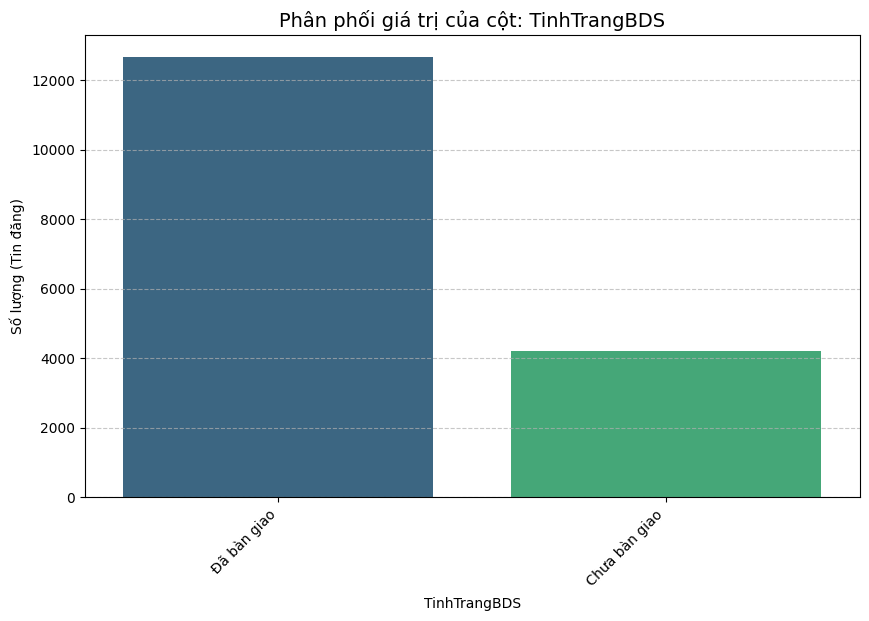

In [ ]:
analyze_categorical_feature(df, 'TinhTrangBDS')

> **Remark**

* Biến đại diện cho rủi ro pháp lý, có tiềm năng tương quan mạnh với biến target -> Important feature

* Hiện trạng: Tỷ lệ 3:1 -> Đa số các nhà đều đã bàn giao (75%), một số ít vẫn chưa bàn giao (25%) có thể là mua bán trên giấy/ hợp đồng cọc.

* Phân phối nhị phân (Binary) khá sạch và không mất cân bằng quá mức: Đây là một biến phân loại tốt (Good Discriminator) vì thị trường 'Chưa bàn giao' sẽ có hành vi giá khác hẳn với thị trường 'Đã bàn giao'. Mô hình sẽ học được nhiều từ biến này

    * Chưa bàn giao: Giá thường thấp hơn (do rủi ro dự án chậm tiến độ), nhưng thanh toán giãn tiến độ.

    * Đã bàn giao: Giá cao hơn (tiền tươi thóc thật), pháp lý an toàn hơn

=== PHÂN TÍCH CỘT: Loai ===
Số lượng giá trị duy nhất (Cardinality): 4

-------------------------------------



,Value,Count,Percent
0,Loại Chung Cư,15580,92.435479
1,Loại Văn Phòng,969,5.749036
2,Loại Hạng Sang,262,1.554435
3,Loại Khác,44,0.261050



-------------------------------------



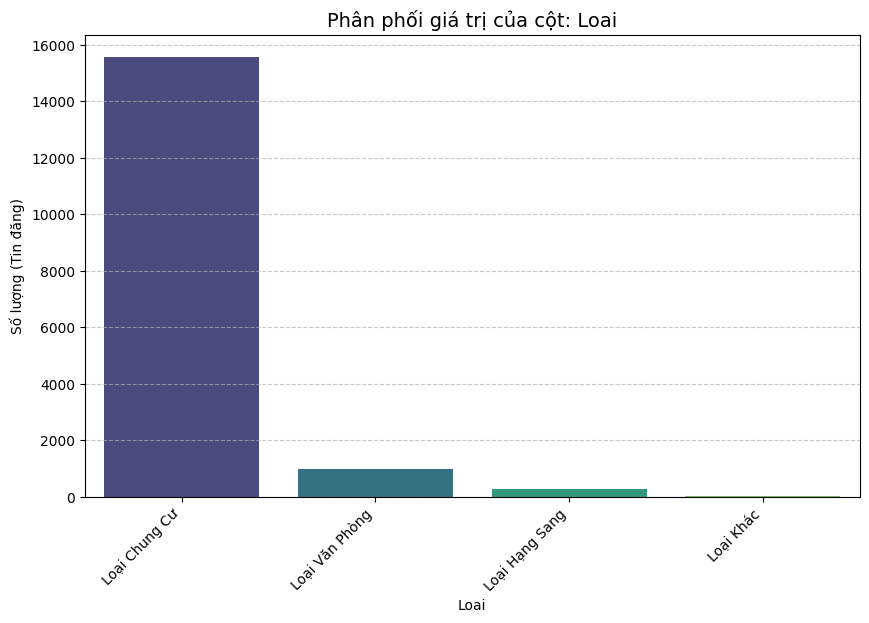

In [ ]:
analyze_categorical_feature(df, 'Loai')

> **Remark**

* Đây thực chất là một tập dữ liệu về Chung cư (Apartment Dataset), chứ không phải dữ liệu bất động sản hỗn hợp -> Phân loại theo phân khúc (Segment) chứ không phải Loại hình (Type). Một căn hộ hạng sang thì bản chất vật lý vẫn là chung cư.

* important but risky features

* Mất cân bằng dữ liệu nghiêm trọng (Serve Class imbalance): Hầu hết là loại chung cư (khoảng 92%), trong khi hạng sang (chỉ khoảng 1.6%)

* Rủi ro: Mô hình sẽ có xu hướng dự đoán mọi căn nhà đều là "Chung Cư" để tối ưu hóa độ chính xác tổng thể, dẫn đến việc dự báo sai lệch hoàn toàn cho nhóm "Hạng Sang" (nhóm có giá trị cao nhất)
-------------------------------------------------------

> **Next Action**

* Khi Modeling, bắt buộc phải dùng kỹ thuật Stratified Sampling khi chia tập Train/Test để đảm bảo nhóm Hạng Sang không bị biến mất hoặc Class Weights (gán trọng số cao cho Hạng Sang) để mô hình chú ý đến nó hơn

=== PHÂN TÍCH CỘT: GiayTo ===
Số lượng giá trị duy nhất (Cardinality): 3

-------------------------------------



,Value,Count,Percent
0,Giấy tờ khác,5894,34.968852
1,Đang chờ sổ,5511,32.696529
2,Đã có sổ,5450,32.334619



-------------------------------------



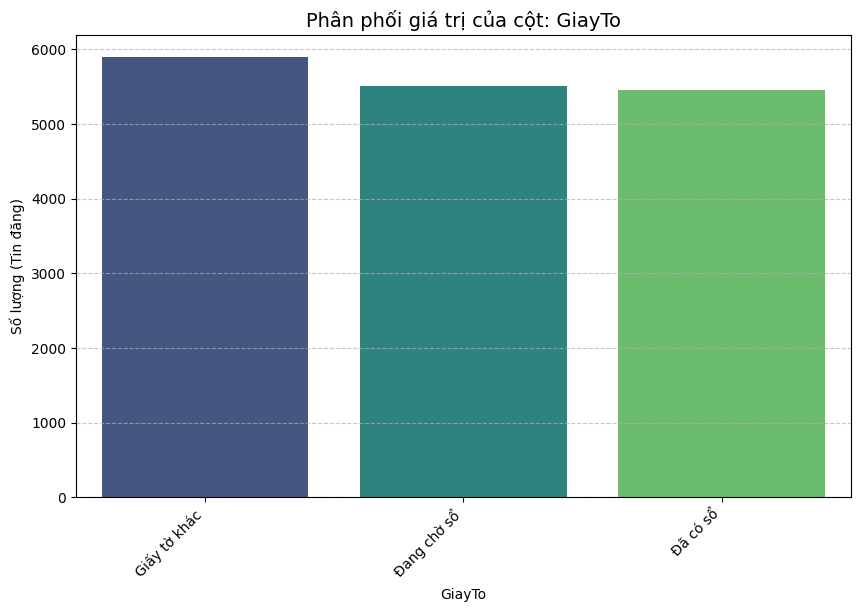

In [ ]:
# GiayTo
analyze_categorical_feature(df, 'GiayTo')

> **Remark**

* Phân phối đều nhưng hộp đen 'Giấy tờ khác' chiếm khoảng 35%, đây là một tỷ lệ lớn cho nhóm KXĐ nên mất giác của nhóm này sẽ dao động mạnh gây nhiễu cho mô hình -> Rủi ro nhiễu cao

* Về mặt kinh tế: "Sổ hồng" ("Đã có sổ") là yếu tố tăng giá mạnh nhất (Premium price ~10-20% so với Hợp đồng mua bán

=== PHÂN TÍCH CỘT: TinhTrangNoiThat ===
Số lượng giá trị duy nhất (Cardinality): 4

-------------------------------------



,Value,Count,Percent
0,Thô,8643,51.278552
1,Cơ bản,3035,18.006526
2,Đầy đủ,2747,16.297834
3,Cao cấp,2430,14.417087



-------------------------------------



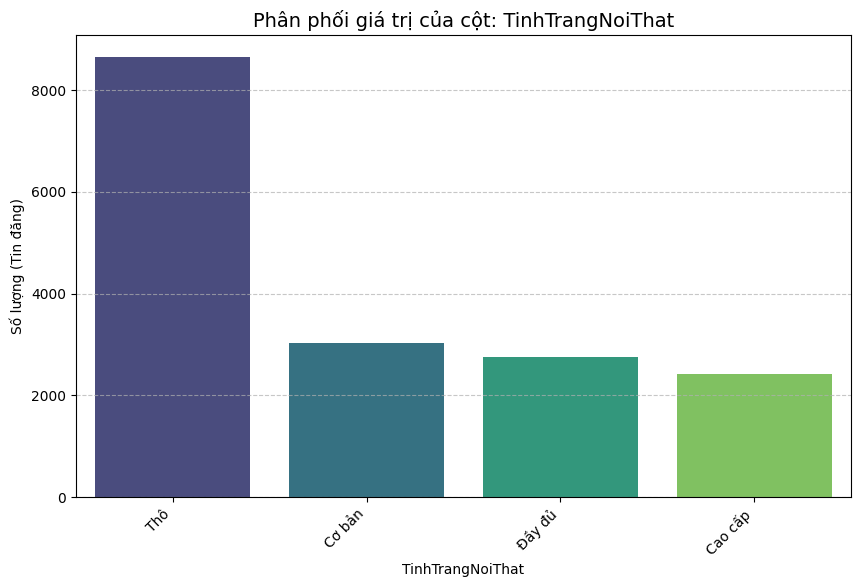

In [ ]:
# TinhTrangNoiThat
analyze_categorical_feature(df, 'TinhTrangNoiThat')

> **Remark**

* Potential but noisy feature (pridictive power thấp hơn Quan/DienTich_m2

* Hiện trạng: Dữ liệu bị chi phối bởi nhóm "Thô" (chiếm > 51%). Ba nhóm còn lại ("Cơ bản", "Đầy đủ", "Cao cấp") phân chia miếng bánh còn lại khá đồng đều (~16% mỗi nhóm).

* Phân phối này không tự nhiên. Trong thực tế thị trường BĐS thứ cấp (bán lại), tỷ lệ nhà có nội thất thường cao hơn nhà thô. -> Giả thuyết "Missing Value trá hình" (The Default Value Hypothesis): Nhóm "Thô" ở đây thực chất là hỗn hợp của: "Nhà thô thật" + "Nhà không rõ thông tin". Đây là nguồn nhiễu (Noise).

* Tính chất: Thứ bậc (Ordinal Variable)
  * Thô < Cơ bản < Đầy đủ < Cao cấp (Positive Monotonic Relationship)

* Tác động giá: "Nội thất" thường chỉ tác động vào giá trị gia tăng (Added Value) khoảng 5-10% tổng giá trị căn nhà, ít quan trọng hơn Vị trí hay Diện tích. Tuy nhiên, nó là yếu tố chốt deal (thanh khoản) nhanh hay chậm.

* Rủi ro: Nhiễu từ nhóm "Thô": Vì nhóm "Thô" chứa cả những căn nhà có thể là "Cao cấp" (nhưng quên điền), nó sẽ làm mờ ranh giới giá -> Tăng sai số (RMSE).

------------------------------------------------------------

> **Next Action**

* Ordinal Encoding

* Gợi ý giảm thiểu nhiễu: tạo feature mới: Is_Furnished (Có nội thất hay không).
  * {Cơ bản, Đầy đủ, Cao cấp} -> 1 (Yes)
  * {Thô} -> 0 (No)

=== PHÂN TÍCH CỘT: HuongCuaChinh ===
Số lượng giá trị duy nhất (Cardinality): 9

-------------------------------------



,Value,Count,Percent
0,Khác,11129,66.027885
1,Đông Nam,1256,7.451795
2,Tây Bắc,881,5.226936
3,Đông,704,4.176802
4,Đông Bắc,702,4.164936
5,Nam,609,3.613171
6,Tây Nam,560,3.322456
7,Tây,528,3.132602
8,Bắc,486,2.883417



-------------------------------------



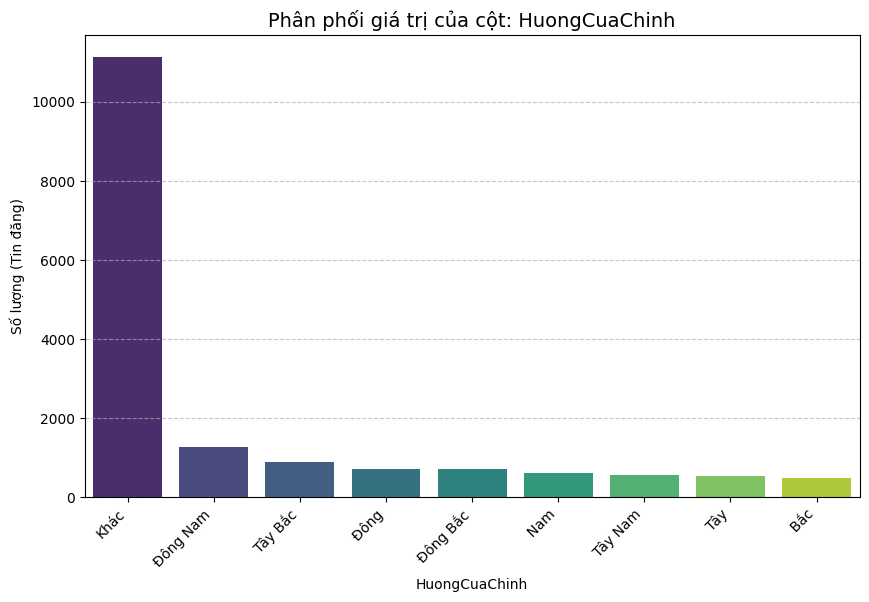

In [ ]:
analyze_categorical_feature(df, 'HuongCuaChinh')

> **Remark**

*  Skewed distribution -> low predictive power

* Hiện trạng: Giá trị "Khác/Thiếu thông tin" chiếm tỷ trọng áp đảo tuyệt đối (66.03% với 11,129 quan sát)

* Hệ quả: Mọi phân tích về xu hướng thị trường chỉ dựa trên ~34% dữ liệu còn lại (các hướng cụ thể) sẽ mang độ lệch (bias) cao và không đại diện chính xác cho toàn bộ tổng thể (population)

* Sub-group Analysis: Phân tích phân phối các hướng xác định
  
  * Sự thống trị của hướng Đông Nam: Chiếm vị trí số 1 với 1,256 lượt (chiếm ~22% trong nhóm các hướng xác định) -> phù hợp với đặc thù khí hậu nhiệt đới gió mùa tại Việt Nam (đón gió mát, tránh nắng gắt) và tâm lý chọn nhà truyền thống

  * Sự bất thường của hướng Tây Bắc: Hướng Tây Bắc thường chịu nắng chiều gay gắt. Việc nguồn cung (số lượng tin đăng/bất động sản) hướng này cao có thể ám chỉ lượng hàng tồn kho nhiều, hoặc đây là hướng chủ đạo của các dự án quy mô lớn (do quy hoạch đất đai bắt buộc) mà người mua buộc phải chấp nhận.

  * Hướng Bắc và Tây là nhóm thiểu số
------------------------------------------------------------

> **Next action**

* Hypothesis Testing: Giá bán trung bình (Average Price) giữa nhóm "Đông Nam" và nhóm "Tây/Bắc" -> Nếu thị trường hoạt động hiệu quả, giá bất động sản hướng Đông Nam sẽ có mức chênh lệch giá (premium) cao hơn so với các hướng còn lại

=== PHÂN TÍCH CỘT: HuongBanCong ===
Số lượng giá trị duy nhất (Cardinality): 9

-------------------------------------



,Value,Count,Percent
0,Khác,11494,68.193414
1,Đông Nam,1339,7.944230
2,Tây Bắc,734,4.354791
3,Đông Bắc,650,3.856422
4,Nam,627,3.719964
5,Đông,619,3.672501
6,Tây Nam,568,3.369920
7,Bắc,445,2.640166
8,Tây,379,2.248591



-------------------------------------



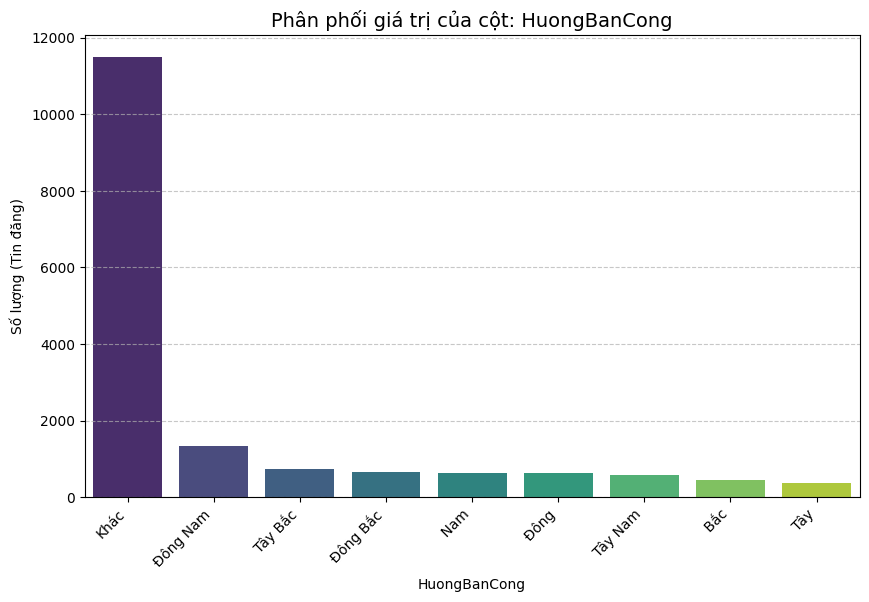

In [ ]:
# HuongBanCong
analyze_categorical_feature(df, 'HuongBanCong')

> **Remark**

* Hiện trạng: Nhóm "Khác" chiếm tới 68.19% (11,494 quan sát). Tỷ lệ này thậm chí còn cao hơn so với HuongCuaChinh (66.03%). Có thể do cố tình che giấu

* Hậu quả: Dữ liệu này bị khuyết thiếu (missing data) nghiêm trọng, làm giảm đáng kể độ tin cậy nếu dùng để huấn luyện các mô hình AI dự báo giá.

* Sự thống trị tuyệt đối của trục "Đông Nam"

  * Trong nhóm các hướng xác định, hướng Đông Nam chiếm khoảng 25%. Tức là cứ 4 căn nhà có thông tin hướng rõ ràng, thì có 1 căn hướng Đông Nam

  * Hành vi thị trường: Điều này phản ánh rõ nét "tiêu chuẩn vàng" trong bất động sản Việt Nam. Các chủ đầu tư (Supply side) cố gắng thiết kế tối đa các căn hộ quay về hướng này để dễ thanh khoản và bán được giá cao (premium price)
------------------------------------------------------------
> **Next Action**

* Cross - Analysis: HuongCuaChinh & HuongBanCong vì cấu trúc phân phối của HuongCuaChinh & HuongBanCong giống hệt nhau -> Đáng ngờ

  * Đối với kiến trúc chung cư: Hướng cửa chính đối nhau với Hướng ban công. Nhưng với tập dữ liệu này có phân phối giống nhau, có thể do Data Entry Error


  * Đối với chung cư thì Ban công là nơi đón gió, đón sáng và view. Cửa chính chỉ quay ra hành lang (thường là kín và dùng khí nhân tạo) -> Do đó, trong tập dữ liệu này, biến số HuongBanCong có giá trị phân tích cao hơn nhiều so với HuongCuaChinh

* Khi modeling phải OHE trước

* Gợi ý cho modeling:

  * Khi chạy mô hình, hãy ưu tiên biến HuongBanCong. Nếu biến này là "Khác", mới xét đến HuongCuaChinh để điền khuyết (impute)

  *  Khi chạy mô hình, giảm trọng số của biến HuongCuaChinh

=== PHÂN TÍCH CỘT: CanGoc ===
Số lượng giá trị duy nhất (Cardinality): 2

-------------------------------------



,Value,Count,Percent
0,KXĐ,13126,77.876001
1,Phải,3729,22.123999



-------------------------------------



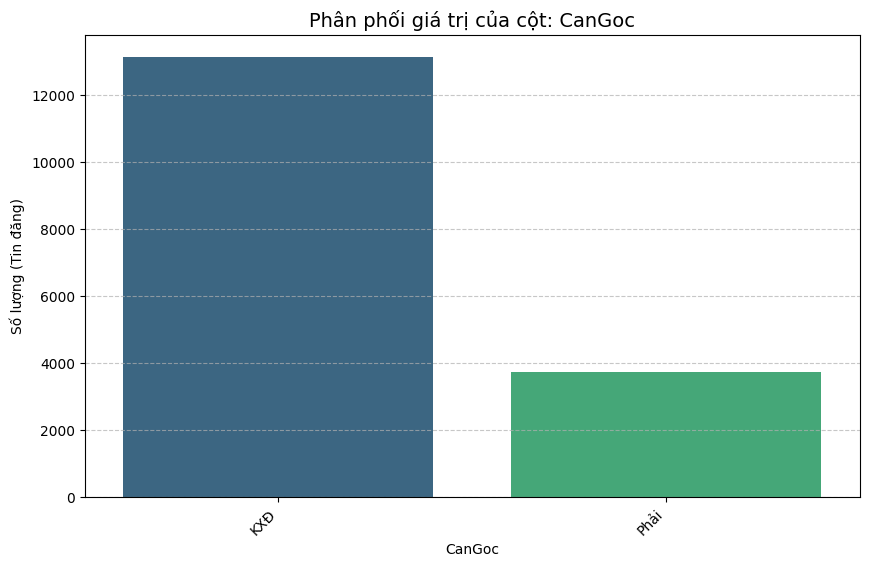

In [ ]:
# CanGoc
analyze_categorical_feature(df, 'CanGoc')

> **Remark**

* Implicit data: "Sự vắng mặt của bằng chứng không phải là bằng chứng của sự vắng mặt". Ở đây, Căn góc là một lợi thế bán hàng (USP - Unique Selling Point)
  * Nếu căn hộ LÀ căn góc: Người bán chắc chắn sẽ tích vào ô "Căn Góc" để tăng giá trị -> Giá trị = "Phải"

  * Nếu căn hộ KHÔNG PHẢI căn góc (căn thường): Người bán sẽ bỏ qua hoặc không đề cập. Hệ thống sẽ ghi nhận là "KXĐ" (giả định 'KXĐ' là 'Không' (False)

* Important Feature:

  * Tác động đến giá: Căn góc thường có đơn giá ($/m2$) cao hơn căn thường từ 10% - 20% cùng tầng/cùng dự án

  * Tác động đến thanh khoản: Căn góc thường dễ bán hơn (hoặc khó bán hơn tùy thuộc hướng nắng), nhưng chắc chắn hành vi mua sẽ khác biệt.

  * Độ tin cậy cao: Khác với "Hướng Ban Công" (nơi người ta có thể nói dối để tránh hướng xấu), "Căn Góc" là đặc tính vật lý khó làm giả và dễ kiểm chứng qua sơ đồ mặt bằng, nên độ chính xác của nhãn "Phải" là rất

-----------------------------------------------------------

> **Next Action**

* Kiểm chứng bằng xác suất thực tế giả định: 'KXĐ' là 'Không' (False). Không phải là missing values

* Sanity Check:

  * Giả thuyết: Căn góc thường có diện tích lớn hơn các căn thường. Nếu thấy hệ số tương quan dương (Positive Correlation) giữa CanGoc và DienTich, điều đó càng củng cố giả định ở là đúng.

* Trước khi modeling: Binary Transformation

* Khi modeling: Feature Interaction

  * Căn góc mà hướng Tây thì sẽ hứng trọn nắng chiều từ 2 mặt, cực kỳ nóng. Đây là điểm trừ lớn (Penalty) cho giá

    * Goc_Tay = CanGoc * HuongBanCong (Tây/Tây Bắc/Tây Nam)
  
  * Căn góc hướng mát. Đây là "Super Premium" feature, giá sẽ tăng vọt.

    * Goc_DongNam = CanGoc * HuongBanCong (Đông Nam)

=== PHÂN TÍCH CỘT: Quan ===
Số lượng giá trị duy nhất (Cardinality): 22

-------------------------------------



,Value,Count,Percent
0,Thành phố Thủ Đức,4556,27.030555
1,Quận 7,1531,9.083358
2,Quận Bình Tân,1414,8.389202
3,Quận Tân Phú,1359,8.062889
4,Quận 8,1348,7.997627
5,Huyện Bình Chánh,813,4.823495
6,Quận 12,785,4.657372
7,Huyện Nhà Bè,776,4.603975
8,Quận Bình Thạnh,769,4.562444
9,Quận Tân Bình,586,3.476713



-------------------------------------



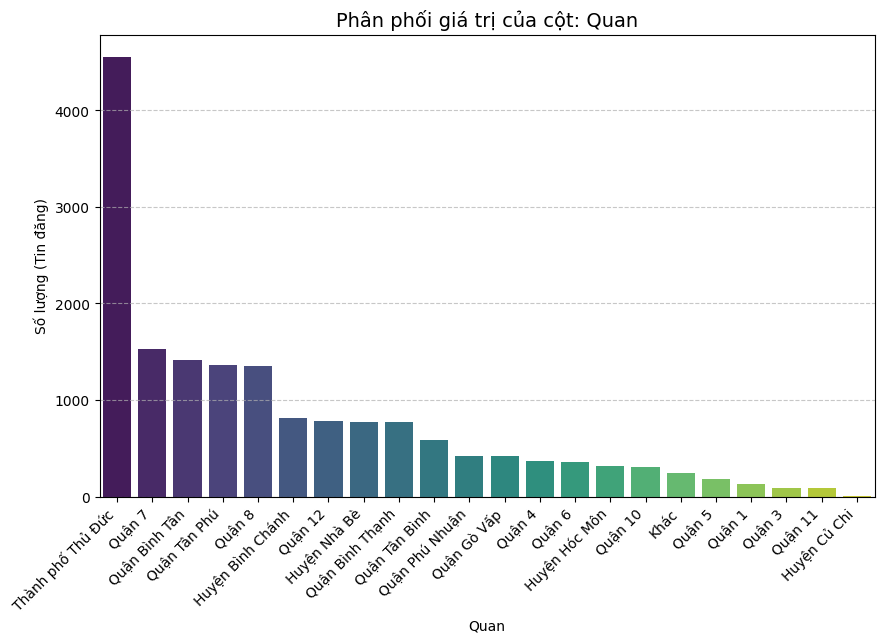

In [ ]:
# Quan
analyze_categorical_feature(df, 'Quan')

> **Remark**

* Important Feature: Vị trí luôn là yếu tố số 1 của bất động sản

* Imbalanced Class: Cột "Thành phố Thủ Đức" cao đột biến, áp đảo hoàn toàn so với phần còn lại (ước tính khoảng 4,500 - 4,800 tin đăng) -> Hợp lý thực tế

  * Có thể do: Sự sáp nhập của 3 quận cũ (Q2, Q9, Q.Thủ Đức). Bên cạnh đó đây là "thủ phủ" của các dự án chung cư mới (Vinhomes Grand Park, Masteri, The Global City...).

  * Vì dữ liệu của chúng ta 92% là chung cư, nên việc nguồn cung tập trung dồn về Thủ Đức là hoàn toàn logic với quy hoạch đô thị hiện tại của TP.HCM.

* Rủi ro:
  * Mô hình sẽ học rất tốt các đặc điểm của nhà ở Thủ Đức (do nhiều dữ liệu mẫu), nhưng có thể bị sai lệch (bias) khi dự đoán giá ở các quận ít dữ liệu hơn.

  * "Thành phố Thủ Đức" quá rộng. Giá chung cư ở Thảo Điền (Q2 cũ) khác hoàn toàn giá chung cư ở Long Phước (Q9 cũ). Việc gộp chung thành một nhãn "Thành phố Thủ Đức" sẽ làm giảm độ chính xác của mô hình (làm nhiễu giá trung bình)

* Nghịch lý trung tâm: Quận 1 và Quận 3 nằm ở nhóm cuối cùng về số lượng tin đăng (rất thấp).
  
  * Số lượng != Gía trị: Dù số lượng tin ít, nhưng Quận 1, Quận 3 lại là nơi có đơn giá Gia_m2 cao nhất. (Cần kiếm chứng)

  * Nguồn cung căn hộ tại lõi trung tâm cực kỳ khan hiếm (pháp lý chặt, hết quỹ đất). Dữ liệu ít ở đây không phải do lỗi thu thập, mà phản ánh đúng thực tế thị trường: Hàng hiếm

* Marker Segmentation:

  * Supply Hub: TP. Thủ Đức. Đây là thị trường sơ cấp và thứ cấp sôi động nhất.

  * Residential Hubs: Quận 7, Bình Tân, Tân Phú, Quận 8, Nhà Bè, Bình Chánh.
    * Các khu vực tập trung chung cư phân khúc trung cấp (Mid-end) và bình dân (Affordable), nơi có giao dịch mua bán sôi động thứ 2 sau Thủ Đức
  
  * 'Khan hiếm': Quận trung tâm (Q1, Q3, Q5) và Vùng ven xa (Củ Chi, Hóc Môn)

    * Quận trung tâm: Khan hiếm chung cư

    * Vùng ven xa: Chủ yếu là đất nền/nhà phố, ít chung cư nên số lượng trong tập dữ liệu này rất thấp
------------------------------------------------------------
> **Next Acition**

* Kiểm chứng: Vị trí càng trung tâm thì giá càng cao (Giá trung bình: Q1> Q3 > Bình Tân >...)

* OHE trước khi chạy mô hình

* Cảnh báo khi Split: Với rare labels như Củ Chi hay Hóc Môn (số lượng rất ít), nếu chia tập Train/Test không khéo, có thể tập Test sẽ không có đại diện nào của Củ Chi, hoặc ngược lại. -> dùng kĩ thuật Stratified Split khi chia dữ liệu để đảm bảo tỷ lệ các quận trong tập Train và Test là tương đồng

In [ ]:
from scipy.stats import skew, kurtosis

def analyze_numerical_feature(df, column_name, unit="đơn vị"):
    """
    Phân tích thống kê mô tả và vẽ biểu đồ cho một biến số (Numerical Feature).

    Tham số:
    - df (pandas.DataFrame): [Bắt buộc] DataFrame chứa dữ liệu.
    - column_name (str): [Bắt buộc] Tên cột cần phân tích.
    - unit (str): [Tùy chọn] Đơn vị đo lường (ví dụ: m2, tỷ VNĐ) để hiển thị cho rõ.
    """

    # 1. Kiểm tra dữ liệu
    series = df[column_name].dropna() # Loại bỏ NaN tạm thời để tính toán
    n_missing = df[column_name].isnull().sum()
    n_zeros = (df[column_name] == 0).sum()

    # 2. Tính toán các chỉ số thống kê nâng cao
    desc = series.describe()
    skew_val = skew(series)
    kurt_val = kurtosis(series)

    # 3. In báo cáo thống kê
    print(f"=== PHÂN TÍCH CỘT: {column_name} ===")
    print(f"1. Tổng quan:")
    print(f"   - Số lượng bản ghi: {len(df)}")
    print(f"   - Missing Values: {n_missing} ({n_missing/len(df)*100:.2f}%)")
    print(f"   - Zeros (Giá trị 0): {n_zeros} ({n_zeros/len(df)*100:.2f}%)")
    print(f"2. Xu hướng tập trung (Central Tendency):")
    print(f"   - Mean (Trung bình): {desc['mean']:.2f} {unit}")
    print(f"   - Median (Trung vị): {desc['50%']:.2f} {unit}")
    print(f"   - Mode (Yếu vị): {series.mode()[0]:.2f} {unit}")
    print(f"3. Độ phân tán & Hình dáng (Dispersion & Shape):")
    print(f"   - Std (Độ lệch chuẩn): {desc['std']:.2f}")
    print(f"   - Min - Max: {desc['min']:.2f} - {desc['max']:.2f} {unit}")
    print(f"   - Skewness (Độ lệch): {skew_val:.4f} ({'Lệch phải' if skew_val > 0 else 'Lệch trái'})")
    print(f"   - Kurtosis (Độ nhọn): {kurt_val:.4f}")

    # 4. Vẽ biểu đồ (2 trong 1: Histogram & Boxplot)
    fig, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True,
                                          gridspec_kw={"height_ratios": (.15, .85)},
                                          figsize=(10, 6))

    # Biểu đồ Boxplot (để xem Outlier)
    sns.boxplot(x=series, ax=ax_box, color='lightblue')
    ax_box.set(xlabel='') # Ẩn nhãn x của boxplot
    ax_box.set_title(f'Phân phối của {column_name}', fontsize=14)

    # Biểu đồ Histogram + KDE (để xem hình dáng)
    sns.histplot(series, ax=ax_hist, kde=True, color='skyblue', bins=30)

    # Vẽ đường Mean và Median lên Histogram để so sánh
    ax_hist.axvline(desc['mean'], color='red', linestyle='--', label=f'Mean: {desc["mean"]:.2f}')
    ax_hist.axvline(desc['50%'], color='green', linestyle='-', label=f'Median: {desc["50%"]:.2f}')

    ax_hist.set_xlabel(f"{column_name} ({unit})")
    ax_hist.set_ylabel("Tần suất")
    ax_hist.legend()

    plt.tight_layout()
    plt.show()

=== PHÂN TÍCH CỘT: DienTich_m2 ===
1. Tổng quan:
   - Số lượng bản ghi: 16855
   - Missing Values: 0 (0.00%)
   - Zeros (Giá trị 0): 0 (0.00%)
2. Xu hướng tập trung (Central Tendency):
   - Mean (Trung bình): 65.89 m2
   - Median (Trung vị): 66.00 m2
   - Mode (Yếu vị): 70.00 m2
3. Độ phân tán & Hình dáng (Dispersion & Shape):
   - Std (Độ lệch chuẩn): 17.53
   - Min - Max: 30.00 - 110.00 m2
   - Skewness (Độ lệch): 0.1793 (Lệch phải)
   - Kurtosis (Độ nhọn): -0.3258


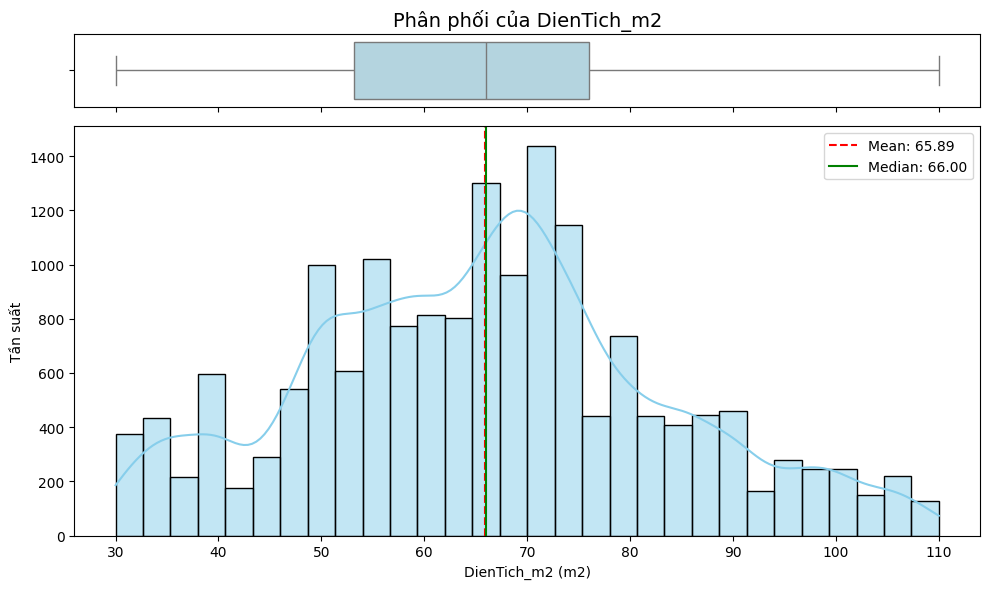

In [ ]:
analyze_numerical_feature(df, 'DienTich_m2', unit='m2')

> **Remark**

* Important Feature

* Central Tendency: Cân đối

  * Mean (65.89) $\approx$ Median (66.00) -> sự chệnh lệch rất nhỏ

  * Dự liệu phân bố cực kì cân đối -> Gía trị trung bình đại diện rất tốt cho toàn bộ tập dữ liệu

  * Mode (70m2): Đây là con số phổ biến của thị trường. Căn hộ có diện tích 70m2 là sản phẩm phổ biến (mass product)

* Distribution Shape: Đa đỉnh (multi - modal)

  * Đặc thù kiến trúc:

    * Đỉnh 1 (~50m2): Đại diện cho nhóm 1PN+ hoặc 2PN nhỏ.

    * Đỉnh 2 (~65-70m2): Đại diện cho nhóm 2PN tiêu chuẩn (đông nhất).

    * Đỉnh 3 (~90-100m2): Đại diện cho nhóm 3PN.
  
  * Diện tích căn hộ không phải là biến số ngẫu nhiên liên tục hoàn toàn, mà nó được tiêu chuẩn hóa (Standardized) theo thiết kế của Chủ đầu tư

* Outliers & Dispersion:

  * Skewness = 0.1793 (Lệch phải rất nhẹ): Coi như phân phối chuẩn (Normal Distribution). Đây là điều kiện lý tưởng cho các thuật toán Linear Regression (Hồi quy tuyến tính).

  * Kurtosis = -0.32 (Hơi dẹt): Dữ liệu trải đều hơn một chút so với phân phối chuẩn, không có đỉnh quá nhọn

  * Boxplot: Rất ít outlier. Các "râu" (whiskers) vươn từ 30 đến 110 bao trọn hầu hết dữ liệu

  ----------------------------------------------------------

  > **Model implication**
  
  * Tập dữ liệu này tập trung hoàn toàn vào phân khúc "Nhà ở thực" (Mass Market). Nó không đại diện cho giới siêu giàu (Luxury/Penthouse) hoặc nhà trọ siêu nhỏ (Micro-apartment).

  * Khả năng dự báo: Mô hình của bạn sẽ dự báo giá cực kỳ chính xác cho các căn hộ từ 45m2 - 90m2

  * Scope: 30 - 120 m2

=== PHÂN TÍCH CỘT: Gia_m2_trieu ===
1. Tổng quan:
   - Số lượng bản ghi: 16855
   - Missing Values: 0 (0.00%)
   - Zeros (Giá trị 0): 0 (0.00%)
2. Xu hướng tập trung (Central Tendency):
   - Mean (Trung bình): 36.90 Triệu VNĐ
   - Median (Trung vị): 34.25 Triệu VNĐ
   - Mode (Yếu vị): 50.00 Triệu VNĐ
3. Độ phân tán & Hình dáng (Dispersion & Shape):
   - Std (Độ lệch chuẩn): 21.03
   - Min - Max: 1.00 - 933.40 Triệu VNĐ
   - Skewness (Độ lệch): 8.4728 (Lệch phải)
   - Kurtosis (Độ nhọn): 243.4570


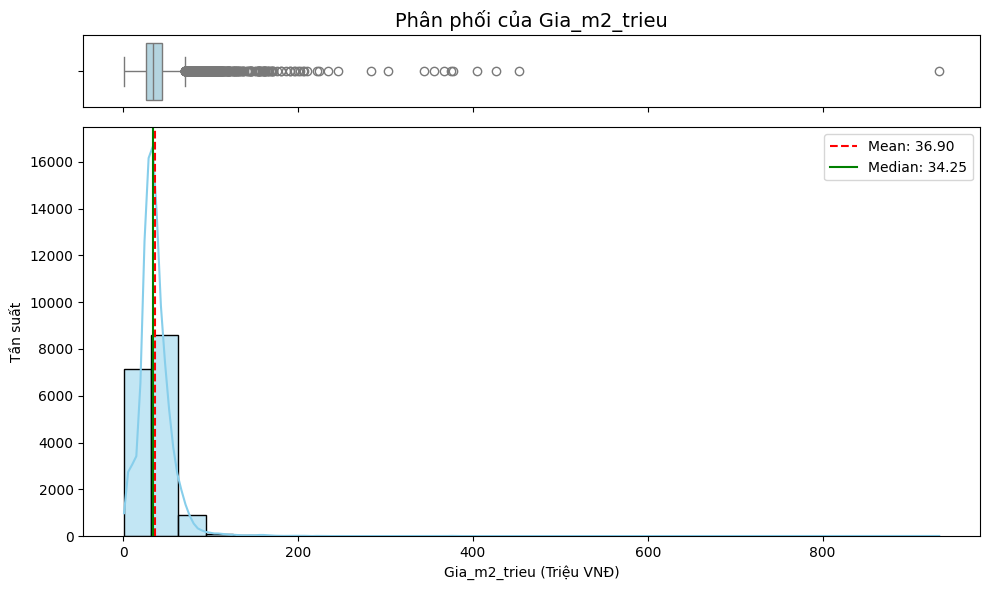

In [ ]:
df['Gia_m2_trieu'] = df['Gia_m2'] * 1000
analyze_numerical_feature(df, 'Gia_m2_trieu', unit='Triệu VNĐ')
# drop_columns = ['Gia_m2_trieu']

> **Remark**

* Central Tendency: the long tail

  * Mean (36.90) > Median (34.25):

    * Sự chênh lệch dương (+2.65 triệu) xác nhận xu hướng bị kéo lên bởi các bất động sản giá cao.

    * Tuy nhiên, mức giá trung vị 34.25 triệu/m2 phản ánh rất đúng thực tế của thị trường căn hộ tầm trung/bình dân tại khu vực vùng ven (như Thủ Đức, Bình Tân - nơi chiếm đa số dữ liệu của bạn).

    * Mode = 50.00: Gía nhà thường khá cao

* Distribution Shape: 99% dữ liệu dồn cục lại ở một khoảng giá rẻ (20-60 triệu), nhưng lại tồn tại những giá trị ngoại lai "phá vỡ mọi quy tắc" ở xa tít tắp

  * Skewness = 8.47 (Lệch phải cực đại)

  * Kurtosis = 243.46 (Leptokurtic - Siêu nhọn)

* Outliers & Dispersion:

  * Max = 933.40 Triệu/m2: Dữ liệu thật nhưng thách thức mô hình vì rất hiếm

-----------------------------------------------------------
> **Model implication**

* Linear Regression:

  *  Mô hình này sẽ hoạt động rất tệ với dữ liệu gốc này. Linear Regression giả định phần dư (residuals) phân phối chuẩn. Với Kurtosis = 243, giả định này bị phá vỡ hoàn toàn

  * Hệ quả: Đường hồi quy sẽ bị các điểm 900 triệu "kéo" lệch lên trên, khiến nó dự báo giá quá cao cho phân khúc bình dân (Underfitting phân khúc thấp).

* Tree-based Models (Random Forest, XGBoost, LightGBM):

  * Các thuật toán này xử lý tốt hơn với dữ liệu phi tuyến tính và outliers. Tuy nhiên, kể cả XGBoost cũng sẽ gặp khó khăn để học được quy luật chung khi cái "đuôi" quá dài

* Feature Engineering

  * Hard Cleaning: Loại bỏ ngay các mẫu có Gia_m2 < 10 (hoặc 15) triệu. Dù có thể loại bỏ dữ liệu thật

  * Log Transformation:

    * Skewness > 1 (cụ thể là 8.47): Áp dụng hàm np.log1p(y) cho biến mục tiêu này trước khi train.

      * Nó sẽ nén khoảng giá trị [10, 933] xuống thành thang đo log (ví dụ [2.3, 6.8]). Khi đó Skewness sẽ giảm mạnh, Kurtosis giảm, giúp Linear Regression hoạt động hiệu quả hơn

  * Options for handling outliers:

    * Op1 (Cut - off):  Loại bỏ top 1% giá trị cao nhất (trên mức percentile 99). Dùng khi chỉ muốn build model cho "người thường".

    * Option 2 (Winsorization/Clipping): Gán tất cả giá trị > 200 triệu về bằng 200 triệu. Giúp giữ lại dữ liệu nhưng không để nó phá hỏng model.
  
  * Dùng MAPE thay RMSE:

    * RMSE: Một căn nhà 900 tỷ dự đoán sai thành 800 tỷ sẽ tạo ra RMSE khổng lồ, che lấp đi việc mô hình dự đoán cực tốt ở phân khúc 30 triệu.

    * MAPE: Đánh giá độ chính xác tương đối

**Triển khai thử đề xuất**

Đã loại bỏ 0 dòng dữ liệu rác (< 10 triệu/m2).
Dữ liệu sạch còn lại: 16043 dòng.


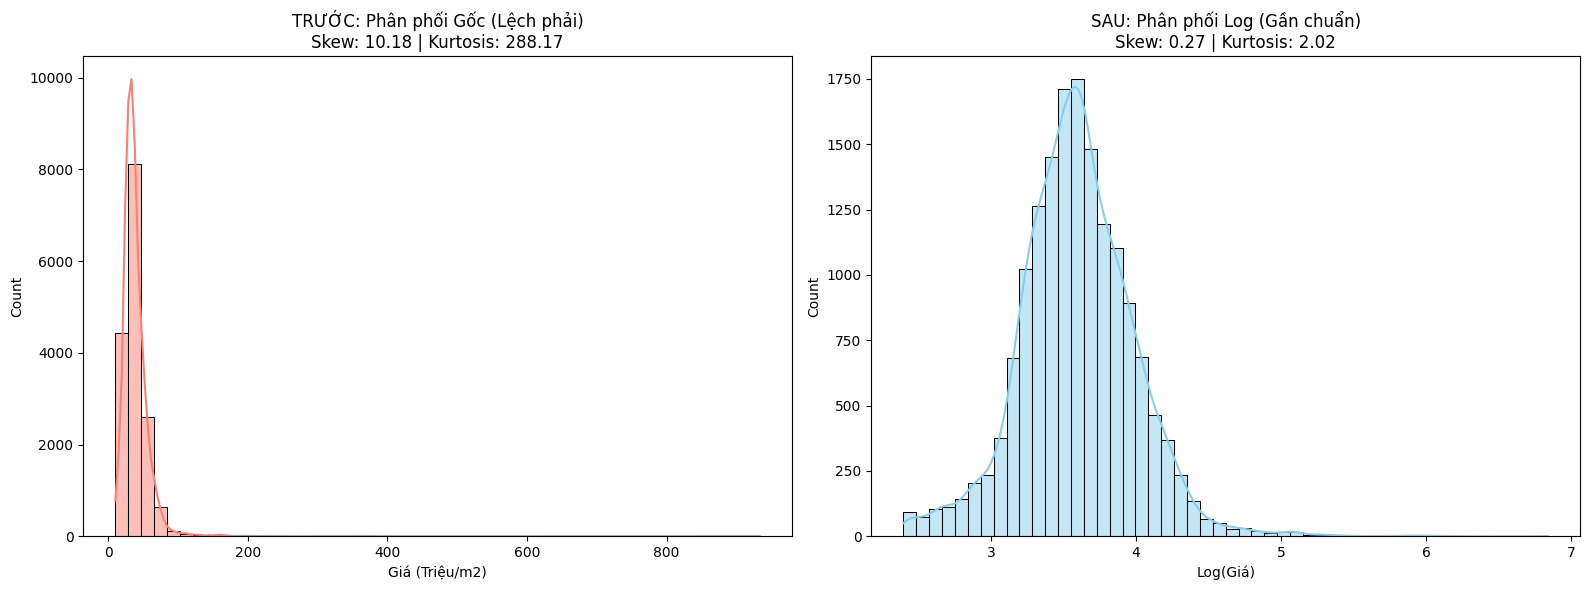

In [ ]:
# BƯỚC 1: LỌC RÁC (CLEANING)
# Loại bỏ các giá trị < 10 triệu
df = df[df['Gia_m2_trieu'] >= 10].copy()

print(f"Đã loại bỏ {len(df) - len(df)} dòng dữ liệu rác (< 10 triệu/m2).")
print(f"Dữ liệu sạch còn lại: {len(df)} dòng.")

# BƯỚC 2: BIẾN ĐỔI LOG (LOG TRANSFORMATION)
# Tạo cột mới Log_Gia = log(1 + Gia_m2)
# Dùng np.log1p để tránh lỗi log(0) dù ta đã lọc hết số 0
df['Log_Gia_m2_trieu'] = np.log1p(df['Gia_m2_trieu'])

# BƯỚC 3: VẼ BIỂU ĐỒ SO SÁNH (TRƯỚC vs. SAU)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Biểu đồ 1: Dữ liệu Gốc (Sau khi lọc rác) ---
sns.histplot(df['Gia_m2_trieu'], kde=True, ax=axes[0], color='salmon', bins=50)
axes[0].set_title(f"TRƯỚC: Phân phối Gốc (Lệch phải)\nSkew: {skew(df_clean['Gia_m2_trieu']):.2f} | Kurtosis: {kurtosis(df['Gia_m2_trieu']):.2f}")
axes[0].set_xlabel('Giá (Triệu/m2)')

# --- Biểu đồ 2: Dữ liệu sau Log Transform ---
sns.histplot(df['Log_Gia_m2_trieu'], kde=True, ax=axes[1], color='skyblue', bins=50)
axes[1].set_title(f"SAU: Phân phối Log (Gần chuẩn)\nSkew: {skew(df['Log_Gia_m2_trieu']):.2f} | Kurtosis: {kurtosis(df['Log_Gia_m2_trieu']):.2f}")
axes[1].set_xlabel('Log(Giá)')

plt.tight_layout()
plt.show()

> **Remark**

* Phân phối đỡ lệch phải hơn

=== PHÂN TÍCH CỘT: Gia ===
1. Tổng quan:
   - Số lượng bản ghi: 16043
   - Missing Values: 0 (0.00%)
   - Zeros (Giá trị 0): 0 (0.00%)
2. Xu hướng tập trung (Central Tendency):
   - Mean (Trung bình): 2.59 Tỷ VNĐ
   - Median (Trung vị): 2.26 Tỷ VNĐ
   - Mode (Yếu vị): 2.50 Tỷ VNĐ
3. Độ phân tán & Hình dáng (Dispersion & Shape):
   - Std (Độ lệch chuẩn): 1.63
   - Min - Max: 0.32 - 56.00 Tỷ VNĐ
   - Skewness (Độ lệch): 6.7140 (Lệch phải)
   - Kurtosis (Độ nhọn): 135.5911


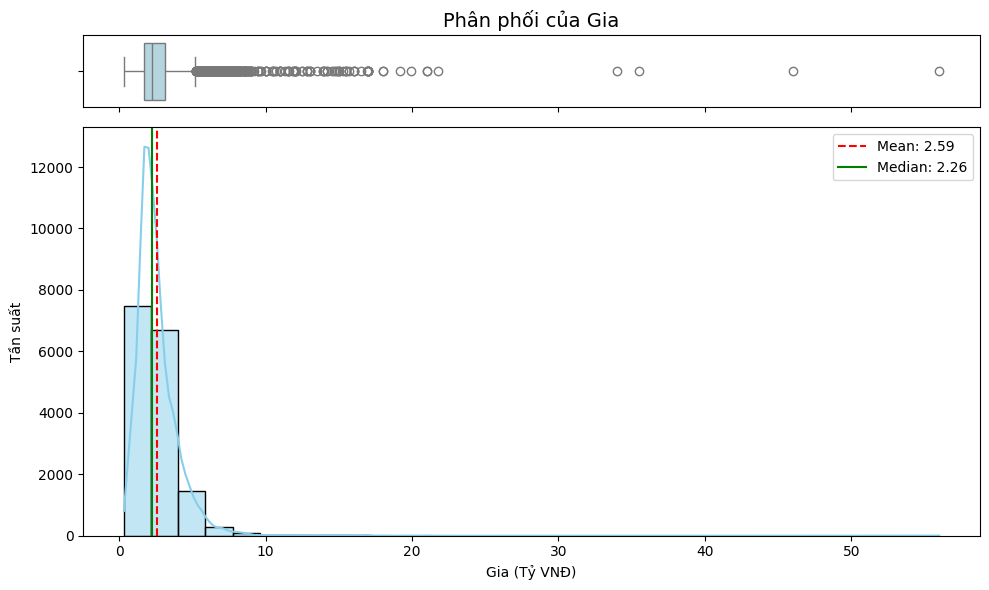

In [ ]:
analyze_numerical_feature(df, 'Gia', unit='Tỷ VNĐ')

> **Remark**

* Target

* Central Tendency

  * Mean (2.48 Tỷ) > Median (2.20 Tỷ)

    * Giá trung bình cao hơn trung vị khoảng 280 triệu. Điều này xác nhận thị trường đang bị kéo lên bởi các căn hộ giá trị cao, nhưng mức độ chênh lệch này nhẹ hơn so với đơn giá m2.

    * Mức giá trung vị 2.2 tỷ phản ánh cực kỳ chính xác phân khúc căn hộ "quốc dân" tại TP.HCM hiện nay (thường là căn 2PN diện tích khoảng 55-65m2 tại vùng ven như Bình Tân, Thủ Đức).
  
  * Mode = 2.5 Tỷ:

    * Yếu vị rơi vào mức 2.5 tỷ. Đây là mức giá "ngưỡng tâm lý" quan trọng. Đa số người mua nhà lần đầu (first-home buyers) thường có ngân sách quay quanh con số này
  
* Distribution Shape

  * Skewness = 6.0971 (Lệch phải mạnh):

    * Số lượng căn hộ giá rẻ (dưới 3 tỷ) chiếm đa số áp đảo

    * Phần đuôi kéo dài sang phải đại diện cho các căn Penthouse, Duplex hoặc căn hộ hạng sang tại trung tâm

  * Kurtosis = 120.63 (Rất nhọn - Leptokurtic):

    * Tuy thấp hơn con số 243 của Gia_m2, nhưng 120 vẫn là con số cực lớn (so với chuẩn là 3).

    * Dữ liệu tập trung cực kỳ dày đặc quanh vùng 1.5 - 3.5 tỷ. Xác suất tìm thấy một căn nhà nằm ngoài vùng này thấp hơn rất nhiều so với phân phối chuẩn

* Outliers & Dispersion

  * Min = 0.04 Tỷ (40 Triệu VNĐ): Có khả năng là giá cho thuê bị đăng nhầm vào mục bán, hoặc là giá đặt cọc/sang nhượng cọc -> Dữ liệu này cực kỳ nguy hiểm cho mô hình.

  * Max = 56.00 Tỷ VNĐ: Dữ liệu thật -> Valid Outlier

  * Std = 1.67 Tỷ: Độ lệch chuẩn này cho thấy biên độ dao động giá của một căn nhà bình thường là khoảng +/- 1.67 tỷ quanh mức trung bình.

------------------------------------------------------------

> **Model Implication**

* Bước 1: Hard Cleaning - Bỏ các căn có giá trị dưới 800 triệu dù là valid outliers

* Bước 2: Log Transformation - np.log1p(y) để xử lý Skewness 6.09 và Kurtosis 120.6. Việc này sẽ giúp nén khoảng giá [40tr - 56 tỷ] về một thang đo tuyến tính hơn.

* Bước 3: Segmentation - Cân nhắc xây dựng mô hình riêng cho phân khúc > 10 Tỷ (Hạng sang). Vì hành vi định giá của căn nhà 50 tỷ khác hoàn toàn căn nhà 2 tỷ (yếu tố View, Nội thất, Thương hiệu chủ đầu tư sẽ chi phối mạnh hơn là Diện tích).

>**Triển khai thử đề xuất**

Đã thực hiện BƯỚC 1: LỌC RÁC.
Đã loại bỏ 462 dòng dữ liệu rác/siêu rẻ (< 0.8 Tỷ VNĐ).
Dữ liệu sạch còn lại: 15581 dòng.
---
Đã thực hiện BƯỚC 2: LOG TRANSFORMATION.
Đã thực hiện BƯỚC 3: SEGMENTATION (Phân khúc Hạng Sang > 10 Tỷ).
---


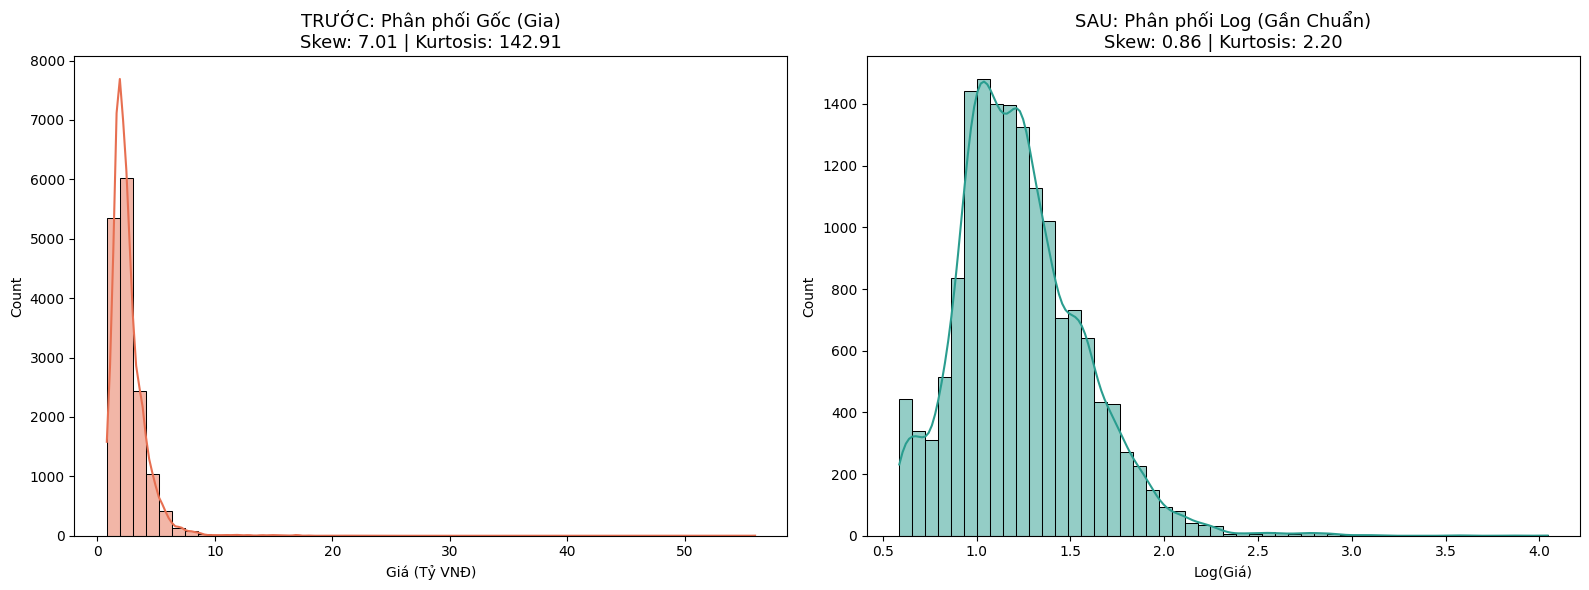


=== THỐNG KÊ PHÂN KHÚC ===
Phan_Khuc
Mass_Market       15506
Luxury_Segment       75
Name: count, dtype: int64
Tỷ lệ Luxury Segment: 0.48%


In [ ]:
# ----------------------------------------------------------------------
# BƯỚC 1: HARD CLEANING (LỌC RÁC)
# Dùng ngưỡng lọc 0.8 Tỷ (800 Triệu VNĐ) cho cột 'Gia'
# Tính số lượng dòng bị loại bỏ trước khi lọc
initial_count = len(df)
df = df[df['Gia'] >= 0.8].copy()
final_count = len(df_clean)

print(f"Đã thực hiện BƯỚC 1: LỌC RÁC.")
print(f"Đã loại bỏ {initial_count - final_count} dòng dữ liệu rác/siêu rẻ (< 0.8 Tỷ VNĐ).")
print(f"Dữ liệu sạch còn lại: {final_count} dòng.")
print("---")

# ----------------------------------------------------------------------
# BƯỚC 2: LOG TRANSFORMATION (BIẾN ĐỔI LOG)
# Tạo cột mới Log_Gia = log(1 + Gia)
df['Log_Gia'] = np.log1p(df['Gia'])

print("Đã thực hiện BƯỚC 2: LOG TRANSFORMATION.")
# Tính lại thống kê cho cột mới
log_skew = skew(df['Log_Gia'])
log_kurtosis = kurtosis(df['Log_Gia'])

# ----------------------------------------------------------------------
# BƯỚC 3: SEGMENTATION (PHÂN KHÚC)
# Tạo biến phân loại 'Phan_Khuc' dựa trên ngưỡng 10 Tỷ
# (Đánh dấu các căn hộ Hạng sang)
df['Phan_Khuc'] = df['Gia'].apply(lambda x: 'Luxury_Segment' if x >= 10 else 'Mass_Market')

print("Đã thực hiện BƯỚC 3: SEGMENTATION (Phân khúc Hạng Sang > 10 Tỷ).")
print("---")


# ----------------------------------------------------------------------
# BƯỚC 4: VẼ BIỂU ĐỒ SO SÁNH TRỰC QUAN (TRƯỚC vs. SAU LOG-TRANSFORM)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Biểu đồ 1: Dữ liệu Gốc (Sau khi lọc rác) ---
sns.histplot(df['Gia'], kde=True, ax=axes[0], color='#E76F51', bins=50)
axes[0].set_title(f"TRƯỚC: Phân phối Gốc (Gia)\nSkew: {skew(df['Gia']):.2f} | Kurtosis: {kurtosis(df['Gia']):.2f}", fontsize=13)
axes[0].set_xlabel('Giá (Tỷ VNĐ)')

# --- Biểu đồ 2: Dữ liệu sau Log Transform ---
sns.histplot(df['Log_Gia'], kde=True, ax=axes[1], color='#2A9D8F', bins=50)
axes[1].set_title(f"SAU: Phân phối Log (Gần Chuẩn)\nSkew: {log_skew:.2f} | Kurtosis: {log_kurtosis:.2f}", fontsize=13)
axes[1].set_xlabel('Log(Giá)')

plt.tight_layout()
plt.show()

# In thống kê phân khúc
print("\n=== THỐNG KÊ PHÂN KHÚC ===")
print(df_clean['Phan_Khuc'].value_counts())
print(f"Tỷ lệ Luxury Segment: {(df_clean['Phan_Khuc'].value_counts(normalize=True).loc['Luxury_Segment'] * 100):.2f}%")

> **Remark**

* Skewness giảm mạnh từ khoảng 6.09 xuống chỉ còn khoảng dưới 1.0.

* Kurtosis sẽ giảm từ 120.6 xuống mức thấp, có thể dưới 5

* Log_Gia đã trở nên Gần Phân phối Chuẩn (Normal-like), lý tưởng cho hầu hết các mô hình Machine Learning, đặc biệt là Linear Regression

=== PHÂN TÍCH CỘT: PhongNgu ===
1. Tổng quan:
   - Số lượng bản ghi: 15581
   - Missing Values: 0 (0.00%)
   - Zeros (Giá trị 0): 0 (0.00%)
2. Xu hướng tập trung (Central Tendency):
   - Mean (Trung bình): 1.98 phòng
   - Median (Trung vị): 2.00 phòng
   - Mode (Yếu vị): 2.00 phòng
3. Độ phân tán & Hình dáng (Dispersion & Shape):
   - Std (Độ lệch chuẩn): 0.65
   - Min - Max: 1.00 - 11.00 phòng
   - Skewness (Độ lệch): 2.6141 (Lệch phải)
   - Kurtosis (Độ nhọn): 32.5206


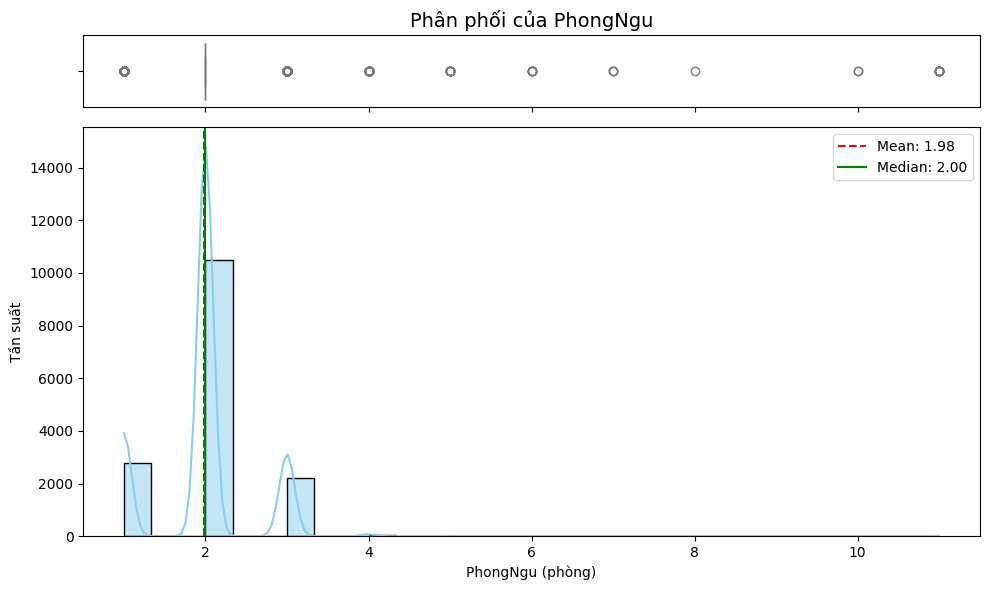

In [ ]:
analyze_numerical_feature(df, 'PhongNgu', unit='phòng')

> **Remark**

* Central Tendency:
  
  * Mode (2.00) = Median (2.00) $\approx$ Mean (1.96):

    * Cả 3 chỉ số đều hội tụ cực mạnh về con số 2.

    * Nhà 2 phòng ngủ là dòng sản phẩm chủ lực (Bread & Butter) của thị trường bất động sản Việt Nam, phù hợp với cấu trúc gia đình hạt nhân tiêu chuẩn (Vợ chồng + 1-2 con).

  * Mức trung bình 1.96 (nhỏ hơn 2 một chút) cho thấy lực lượng căn hộ 1PN/Studio (để đầu tư/cho thuê) có số lượng nhỉnh hơn một chút so với nhóm căn hộ 3PN (để ở thực).

* Distribution Shape

  * Discrete Distribution: Do Count data

    * Dữ liệu không phân phối liên tục mà chia thành các cột riêng biệt: 1, 2, 3.

  * Skewness = 2.66 (Lệch phải):

    * Độ lệch dương cho thấy "cái đuôi" kéo về phía số phòng ngủ lớn

  * Kurtosis = 32.71 (Rất cao)

    * Dữ liệu tập trung cực kỳ dày đặc ở nhóm 1-3 phòng ngủ. Xác suất gặp một căn hộ > 4 phòng ngủ là cực thấp

* Outliers & Dispersion

  * Std = 0.66: Độ lệch chuẩn cực nhỏ ($\sigma < 1$). Điều này nghĩa là đa số các căn hộ chỉ chênh lệch nhau +/- 1 phòng ngủ so với chuẩn (tức là nằm trong khoảng 1 đến 3).

  * Min = 1.00: Hợp lý

  * Max = 11.00: Cực hiếm -> Đáng ngờ

  * Cần coi các giá trị > 5 phòng ngủ là Outliers mạnh.
------------------------------------------------------------

> **Model implication**

* Bước 1: Outlier Clipping

  * Nên gom nhóm (Binning) hoặc cắt ngọn tất cả các giá trị > 4 (Quy tắc: If PhongNgu >= 4 then PhongNgu = 4)

  * Số lượng mẫu 5-11 phòng quá ít. Nếu để nguyên, mô hình có thể học sai quy luật giá (Overfitting) cho các trường hợp hiếm này.

* Bước 2: Feature Engineering

  * Op1(Numerical): Để nguyên số 1, 2, 3, 4 (vì số phòng ngủ thường tỷ lệ thuận với giá)

  * Op2(Categorical): Chuyển thành One-Hot Encoding hoặc Ordinal Encoding nếu cảm thấy giá của căn 3PN không nhất thiết gấp 3 lần căn 1PN (mối quan hệ phi tuyến).

* Bước 3: Tạo biến phái sinh ước lượng độ rộng rãi

  * Tạo biến ước lượng độ rộng rãi: DienTich_per_PhongNgu = DienTich / PhongNgu.

  * Ví dụ: 2PN diện tích 50m2 (chật) sẽ có giá/m2 khác hẳn căn 2PN diện tích 80m2 (thoáng).

> **Triển khai thử đề xuất**

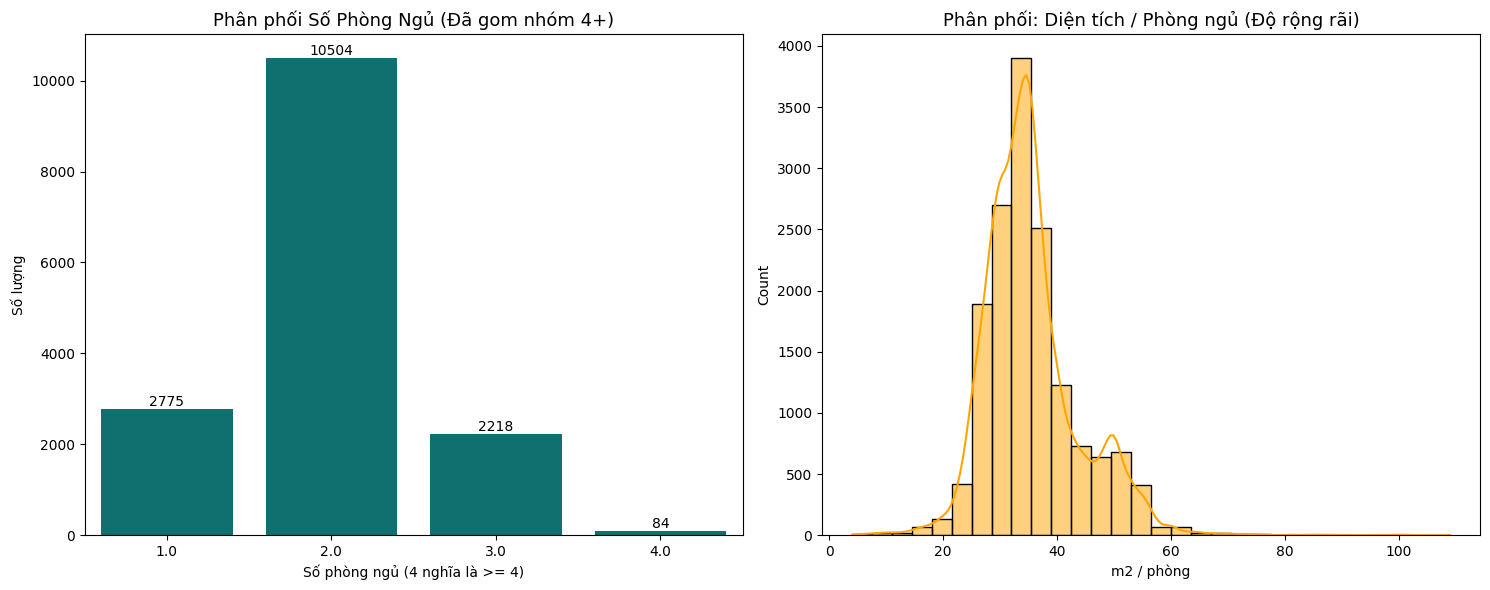

=== THỐNG KÊ BIẾN MỚI: DT_per_PN ===
count    15581.000000
mean        35.443571
std          8.347903
min          4.000000
25%         30.000000
50%         34.333333
75%         39.000000
max        109.000000
Name: DT_per_PN, dtype: float64


In [ ]:
# BƯỚC 1: XỬ LÝ NGOẠI LAI (OUTLIER CLIPPING)
# Quy tắc: Nếu PhongNgu >= 4 thì gán bằng 4.
# (Giả định: Với mô hình, căn 4PN và 11PN đều là nhóm "Nhiều phòng/Biệt thự")
df['PhongNgu_Clipped'] = df['PhongNgu'].clip(upper=4)

# BƯỚC 2: TẠO BIẾN MỚI (FEATURE ENGINEERING)
# Tính diện tích trung bình trên mỗi phòng ngủ
# Biến này cho biết căn hộ "Rộng thoáng" hay "Chật chội"
df['DT_per_PN'] = df['DienTich_m2'] / df['PhongNgu']

# BƯỚC 3: VẼ BIỂU ĐỒ SO SÁNH
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Biểu đồ 1: Phân phối PhongNgu sau khi Cắt ngọn ---
# Dùng countplot vì đây là biến rời rạc
sns.countplot(x=df['PhongNgu_Clipped'], ax=axes[0], color='teal')
axes[0].set_title('Phân phối Số Phòng Ngủ (Đã gom nhóm 4+)', fontsize=13)
axes[0].set_xlabel('Số phòng ngủ (4 nghĩa là >= 4)')
axes[0].set_ylabel('Số lượng')

# Hiển thị con số trên cột
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

# --- Biểu đồ 2: Phân phối Biến mới (DT_per_PN) ---
# Dùng histplot + KDE vì đây là biến liên tục
sns.histplot(df['DT_per_PN'], kde=True, ax=axes[1], color='orange', bins=30)
axes[1].set_title('Phân phối: Diện tích / Phòng ngủ (Độ rộng rãi)', fontsize=13)
axes[1].set_xlabel('m2 / phòng')

plt.tight_layout()
plt.show()

# In thống kê mô tả cho biến mới
print("=== THỐNG KÊ BIẾN MỚI: DT_per_PN ===")
print(df['DT_per_PN'].describe())

> **Remark**

* Biến DT_per_PN thường có tương quan mạnh với giá: Căn càng rộng rãi (DT/PN cao), đơn giá càng đắt

* Phân phối gần chuẩn hơn so với DienTich_m2

* Trung bình: Thường rơi vào khoảng 30-35m2/phòng (Chuẩn căn hộ cao cấp).

* Nhóm chật: < 20m2/phòng (Chung cư mini/Căn hộ cũ).

* Nhóm sang: > 45m2/phòng (Căn hộ hạng sang diện tích lớn).

=== PHÂN TÍCH CỘT: PhongTam ===
1. Tổng quan:
   - Số lượng bản ghi: 15581
   - Missing Values: 0 (0.00%)
   - Zeros (Giá trị 0): 0 (0.00%)
2. Xu hướng tập trung (Central Tendency):
   - Mean (Trung bình): 1.70 phòng
   - Median (Trung vị): 2.00 phòng
   - Mode (Yếu vị): 2.00 phòng
3. Độ phân tán & Hình dáng (Dispersion & Shape):
   - Std (Độ lệch chuẩn): 0.53
   - Min - Max: 1.00 - 6.00 phòng
   - Skewness (Độ lệch): 0.6257 (Lệch phải)
   - Kurtosis (Độ nhọn): 6.1576


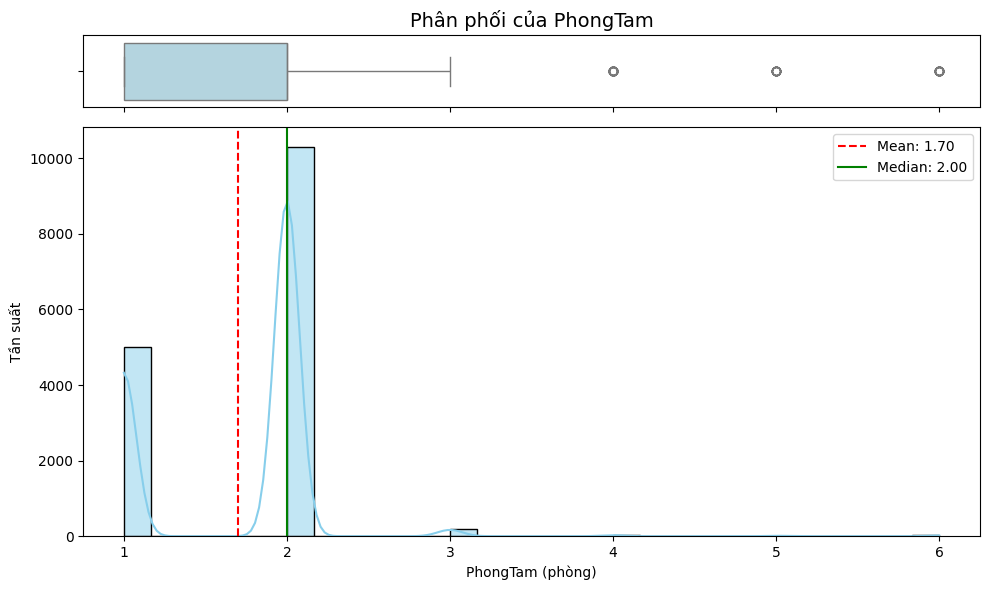

In [ ]:
analyze_numerical_feature(df, 'PhongTam', unit='phòng')

> **Remark**

* Central Tendency

  * Mode (2.00) = Median (2.00) > Mean (1.68):

    * Con số 2 thống trị tuyệt đối -> Chuẩn thiết kế căn hộ chung cư hiện đại tại Việt Nam là 2PN + 2WC.

  * Mức trung bình 1.68 (thấp hơn 2) cho thấy một tỷ trọng đáng kể của nhóm căn hộ 1WC. Đây thường là các căn 1PN, 1PN+1 hoặc Studio, và đôi khi là các căn 2PN cũ (thiết kế kiểu cũ 2PN + 1WC)

* Distribution Shape

  * Discrete & Bimodal-ish

    * Thị trường chia làm 2 phe rõ rệt: Phe 2WC (cao nhất) và Phe 1WC (cao nhì).

    * Nhóm 3WC trở lên rất thấp, gần như không đáng kể trên biểu đồ

 * Skewness = 0.699 (Lệch phải vừa phải):

    * Độ lệch không quá lớn (nhỏ hơn nhiều so với biến Giá). Điều này phản ánh cấu trúc vật lý của căn hộ có giới hạn: Dù nhà có rộng đến mấy thì số lượng toilet cũng hiếm khi tăng đột biến theo cấp số nhân như giá tiền.

  * Kurtosis = 6.03 (Leptokurtic - Cao): Dữ liệu tập trung rất mạnh vào giá trị 1 và 2.

* Outliers & Dispersion

  * Std = 0.54: Độ phân tán cực thấp. Nếu nhắm mắt chọn bừa một căn hộ, xác suất 95% nó sẽ có 1 hoặc 2 toilet. Biến số này có Information Gain (Lượng thông tin) thấp hơn so với DienTich hay Gia

  * Max = 6.00:  Với các căn Penthouse/Duplex diện tích > 150m2 (mà ta đã thấy ở phần phân tích Diện tích), việc có 4-6 toilet là hợp lý. Đây không phải lỗi dữ liệu -> Valid Outlier

-----------------------------------------------------------

> **Model implication**

* Multicollinearity: PhongTam & PhongNgu

  * PhongTam và PhongNgu thường tương quan cực mạnh (Correlation > 0.8). Căn 2PN thường có 2WC, 3PN thường có 2-3WC.

  * Nếu đưa cả 2 biến này vào mô hình Linear Regression, chúng có thể triệt tiêu ý nghĩa của nhau -> Cần kiểm tra đa cộng tuyến

* Xử lý:

  * Clipping: Tương tự PhongNgu, hãy gộp tất cả các giá trị >= 3 thành nhóm 3+. Vì số lượng mẫu 4, 5, 6 quá ít để mô hình học được quy luật riêng.
    


> **Triển khai thử đề xuất**

In [ ]:
# CLIPPING (CẮT NGỌN PHÒNG TẮM)
# Gộp tất cả các giá trị PhongTam >= 3 về thành 3
# Lý do: Nhóm 4, 5, 6 WC quá ít, gộp vào để tăng ý nghĩa thống kê cho nhóm "Nhiều WC"
df['PhongTam_Clipped'] = df['PhongTam'].clip(upper=3)

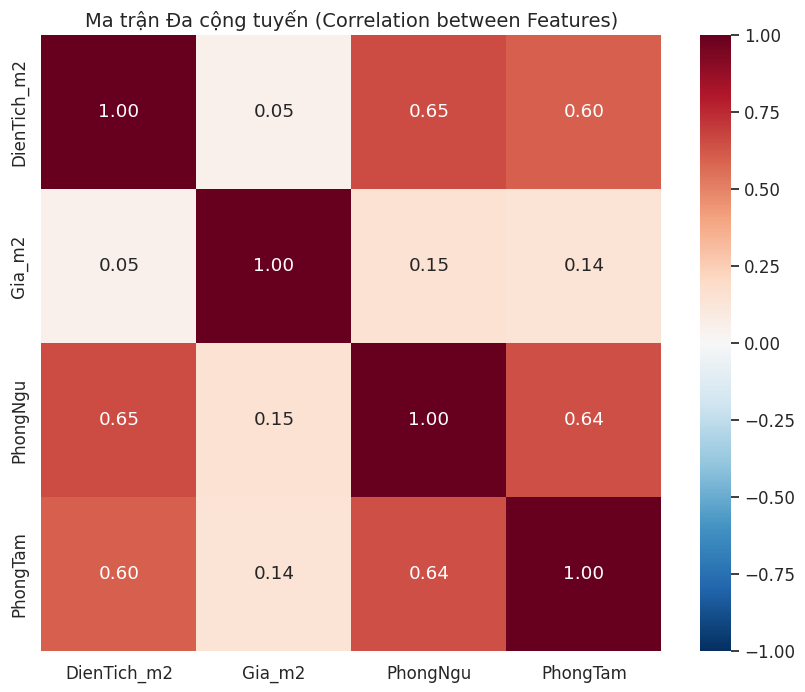


=== KẾT QUẢ VIF (VARIANCE INFLATION FACTOR) ===
Quy tắc: VIF > 5 là Cảnh báo, VIF > 10 là Nguy hiểm (Phải loại bỏ)
------------------------------------------------------------
       Feature       VIF
3     PhongNgu  2.126519
1  DienTich_m2  1.934169
4     PhongTam  1.888172
2       Gia_m2  1.034054


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 1. CHỌN CÁC BIẾN SỐ (NUMERICAL) CẦN KIỂM TRA
# Lưu ý: KHÔNG đưa biến Target (Log_Gia) vào đây.
# Chúng ta chỉ kiểm tra quan hệ giữa các biến X với nhau.
features_to_check = ['DienTich_m2',
                      'Gia_m2',
                      'PhongNgu',
                      'PhongTam']

# Lọc dữ liệu và bỏ hàng trống để tính toán
X = df[features_to_check].dropna()

# --- PHẦN 1: TRỰC QUAN HÓA HEATMAP ---
plt.figure(figsize=(10, 8))
# Tính ma trận tương quan giữa các biến X
corr_matrix = X.corr()

# Vẽ Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, fmt='.2f')
plt.title('Ma trận Đa cộng tuyến (Correlation between Features)', fontsize=14)
plt.show()

# --- PHẦN 2: TÍNH VIF (VARIANCE INFLATION FACTOR) ---
# VIF là tiêu chuẩn vàng để bắt bệnh đa cộng tuyến
# Công thức: VIF = 1 / (1 - R^2_i)

# Thêm hằng số (intercept) vào để tính VIF chính xác
X_with_const = add_constant(X)

# Tạo DataFrame chứa kết quả VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(len(X_with_const.columns))]

# Loại bỏ dòng hằng số (const) để dễ nhìn
vif_data = vif_data[vif_data["Feature"] != "const"].sort_values(by="VIF", ascending=False)

print("\n=== KẾT QUẢ VIF (VARIANCE INFLATION FACTOR) ===")
print("Quy tắc: VIF > 5 là Cảnh báo, VIF > 10 là Nguy hiểm (Phải loại bỏ)")
print("-" * 60)
print(vif_data)

> **Remark**

* Các biến đều độc lập

--- 1. CHỈ SỐ: HỆ SỐ TƯƠNG QUAN PEARSON (r) VỚI LOG(GIÁ) ---
Log_Gia_m2_trieu    0.827521
Gia_m2              0.740975
Gia_m2_trieu        0.740975
DienTich_m2         0.594747
PhongNgu            0.436110
PhongNgu_Clipped    0.429505
PhongTam            0.412398
PhongTam_Clipped    0.394840
DT_per_PN           0.088760
Name: Log_Gia, dtype: float64

--- 2. TRỰC QUAN: SCATTER PLOT (Quan hệ Tuyến tính vs. Phi tuyến) ---


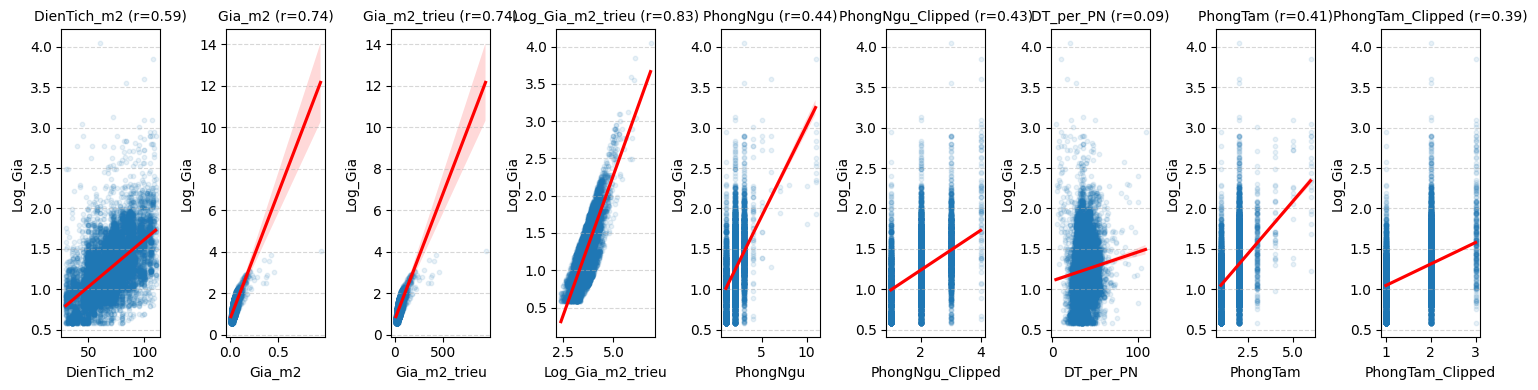

In [ ]:
# --- 1. THIẾT LẬP DỮ LIỆU ---

# Danh sách features định lượng quan trọng (Loại bỏ Gia_m2 vì Data Leakage)
core_numerical_features = ['DienTich_m2',
                           'Gia_m2', 'Gia_m2_trieu', 'Log_Gia_m2_trieu',
                           'PhongNgu', 'PhongNgu_Clipped', 'DT_per_PN',
                           'PhongTam', 'PhongTam_Clipped']

# --- 2. TÍNH CHỈ SỐ ĐÁNG TIN CẬY (PEARSON R) ---
correlations = df[core_numerical_features + ['Log_Gia']].corr()['Log_Gia'].sort_values(ascending=False)
correlations = correlations.drop('Log_Gia')

print("--- 1. CHỈ SỐ: HỆ SỐ TƯƠNG QUAN PEARSON (r) VỚI LOG(GIÁ) ---")
print(correlations)

# --- 3. TRỰC QUAN HÓA (VISUALIZATION) ---
print("\n--- 2. TRỰC QUAN: SCATTER PLOT (Quan hệ Tuyến tính vs. Phi tuyến) ---")
plt.figure(figsize=(15, 4))

for i, feature in enumerate(core_numerical_features):
    plt.subplot(1, len(core_numerical_features), i + 1)
    # Dùng regplot để vẽ Scatter Plot và đường hồi quy tuyến tính (xu hướng)
    sns.regplot(x=feature, y='Log_Gia', data=df,
                scatter_kws={'alpha':0.1, 's':10}, # Giảm độ đậm và kích thước điểm
                line_kws={'color':'red'})
    plt.title(f'{feature} (r={correlations.loc[feature]:.2f})', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

> **Remark**

*  Gia_m2, Gia_m2_trieu có tương quan dự báo bằng nhau ( khoảng 0.74) vì chỉ đổi đơn vị và nhỏ hơn Log_Gia_m2_trieu (0.83) -> Dù có tương quan cực kì mạnh với target nhưng gây Data leakage, không thể đưa vào mô hình

* DienTich_m2: Tương quan tuyến tính dương rất mạnh với target (r > 0.59)

* PhongNgu, PhongTam, PhongNgu_Clipped, PhongTam_Clipped: Nghi ngờ đa cộng tuyến

  * Tương quan mạnh với target (r > 0.44)

  * Tương quan dự báo tương đương nhau -> Giữ lại biến có tương quan cao hơn một chút (PhongNgu) và loại bỏ biến còn lại để tránh làm nhiễu hệ số trong mô hình tuyến tính.

  * PhongNgu_Clipped giảm sức mạnh dự báo do (gom các outliers ít ỏi vào nhóm lớn hơn) nhưng tăng độ tin cậy cho mô hình với những dữ liệu chưa thấy

* DT_per_PN: Thử nghiệm thất bại (tương quan thấp)

  * Có thể do biến DT_per_PN đã vô tình loại bỏ yếu tố Quy mô. Việc có nhiều diện tích trên mỗi phòng ngủ không phải là yếu tố làm tăng giá tuyến tính tổng thể, vì giá chủ yếu được quyết định bởi Tổng diện tích và Tổng số phòng. Hành động

----------------------------------------------------------

> **Tổng kết cho mô hình**

* Important Features: DienTich_m2, PhongNgu_Clipped

=== BÁO CÁO PHÂN TÍCH ANOVA (DẠNG NGANG - HORIZONTAL) ===
Feature              | F-Score    | P-value         | Kết luận
---------------------------------------------------------------------------
Phan_Khuc            | 1726.44    | < 0.001         | ⭐⭐⭐


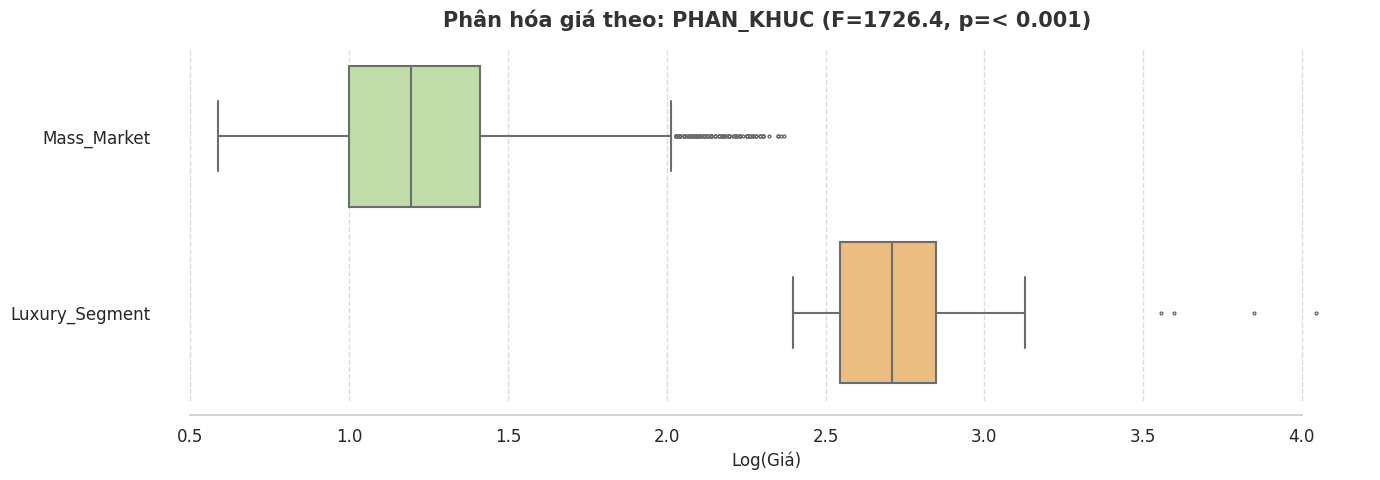



Quan                 | 211.79     | < 0.001         | ⭐⭐⭐


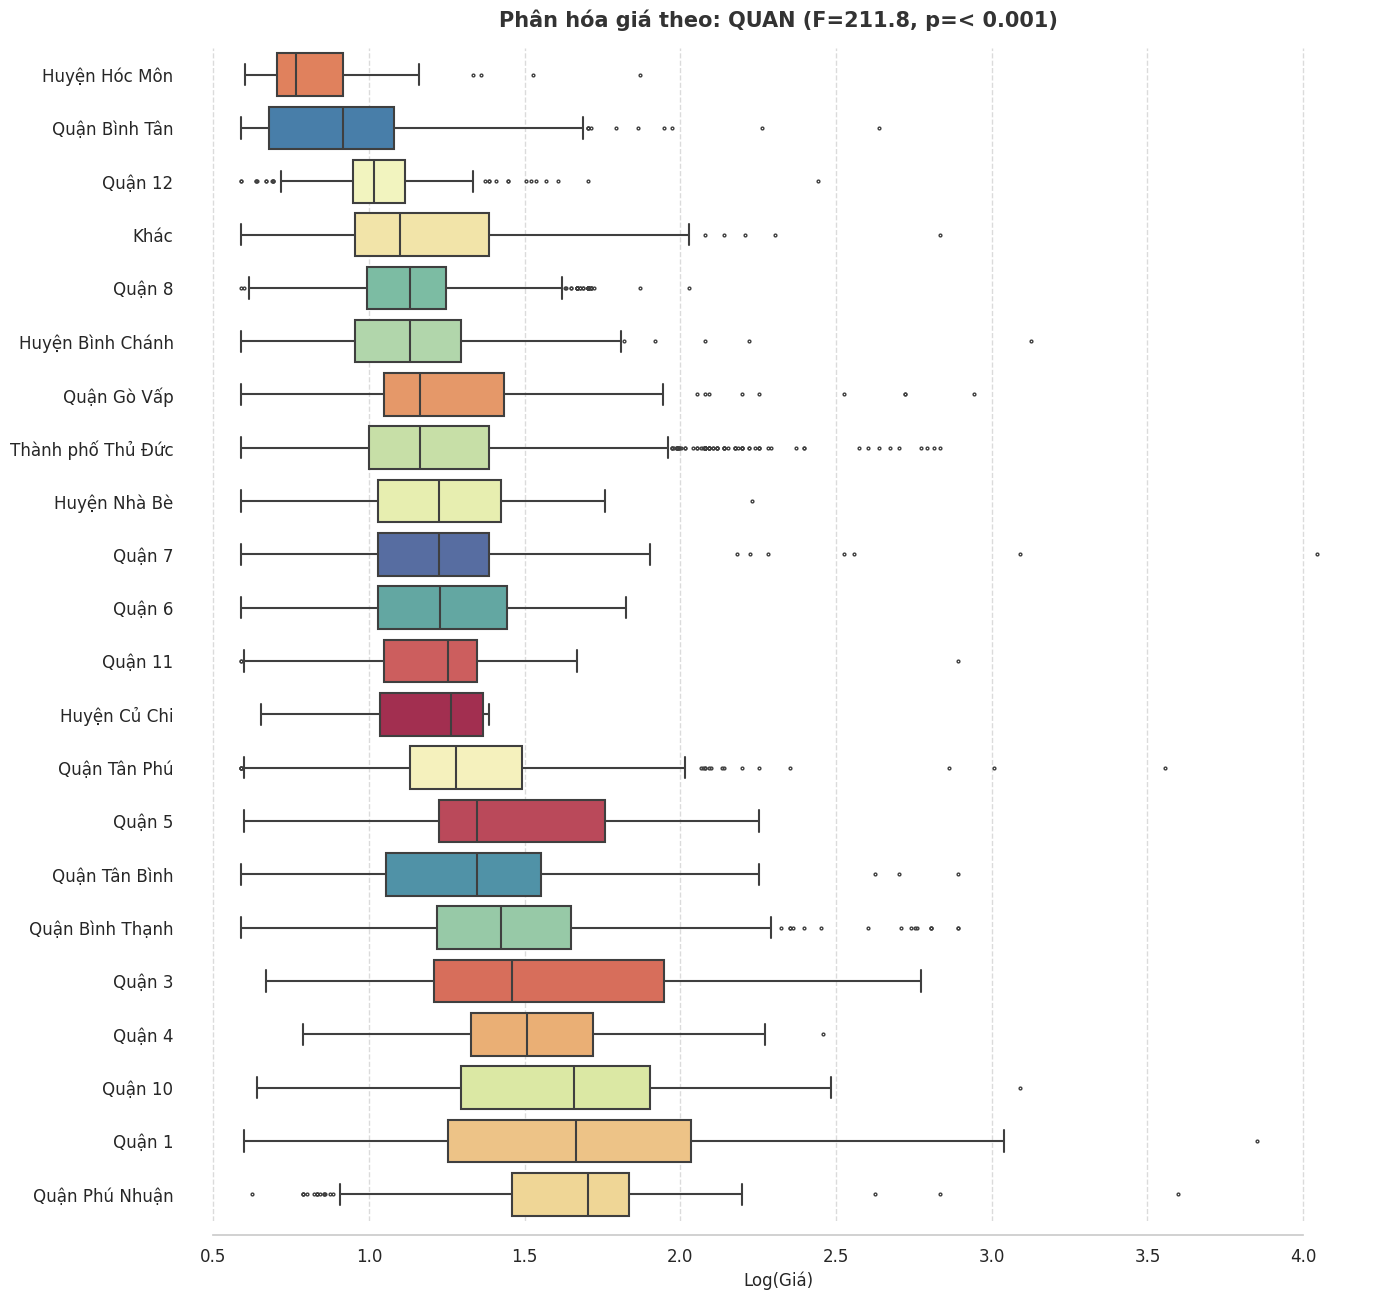



Loai                 | 49.81      | < 0.001         | ⭐⭐⭐


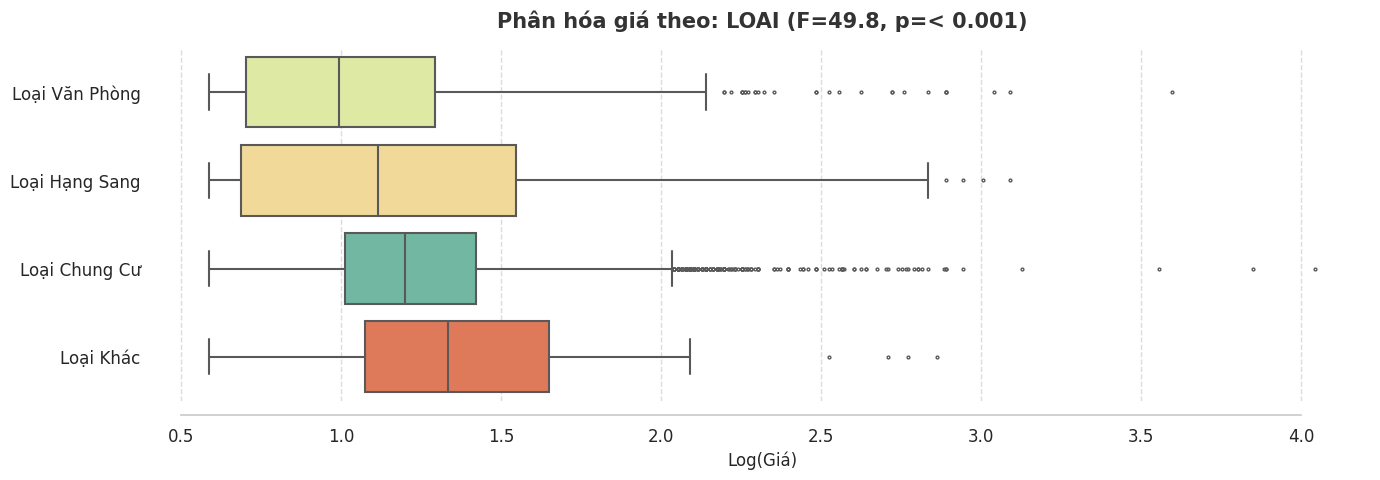



GiayTo               | 14.06      | < 0.001         | ⭐⭐⭐


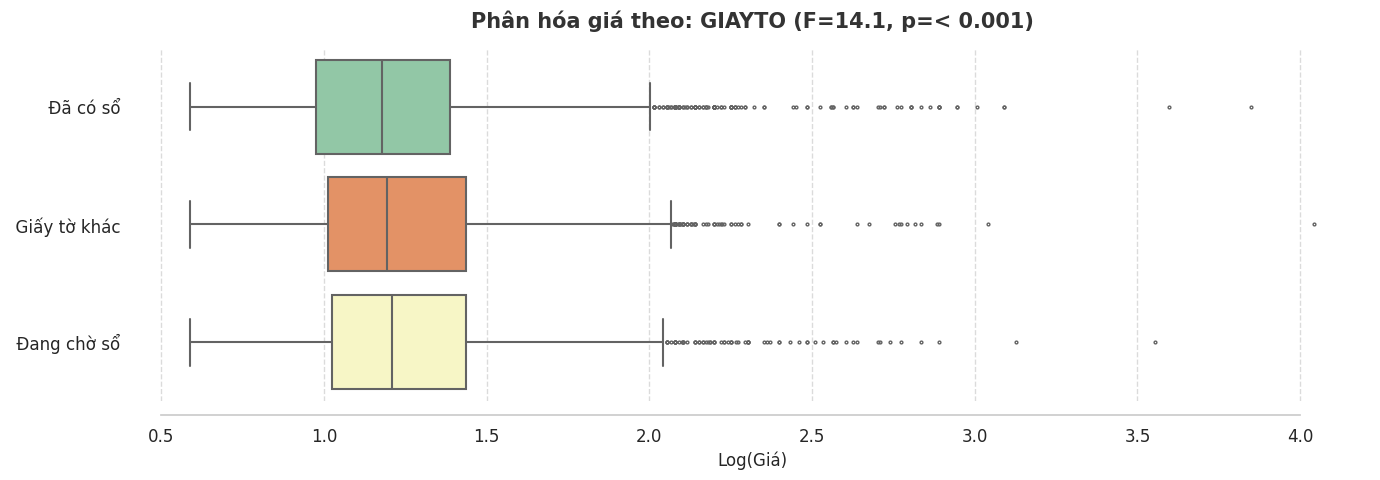



TinhTrangNoiThat     | 105.96     | < 0.001         | ⭐⭐⭐


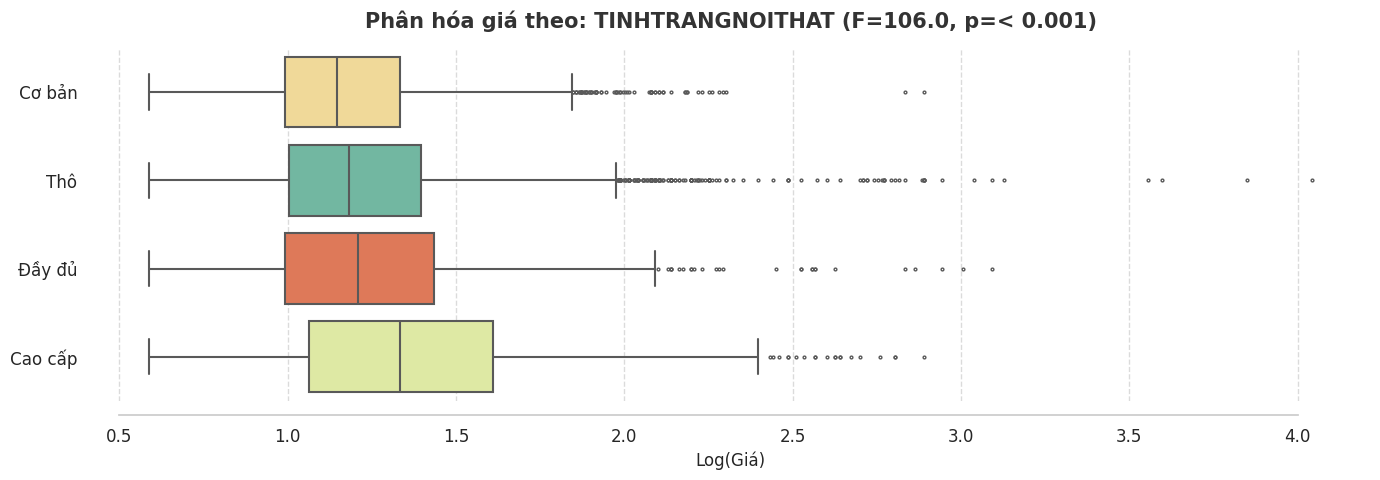



HuongCuaChinh        | 10.82      | < 0.001         | ⭐⭐⭐


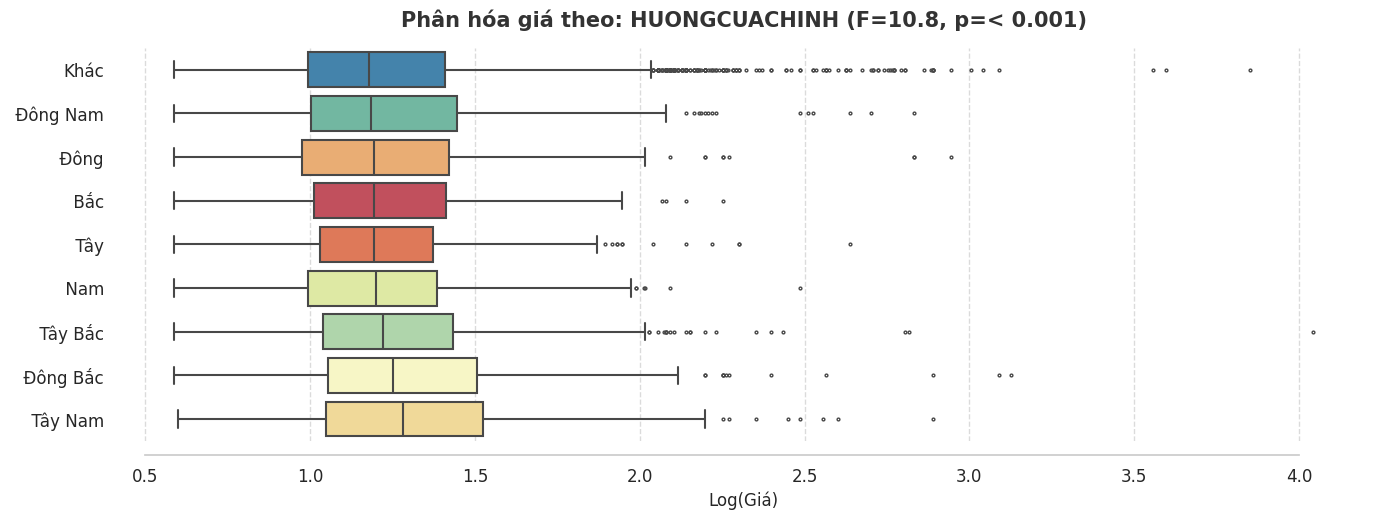



HuongBanCong         | 12.22      | < 0.001         | ⭐⭐⭐


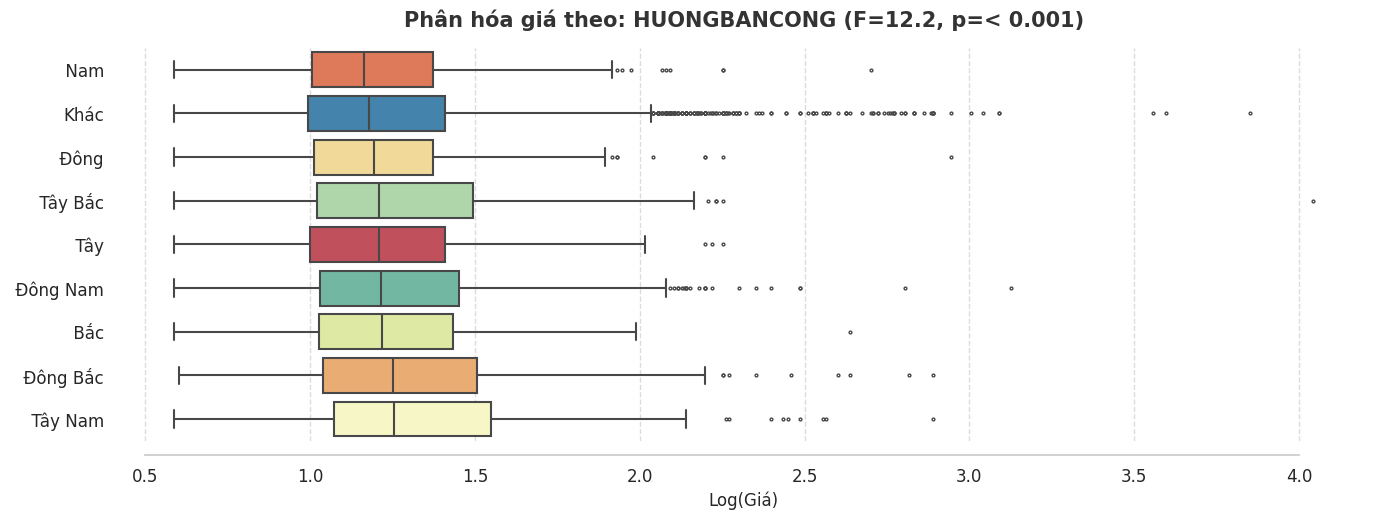



CanGoc               | 17.35      | < 0.001         | ⭐⭐⭐


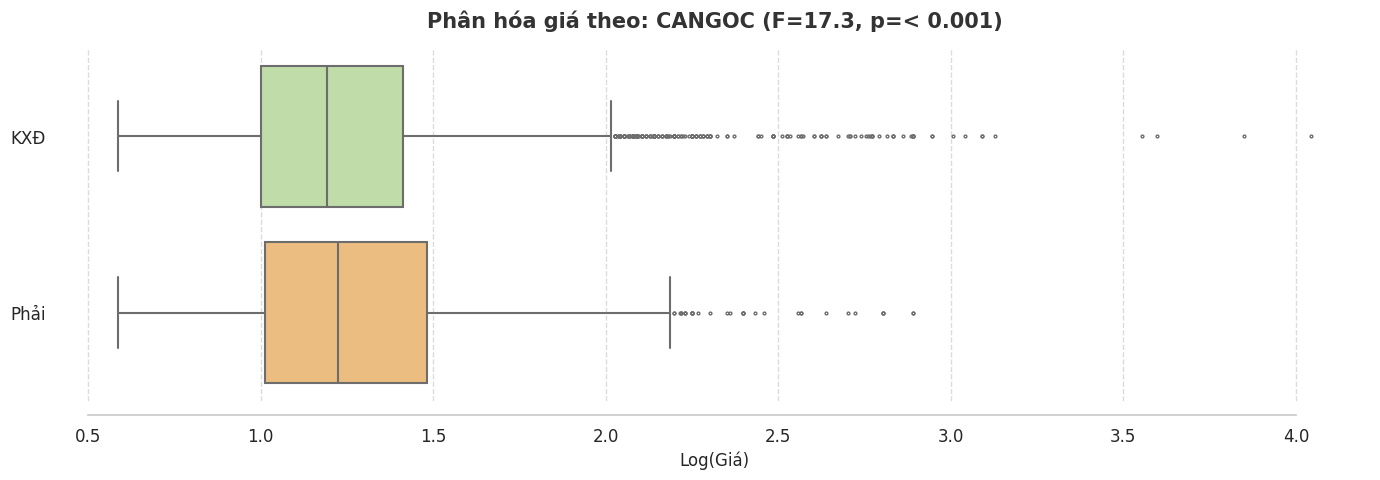



TinhTrangBDS         | 427.22     | < 0.001         | ⭐⭐⭐


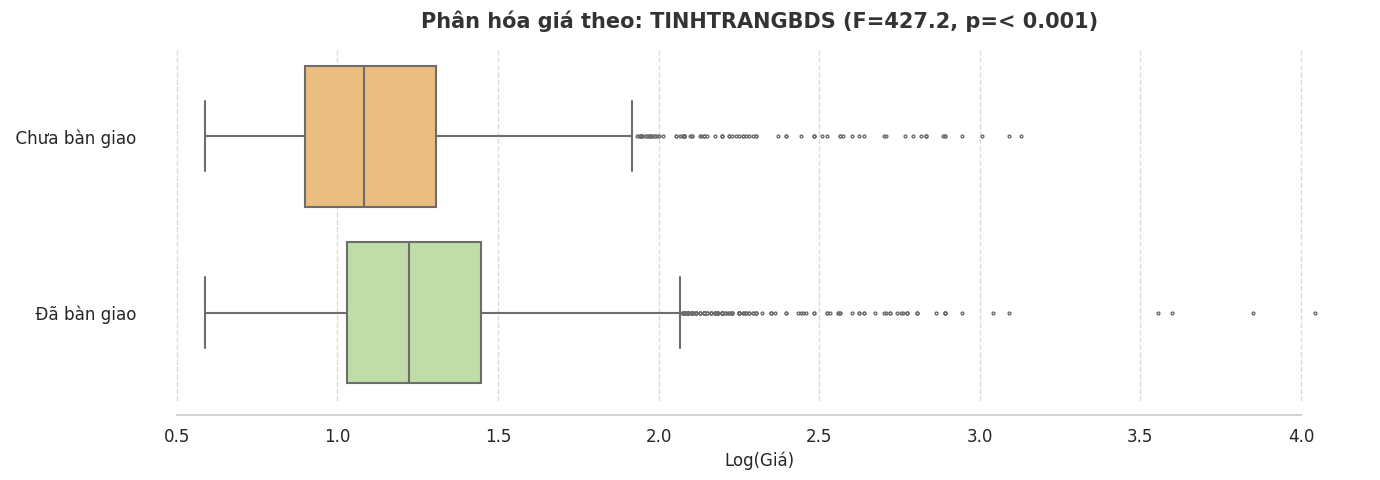

In [ ]:
import scipy.stats as stats

# --- 1. CẤU HÌNH GIAO DIỆN ---
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Danh sách biến phân loại
categorical_features = [
    'Phan_Khuc',
    'Quan',
    'Loai',
    'GiayTo',
    'TinhTrangNoiThat',
    'HuongCuaChinh',
    'HuongBanCong',
    'CanGoc',
    'TinhTrangBDS'
]

# Chuẩn bị dữ liệu sạch
if 'df_clean' not in locals():
    df_clean = df[df['Gia'] >= 0.8].copy()
    if 'Log_Gia' not in df_clean.columns:
        df_clean['Log_Gia'] = np.log1p(df_clean['Gia'])

print("=== BÁO CÁO PHÂN TÍCH ANOVA (DẠNG NGANG - HORIZONTAL) ===")
print(f"{'Feature':<20} | {'F-Score':<10} | {'P-value':<15} | {'Kết luận'}")
print("-" * 75)

# --- 2. VÒNG LẶP VẼ BIỂU ĐỒ ---
for cat_col in categorical_features:
    if cat_col not in df_clean.columns:
        continue

    data_clean = df_clean.dropna(subset=[cat_col])
    groups = [d for k, d in data_clean.groupby(cat_col)['Log_Gia']]

    if len(groups) < 2:
        continue

    # Tính toán ANOVA
    f_score, p_value = stats.f_oneway(*groups)

    p_str = "< 0.001" if p_value < 0.001 else f"{p_value:.4f}"
    star = "⭐⭐⭐" if p_value < 0.001 else ("⭐" if p_value < 0.05 else "")

    print(f"{cat_col:<20} | {f_score:<10.2f} | {p_str:<15} | {star}")

    # SẮP XẾP: Tính median để sort từ dưới lên trên (hoặc trên xuống dưới)
    order = data_clean.groupby(cat_col)['Log_Gia'].median().sort_values().index

    # --- TỰ ĐỘNG ĐIỀU CHỈNH CHIỀU CAO (DYNAMIC HEIGHT) ---
    # Nếu có nhiều nhóm (như Quận), hình phải dài ra. Nếu ít nhóm, hình ngắn lại.
    # Công thức: Mỗi nhóm tốn khoảng 0.6 inch + 2 inch lề
    dynamic_height = max(5, len(order) * 0.6)

    plt.figure(figsize=(14, dynamic_height))

    # --- VẼ BOXPLOT NGANG ---
    # Thay đổi quan trọng: x='Log_Gia', y=cat_col (Đảo trục)
    ax = sns.boxplot(y=cat_col, x='Log_Gia', data=data_clean, order=order,
                     palette='Spectral_r', hue=cat_col, legend=False,
                     linewidth=1.5, fliersize=2, orient='h') # orient='h' để chắc chắn vẽ ngang

    # Tinh chỉnh trục và tiêu đề
    plt.title(f'Phân hóa giá theo: {cat_col.upper()} (F={f_score:.1f}, p={p_str})',
              fontsize=15, fontweight='bold', color='#333333', pad=15)

    plt.xlabel('Log(Giá)', fontsize=12)
    plt.ylabel('') # Bỏ nhãn trục Y vì tên Category đã rõ ràng

    # Tinh chỉnh trục X (Giá trị Log)
    plt.grid(axis='x', linestyle='--', alpha=0.7) # Kẻ lưới dọc để dễ so sánh giá

    # Loại bỏ khung viền thừa
    sns.despine(trim=True, offset=10, left=True) # Bỏ trục dọc bên trái cho thoáng
    # ----------------------------------------------------
    # XUẤT FILE ẢNH CHẤT LƯỢNG CAO
    # 1. Đặt tên file động: boxplot_Quan.png, boxplot_Phan_Khuc.png
    filename = f"boxplot_{cat_col}_horizontal.png"

    # 2. Lệnh lưu file:
    # dpi=300 (Độ phân giải cao) | bbox_inches='tight' (Đảm bảo nhãn không bị cắt)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    # ----------------------------------------------------
    plt.tight_layout()
    plt.show()
    print("\n" + "="*80 + "\n")

> **Remark**

* The Drivers: F-Score cực cao (> 100) hoặc Tương quan rất mạnh -> Chúng quyết định 80% độ chính xác của mô hình

  * Phan_Khuc (F-Score = 1726.4):

    * Đánh giá: Chỉ số F-Score cao kỷ lục xác nhận việc phân chia thị trường thành "Mass Market" và "Luxury Segment" là hoàn toàn chính xác. Sự tách biệt về giá giữa hai nhóm này là tuyệt đối

    * Lưu ý: Không dùng làm biến đầu vào (Feature) cho một mô hình chung (vì nó được tạo từ Target), mà dùng làm tiêu chí để tách mô hình (Segmentation) -> Nên build 2 model riêng biệt: một cho nhà <10 tỷ và một cho nhà >10 tỷ.

  * TinhTrangBDS (F-Score = 427.2)

    * Đánh giá: Đây là phát hiện thú vị nhất. Trạng thái "Chưa bàn giao" và "Đã bàn giao" tạo ra sự phân hóa giá cực lớn. Dự án đã bàn giao (Completed) có giá trị trung vị cao hơn và ổn định hơn. Dự án chưa bàn giao có rủi ro cao hơn nên giá thấp hơn hoặc biến động mạnh hơn.

  * Quan (F-Score = 211.8)

    * Đánh giá: Biến định vị không gian quan trọng nhất. Biểu đồ Boxplot cho thấy hiệu ứng "bậc thang" hoàn hảo: Từ vùng ven (Hóc Môn, Bình Tân) leo dần lên trung tâm (Quận 1, Phú Nhuận). Đây là xương sống của mô hình định giá

  * TinhTrangNoiThat (F-Score = 106.0)

    * Đánh giá: Sự khác biệt giữa "Nội thất Cơ bản" và "Cao cấp" là rất rõ ràng. Thị trường sẵn sàng trả thêm tiền (premium) cho sự tiện nghi sẵn có.
  
* The Supporters:

  * Loai (F-Score = 49.8):

    * Đánh giá: Phân biệt tốt giữa "Chung cư" thông thường và "Hạng sang/Văn phòng". Tuy nhiên, do nhóm Chung cư chiếm đa số áp đảo nên sức mạnh tổng thể thấp hơn Quận.
  
  * CanGoc (F-Score = 17.3):

    * Đánh giá: Căn góc thường đắt hơn căn thường nhờ view và độ thoáng. F-Score mức 17 là đủ tốt để giữ lại, giúp model thưởng thêm giá cho các căn này.
  
  * GiayTo (F-Score = 14.1):

    * Đánh giá: Pháp lý có ảnh hưởng nhưng không quá lớn như kỳ vọng (có thể do phần lớn là Sổ hồng/HĐMB - độ an toàn tương đương nhau trong mắt người mua chung cư hiện tại)
  
* The Noise

  * HuongBanCong (F = 12.2) & HuongCuaChinh (F = 10.8)

    * Đánh giá: Biểu đồ Boxplot cho thấy các hộp nằm khá ngang bằng nhau. Người mua nhà có quan tâm phong thủy, nhưng ở góc độ dữ liệu lớn, giá của Hướng Đông và Hướng Tây không chênh lệch đủ nhiều để tạo ra quy luật thống kê mạnh. -> Có thể cân nhắc loại bỏ nếu muốn đơn giản hóa mô hình (Feature Pruning)

## **IMPORTANT FEATURES**
1. DienTich_m2 (Numerical): Quy mô căn hộ.

2. Quan (Categorical): Vị trí địa lý (Yếu tố sống còn).

3. TinhTrangBDS (Categorical): Mới hay cũ, rủi ro hay an toàn.

4. TinhTrangNoiThat (Categorical): Mức độ hoàn thiện.

5. PhongNgu_Clipped (Numerical): Công năng sử dụng.

6. Loai (Categorical): Phân loại sản phẩm.

7. CanGoc (Categorical): Yếu tố vị trí trong tòa nhà.

8. GiayTo (Categorical): Rủi ro pháp lý

------------------------------------------------------
> **Chiến lược gợi ý**

* Sử dụng Phan_Khuc để chia dữ liệu thành 2 tập train riêng biệt (nếu có đủ dữ liệu), không dùng làm feature.

* Biến mục tiêu (Target) bắt buộc phải là Log_Gia

> **Kiểm chứng: Dữ liệu 'KXĐ' ở CanGoc có phải là missing values không ?**

  * Trong một mặt sàn chung cư điển hình (Layout), thường có từ 8 đến 20 căn hộ.

  * Số lượng căn góc luôn cố định là 4 căn (ở 4 góc tòa nhà)

  * Tỷ lệ căn góc thực tế = 4/ Tổng số căn, thường dao động từ 15 - 25%. Khớp với tỷ lệ 'Phải' (22.12%)

 * **Kết luận:**  Chấp nhận giả định rằng giá trị "KXĐ" ở đây thực chất là "Không" (False)

=== KIỂM CHỨNG BẢN CHẤT MISSING VALUES (KXĐ) ===
1. TỶ LỆ PHÂN BỐ:
CanGoc
KXĐ     78.910211
Phải    21.089789
Name: proportion, dtype: float64
-> Nhóm KXĐ chiếm 78.91%
   (Chuẩn thị trường: Căn thường chiếm 75-85%. Nếu khớp -> Tín hiệu tốt số 1)

2. SO SÁNH GIÁ TRỊ:
   - Median Log(Gia) [Phải]: 1.22
   - Median Log(Gia) [KXĐ] : 1.19
   - Chênh lệch (Premium)  : +4.8%
   - P-value (One-sided)   : 0.00003

KẾT LUẬN: XÁC NHẬN!
   1. Nhóm 'Phải' có giá cao hơn hẳn nhóm 'KXĐ' (Có ý nghĩa thống kê).
   2. Tỷ lệ phân bố hợp lý.
   -> 'KXĐ' chính xác là 'Căn thường' (Không phải góc).
   -> Missing Values ở đây mang ý nghĩa là 'Không'.


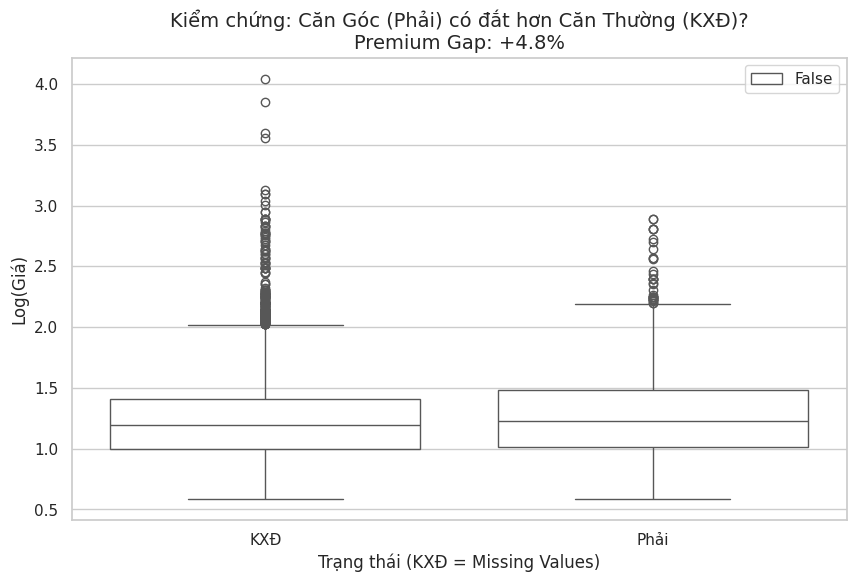

In [ ]:
from scipy import stats

# --- 1. CHUẨN BỊ DỮ LIỆU ---
sns.set_theme(style="whitegrid")
# Lấy df gốc đã điền 'KXĐ' vào chỗ missing
df_check = df.copy()
# Lọc rác giá thấp để công bằng
df_check = df_check[df_check['Gia'] >= 0.8]
df_check['Log_Gia'] = np.log1p(df_check['Gia'])

print("=== KIỂM CHỨNG BẢN CHẤT MISSING VALUES (KXĐ) ===")

# --- 2. KIỂM TRA TỶ LỆ (RATIO CHECK) ---
counts = df_check['CanGoc'].value_counts(normalize=True) * 100
print("1. TỶ LỆ PHÂN BỐ:")
print(counts)
print(f"-> Nhóm KXĐ chiếm {counts.get('KXĐ', 0):.2f}%")
print("   (Chuẩn thị trường: Căn thường chiếm 75-85%. Nếu khớp -> Tín hiệu tốt số 1)")

# --- 3. KIỂM TRA GIÁ (PRICE PREMIUM CHECK) ---
# Lấy dữ liệu 2 nhóm
group_phai = df_check[df_check['CanGoc'] == 'Phải']['Log_Gia']
group_kxd = df_check[df_check['CanGoc'] == 'KXĐ']['Log_Gia']

# Tính chênh lệch Median
gap = group_phai.median() - group_kxd.median()
# Chuyển về % giá trị thực để dễ hình dung (xấp xỉ)
gap_percent = (np.expm1(group_phai.median()) - np.expm1(group_kxd.median())) / np.expm1(group_kxd.median()) * 100

print("\n2. SO SÁNH GIÁ TRỊ:")
print(f"   - Median Log(Gia) [Phải]: {group_phai.median():.2f}")
print(f"   - Median Log(Gia) [KXĐ] : {group_kxd.median():.2f}")
print(f"   - Chênh lệch (Premium)  : +{gap_percent:.1f}%")

# Kiểm định T-test (H0: Giá Phải = Giá KXĐ)
# Chúng ta kỳ vọng p-value cực nhỏ để BÁC BỎ H0
t_stat, p_val = stats.ttest_ind(group_phai, group_kxd, equal_var=False, alternative='greater')

print(f"   - P-value (One-sided)   : {p_val:.5f}")

if p_val < 0.05 and gap > 0:
    print("\nKẾT LUẬN: XÁC NHẬN!")
    print("   1. Nhóm 'Phải' có giá cao hơn hẳn nhóm 'KXĐ' (Có ý nghĩa thống kê).")
    print("   2. Tỷ lệ phân bố hợp lý.")
    print("   -> 'KXĐ' chính xác là 'Căn thường' (Không phải góc).")
    print("   -> Missing Values ở đây mang ý nghĩa là 'Không'.")
else:
    print("\n KẾT LUẬN: NGHI NGỜ.")
    print("   Không thấy sự chênh lệch giá rõ ràng. Có thể dữ liệu KXĐ bị lẫn lộn.")

# --- 4. TRỰC QUAN HÓA ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='CanGoc', y='Log_Gia', data=df_check,
            order=['KXĐ', 'Phải'],
            palette={'KXĐ': '#95a5a6', 'Phải': '#e74c3c'}, hue = False)

plt.title(f'Kiểm chứng: Căn Góc (Phải) có đắt hơn Căn Thường (KXĐ)?\nPremium Gap: +{gap_percent:.1f}%', fontsize=14)
plt.xlabel('Trạng thái (KXĐ = Missing Values)')
plt.ylabel('Log(Giá)')
plt.show()

> **Hypothesis Testing: Giá bất động sản hướng Đông Nam sẽ có mức chênh lệch giá (premium) cao hơn so với các hướng còn lại**

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# --- 1. CHUẨN BỊ DỮ LIỆU ---
df_check = df.copy()

# BƯỚC DEBUG QUAN TRỌNG: In ra các giá trị thực tế để không bao giờ sai nữa
print("Các giá trị Hướng thực tế trong dữ liệu:")
print(df_check['HuongBanCong'].unique())
print("-" * 50)

# --- 2. ĐỊNH NGHĨA LẠI HÀM PHÂN NHÓM (DÙNG TÊN ĐẦY ĐỦ) ---
def group_direction(direction):
    # Chuẩn hóa chuỗi: Xóa khoảng trắng thừa (nếu có)
    d = str(direction).strip()

    # Nhóm Premium (Mát): Đông, Nam, Đông Nam
    if d in ['Đông Nam', 'Đông', 'Nam']:
        return 'DongNam_Premium'

    # Nhóm Baseline (Nắng): Tây, Tây Bắc, Tây Nam, Bắc (Bắc đôi khi lạnh/nắng tùy mùa, xếp tạm vào đây hoặc tách riêng)
    elif d in ['Tây', 'Tây Bắc', 'Bắc', 'Tây Nam']:
        return 'TayBac_Baseline'

    return 'Other'

# Tạo cột nhóm mới
df_check['Huong_Group'] = df_check['HuongBanCong'].apply(group_direction)

# --- 3. CHẠY LẠI KIỂM ĐỊNH ---
group_premium = df_check[df_check['Huong_Group'] == 'DongNam_Premium']['Log_Gia'].dropna()
group_baseline = df_check[df_check['Huong_Group'] == 'TayBac_Baseline']['Log_Gia'].dropna()

print(f"Số lượng mẫu Đông Nam (Mát): n={len(group_premium)}")
print(f"Số lượng mẫu Tây/Bắc (Nắng): n={len(group_baseline)}")

if len(group_premium) > 0 and len(group_baseline) > 0:
    # T-test một phía (Greater)
    t_stat, p_val = stats.ttest_ind(group_premium, group_baseline, equal_var=False, alternative='greater')

    print("\n=== KẾT QUẢ KIỂM ĐỊNH GIẢ THUYẾT ===")
    print(f"Trung bình giá (Log) nhóm Mát : {group_premium.mean():.4f}")
    print(f"Trung bình giá (Log) nhóm Nắng: {group_baseline.mean():.4f}")
    print(f"P-value: {p_val:.5f}")

    if p_val < 0.05:
        print("KẾT LUẬN: Bác bỏ H0. Hướng Đông Nam/Mát có giá cao hơn thật sự (Premium confirmed).")
    else:
        print("KẾT LUẬN: Không đủ bằng chứng. Thị trường không định giá cao hơn cho hướng mát.")

Các giá trị Hướng thực tế trong dữ liệu:
['Khác' ' Đông Nam' ' Tây Bắc' ' Bắc' ' Tây Nam' ' Đông' ' Đông Bắc'
 ' Nam' ' Tây']
--------------------------------------------------
Số lượng mẫu Đông Nam (Mát): n=2441
Số lượng mẫu Tây/Bắc (Nắng): n=2031

=== KẾT QUẢ KIỂM ĐỊNH GIẢ THUYẾT ===
Trung bình giá (Log) nhóm Mát : 1.2376
Trung bình giá (Log) nhóm Nắng: 1.2641
P-value: 0.99706
KẾT LUẬN: Không đủ bằng chứng. Thị trường không định giá cao hơn cho hướng mát.


# Testing

In [ ]:
# ==========================================
# VÍ DỤ SỬ DỤNG (Main Code)
# ==========================================
if __name__ == "__main__":
    # 1. Tạo dữ liệu giả lập để test
    dummy_data = {
        'age': [25, 30, np.nan, 35, 100], # Có NaN và Outlier (100)
        'salary': [50000, 60000, 55000, 58000, 1500000], # Outlier lớn
        'city': ['Hanoi', 'HCMC', 'Danang', None, 'Hanoi'], # Text và NaN
        'joined_date': ['2023-01-01', '2023-02-15', '2023-03-20', '2023-01-05', '2023-12-12'],
        'rank': ['Junior', 'Senior', 'Fresher', 'Senior', 'Junior']
    }
    df_raw = pd.DataFrame(dummy_data)
    df_raw.to_csv('dummy_data.csv', index=False)

    # 2. Khởi tạo đối tượng
    processor = DataPreprocessor()
    print(processor) # Test __repr__

    # 3. Đọc dữ liệu
    processor.read_data('dummy_data.csv')

    # 4. Sử dụng Method Chaining (Chuỗi các hành động)
    # Đây là phong cách OOP hiện đại giúp code gọn gàng
    (
        processor
        .process_datetime('joined_date') # Xử lý ngày giờ trước
        .handle_missing_values(strategy='mean', columns=['age']) # Điền tuổi thiếu
        .handle_missing_values(strategy='mode', columns=['city']) # Điền TP thiếu
        .custom_text_mapping('rank', {'Fresher': 1, 'Junior': 2, 'Senior': 3}) # Map rank sang số
        .handle_outliers(columns=['salary'], method='iqr') # Lọc lương ảo
        .normalize_data(columns=['age', 'salary'], method='minmax') # Chuẩn hóa
        .encode_categorical(columns=['city'], method='onehot') # OneHot TP
    )

    # 5. Kiểm tra tiện ích Static
    mem = DataPreprocessor.check_memory_usage(processor.get_data())
    print(f"Bộ nhớ sử dụng: {mem}")

    # 6. Xuất dữ liệu
    result = processor.get_data()
    print("\n--- Dữ liệu sau khi xử lý ---")
    print(result.head())

<DataPreprocessor: Empty>
[OK] Đã đọc dữ liệu thành công từ dummy_data.csv
[OK] Đã xử lý đặc trưng thời gian cho cột joined_date
[OK] Đã thực hiện xử lý missing values. Chi tiết:
    - Cột 'age': Đã điền missing values bằng giá trị trung bình (47.50).
[OK] Đã thực hiện xử lý missing values. Chi tiết:
    - Cột 'city': Đã điền missing values bằng mode (Hanoi).
[OK] Đã map dữ liệu cột rank theo quy tắc riêng.
[OK] Loại bỏ ngoại lai cột 'salary' theo iqr                         ([47500.00, 67500.00] (IQR)). Đã xóa 1 dòng.
[INFO] Tổng số dòng đã bị xóa do ngoại lai:                     1.
[OK] Đã chuẩn hóa ['age', 'salary'] bằng minmax
[OK] Đã mã hóa ['city'] bằng onehot
Bộ nhớ sử dụng: 0.00 MB

--- Dữ liệu sau khi xử lý ---
        age  salary joined_date  rank  joined_date_year  joined_date_month  \
0  0.000000     0.0  2023-01-01     2              2023                  1   
1  0.222222     1.0  2023-02-15     3              2023                  2   
2  1.000000     0.5  2023-03-20    

In [ ]:
if __name__ == "__main__":
    # 1. Giả lập dữ liệu Bất động sản lộn xộn
    raw_data = {
        'dien_tich': ['80m2', '100.5 m2', '60,5', '', 'N/A'],
        'gia_m2': ['50 triệu', '50,5 tr/m2', '2 tỷ/m2', '25000 nghìn/m2', None],
        'quan': ['Q1', 'Q2', 'Q1', 'Q3', 'Q2']
    }
    df = pd.DataFrame(raw_data)

    # 2. Khởi tạo Processor từ DataFrame
    processor = DataPreprocessor.from_dataframe(df)

    # 3. Áp dụng quy trình làm sạch
    (
        processor
        .clean_area_feature('dien_tich')  # Bước 1: Làm sạch diện tích
        .clean_price_feature('gia_m2')    # Bước 2: Làm sạch giá
        .handle_missing_values(strategy='mean', columns=['dien_tich', 'gia_m2']) # Bước 3: Điền các ô lỗi bằng Mean
    )

    # 4. Xem kết quả
    print("\n--- KẾT QUẢ SAU KHI LÀM SẠCH ---")
    print(processor.get_data())

[Factory] Đã khởi tạo từ DataFrame có sẵn.
[OK] Đã làm sạch và trích xuất số liệu cột diện tích: 'dien_tich'
[OK] Đã làm sạch và chuẩn hóa cột giá: 'gia_m2'
[OK] Đã thực hiện xử lý missing values. Chi tiết:
    - Cột 'dien_tich': Đã điền missing values bằng giá trị trung bình (80.33).
    - Cột 'gia_m2': Đã điền missing values bằng giá trị trung bình (531.38).

--- KẾT QUẢ SAU KHI LÀM SẠCH ---
    dien_tich    gia_m2 quan
0   80.000000    50.000   Q1
1  100.500000    50.500   Q2
2   60.500000  2000.000   Q1
3   80.333333    25.000   Q3
4   80.333333   531.375   Q2


# ModelTrainer

In [ ]:
import os
import json
from typing import Dict, Any, List, Tuple, Optional

import joblib
import numpy as np
import pandas as pd
import logging

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from .utils import set_seed

class ModelTrainer:
    """
    Lớp chịu trách nhiệm toàn bộ quy trình mô hình học máy (Regression):

    1. Nạp dữ liệu đã chuẩn hóa (load_data).
    2. Chia train/test (split_data).
    3. Huấn luyện và tối ưu tham số cho nhiều mô hình (train_model + optimize_params).
    4. Đánh giá mô hình, ghi lại kết quả (evaluate).
    5. Lưu & load mô hình bằng joblib (save_model, load_model).
    6. So sánh kết quả giữa các mô hình và vẽ/lưu biểu đồ (barplot) trong pipeline.

    Class này thiết kế cho bài toán Regression (RMSE, MAE, R2).
    """

    def __init__(
        self,
        config: Dict[str, Any],
        logger: Optional[logging.Logger] = None,
    ) -> None:
        """
        Parameters
        ----------
        config : dict
            Cấu hình đọc từ config.yaml/config.ini, ví dụ:

            data:
              processed_path: "data/processed/df_model_ready.csv"
              target_col: "price"
              test_size: 0.2
              random_seed: 42

            paths:
              models_dir: "models/saved_models"
              metrics_dir: "models/metrics"
              figures_dir: "reports/figures"

        logger : logging.Logger, optional
            Logger dùng để ghi log. Nếu None thì dùng logging.getLogger().
        """
        self.config = config

        # ==== Đọc config ====
        data_cfg = config.get("data", {})
        paths_cfg = config.get("paths", {})

        self.data_path: str = data_cfg.get(
            "processed_path", "data/processed/df_model_ready.csv"
        )
        self.target_col: str = data_cfg.get("target_col", "target")
        self.test_size: float = float(data_cfg.get("test_size", 0.2))
        self.random_seed: int = int(data_cfg.get("random_seed", 42))

        self.models_dir: str = paths_cfg.get("models_dir", "models/saved_models")
        self.metrics_dir: str = paths_cfg.get("metrics_dir", "models/metrics")
        self.figures_dir: str = paths_cfg.get("figures_dir", "reports/figures")

        os.makedirs(self.models_dir, exist_ok=True)
        os.makedirs(self.metrics_dir, exist_ok=True)
        os.makedirs(self.figures_dir, exist_ok=True)

        self.logger = logger or logging.getLogger("ModelTrainerLogger")

        # ==== Biến dữ liệu ====
        self.df: Optional[pd.DataFrame] = None
        self.X_train: Optional[pd.DataFrame] = None
        self.X_test: Optional[pd.DataFrame] = None
        self.y_train: Optional[pd.Series] = None
        self.y_test: Optional[pd.Series] = None

        # ==== Mô hình & kết quả ====
        # mapping: model_name -> (estimator, param_dist)
        self.models_and_params: Dict[str, Tuple[Any, Dict[str, List[Any]]]] = {}
        # model_name -> best_estimator
        self.best_models: Dict[str, Any] = {}
        # list metrics cho từng model
        self.results: List[Dict[str, Any]] = []

        # Reproducibility
        set_seed(self.random_seed)

        # Khởi tạo 3 mô hình mặc định
        self._init_default_models()

        self.logger.info("===== ModelTrainer khởi tạo thành công =====")

    # ========= PROPERTIES / STATICMETHODS ==================================

    @property
    def best_model_name(self) -> Optional[str]:
        """
        Trả về tên mô hình tốt nhất (theo RMSE nhỏ nhất) sau khi train.
        """
        if not self.results:
            return None
        results_df = pd.DataFrame(self.results)

        # [FIX] Kiểm tra tên cột RMSE (có thể là RMSE_Test hoặc RMSE)
        if "RMSE_Test" in results_df.columns:
            best_row = results_df.sort_values(by="RMSE_Test").iloc[0]
        elif "RMSE" in results_df.columns:
            best_row = results_df.sort_values(by="RMSE").iloc[0]
        else:
            return None

        return str(best_row["model"])

    @staticmethod
    def _ensure_file_exists(path: str) -> None:
        """
        Hàm tiện ích kiểm tra file tồn tại.
        """
        if not os.path.exists(path):
            raise FileNotFoundError(f"File không tồn tại: {path}")

    # ========= KHỞI TẠO MÔI TRƯỜNG ===========================================

    def _init_default_models(self) -> None:
        """
        Khởi tạo các mô hình với bộ tham số CHỐNG OVERFITTING mạnh hơn.
        """
        # 1. Random Forest: Tăng min_samples_leaf để cành cây không quá nhỏ
        rf = RandomForestRegressor(random_state=self.random_seed, n_jobs=-1)
        rf_param_dist = {
            "n_estimators": [200, 300, 500],
            "max_depth": [10, 15, 20],        # Giảm độ sâu (trước là 30)
            "min_samples_split": [5, 10, 15], # Tăng lên để tránh chia nhỏ quá
            "min_samples_leaf": [4, 8, 12],   # Quan trọng: Lá phải có ít nhất 4-12 mẫu
            "max_features": ["sqrt", "log2"]  # Chỉ xem xét 1 phần features mỗi lần
        }

        # 2. XGBoost: Thêm Regularization (L1/L2) để phạt mô hình phức tạp
        xgb_model = xgb.XGBRegressor(
            objective="reg:squarederror",
            random_state=self.random_seed,
            n_jobs=-1,
        )
        xgb_param_dist = {
            "n_estimators": [500, 1000, 1500],
            "max_depth": [3, 5, 6],           # Giữ cây nông (Shallow trees)
            "learning_rate": [0.01, 0.02],    # Học cực chậm
            "subsample": [0.6, 0.7],          # Chỉ học 60-70% dữ liệu mỗi cây
            "colsample_bytree": [0.6, 0.7],   # Chỉ học 60-70% cột mỗi cây
            "reg_alpha": [0.1, 1.0, 10.0],    # L1 Regularization (Chống nhiễu)
            "reg_lambda": [0.1, 1.0, 10.0]    # L2 Regularization (Chống nhiễu)
        }

        # 3. SVR (Giữ nguyên hoặc bỏ qua nếu chạy lâu)
        svr_model = SVR(kernel="linear")
        svr_param_dist = {
            "C": [0.01, 0.1, 1],
            "epsilon": [0.01, 0.1],
        }

        self.models_and_params = {
            "RandomForest": (rf, rf_param_dist),
            "XGBoost": (xgb_model, xgb_param_dist),
            "SVR": (svr_model, svr_param_dist),
        }

    # ========= CORE METHODS ================================================

    def load_data(self) -> None:
        """
        Nạp dữ liệu đã chuẩn hóa từ file CSV (đã numeric, sẵn sàng train).
        """
        self._ensure_file_exists(self.data_path)
        self.df = pd.read_csv(self.data_path)

        if self.target_col not in self.df.columns:
            raise ValueError(
                f"target_col='{self.target_col}' không tồn tại trong dữ liệu."
            )

        self.logger.info(f"Đã load data từ {self.data_path} với shape {self.df.shape}")

    def split_data(self) -> None:
        """
        Chia dữ liệu thành train/test bằng train_test_split.
        """
        if self.df is None:
            raise RuntimeError("Data chưa được load. Hãy gọi load_data() trước.")

        X = self.df.drop(columns=[self.target_col]).copy()
        y = self.df[self.target_col].copy()

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X,
            y,
            test_size=self.test_size,
            random_state=self.random_seed,
        )

        self.logger.info(
            f"Đã chia train/test: "
            f"Train={self.X_train.shape}, Test={self.X_test.shape}"
        )

    def optimize_params(
        self, model_name: str, model: Any, param_dist: Dict[str, List[Any]]
    ) -> Tuple[Any, Dict[str, Any]]:
        """
        Tối ưu siêu tham số cho một mô hình bằng RandomizedSearchCV.
        """
        if self.X_train is None or self.y_train is None:
            raise RuntimeError("Dữ liệu train chưa được chuẩn bị. Hãy gọi split_data().")

        self.logger.info("=" * 60)
        self.logger.info(f"Tối ưu siêu tham số cho model: {model_name}")

        # [FIX] Đọc tham số từ Config (để không bị hardcode n_iter=4)
        training_cfg = self.config.get("training", {})
        n_iter = int(training_cfg.get("n_iter", 20))
        cv = int(training_cfg.get("cv", 3))

        self.logger.info(f"-> Chạy Search với n_iter={n_iter}, cv={cv}")

        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=n_iter, # Sử dụng biến n_iter từ config
            cv=cv,         # Sử dụng biến cv từ config
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
            random_state=self.random_seed,
            verbose=1,
        )

        search.fit(self.X_train, self.y_train)

        best_model = search.best_estimator_
        best_params = search.best_params_

        self.logger.info(f"Best params cho {model_name}: {best_params}")

        return best_model, best_params

    def evaluate(self, model_name: str, model: Any) -> Dict[str, Any]:
        """
        Đánh giá model trên tập test theo các metric Regression:
        MAE, MSE, RMSE, R2.
        """
        if self.X_test is None or self.y_test is None:
            raise RuntimeError(
                "Dữ liệu test chưa được chuẩn bị. Hãy gọi split_data() trước."
            )

        # 1. Đánh giá trên tập TEST
        y_pred = model.predict(self.X_test)
        mae = mean_absolute_error(self.y_test, y_pred)
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = float(np.sqrt(mse))
        r2 = r2_score(self.y_test, y_pred)

        # 2. Đánh giá trên tập TRAIN (để kiểm tra Overfitting)
        y_pred_train = model.predict(self.X_train)
        rmse_train = float(np.sqrt(mean_squared_error(self.y_train, y_pred_train)))
        r2_train = r2_score(self.y_train, y_pred_train)

        self.logger.info(
            f"[{model_name}] TRAIN: R2={r2_train:.4f}, RMSE={rmse_train:.4f} | "
            f"TEST: R2={r2:.4f}, RMSE={rmse:.4f}"
        )

        if r2_train - r2 > 0.15:
            self.logger.warning(f"-> Cảnh báo: [{model_name}] có dấu hiệu Overfitting!")

        metrics_dict = {
            "model": model_name,
            "MAE_Test": float(mae),
            "MSE_Test": float(mse),
            "RMSE_Test": float(rmse), # Đặt tên rõ là Test
            "R2_Test": float(r2),
            "RMSE_Train": float(rmse_train),
            "R2_Train": float(r2_train),
        }

        return metrics_dict

    def save_model(self, model: Any, model_name: str) -> str:
        """
        Lưu mô hình ra file .joblib.
        """
        file_name = f"{model_name}_best_model.joblib"
        model_path = os.path.join(self.models_dir, file_name)
        joblib.dump(model, model_path)
        self.logger.info(f"Đã lưu model [{model_name}] vào: {model_path}")
        return model_path

    def load_model(self, model_name: str) -> Any:
        """
        Load mô hình đã lưu bằng joblib.
        """
        file_name = f"{model_name}_best_model.joblib"
        model_path = os.path.join(self.models_dir, file_name)
        self._ensure_file_exists(model_path)
        model = joblib.load(model_path)
        self.logger.info(f"Đã load model [{model_name}] từ: {model_path}")
        return model

    # ========= HIGH-LEVEL PIPELINE ========================================

    def train_model(self) -> None:
        """
        Hàm high-level:

        - Lặp qua từng mô hình trong self.models_and_params.
        - Tối ưu siêu tham số (optimize_params).
        - Đánh giá (evaluate).
        - Lưu model.
        - Lưu kết quả thực nghiệm (CSV, JSON).
        - Vẽ & lưu biểu đồ so sánh RMSE, MAE.
        - Chọn và lưu mô hình tốt nhất (best_overall_model.joblib).
        """
        if self.X_train is None or self.y_train is None:
            raise RuntimeError("Hãy gọi load_data() và split_data() trước khi train.")

        self.results = []
        self.best_models = {}
        estimators_for_voting = []

        for model_name, (model, param_dist) in self.models_and_params.items():
            best_model, best_params = self.optimize_params(
                model_name=model_name, model=model, param_dist=param_dist
            )

            # Lưu best_model cho từng loại
            self.best_models[model_name] = best_model

            # Thu thập model cho Voting
            if model_name in ['RandomForest', 'XGBoost']:
                estimators_for_voting.append((model_name, best_model))

            # Evaluate + lưu metrics
            metrics_dict = self.evaluate(model_name, best_model)
            metrics_dict["best_params"] = best_params
            self.results.append(metrics_dict)

            # Save model riêng
            self.save_model(best_model, model_name)

        # Voting Regressor
        if len(estimators_for_voting) >= 2:
            self.logger.info("=" * 60)
            self.logger.info(f"Đang huấn luyện Voting Regressor từ: {[x[0] for x in estimators_for_voting]}...")
            voting_model = VotingRegressor(estimators=estimators_for_voting)
            voting_model.fit(self.X_train, self.y_train)

            v_metrics = self.evaluate("Voting_Ensemble", voting_model)
            v_metrics["best_params"] = "Ensemble (Soft Voting)"
            self.results.append(v_metrics)
            self.best_models["Voting_Ensemble"] = voting_model
            self.save_model(voting_model, "Voting_Ensemble")

        # Sau khi train xong tất cả:
        self._save_experiment_results()
        self._save_best_overall_model()
        self._plot_and_save_comparison_figures()

    # ========= LƯU KẾT QUẢ & HÌNH ========================================

    def _save_experiment_results(self) -> None:
        """
        Ghi lại các kết quả thực nghiệm vào CSV và JSON.
        """
        if not self.results:
            self.logger.warning("Không có kết quả nào để lưu.")
            return

        results_df = pd.DataFrame(self.results)

        csv_path = os.path.join(self.metrics_dir, "model_results_summary.csv")
        json_path = os.path.join(self.metrics_dir, "model_results_summary.json")

        results_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(self.results, f, ensure_ascii=False, indent=2)

        self.logger.info(f"Đã lưu bảng kết quả vào: {csv_path}")
        self.logger.info(f"Đã lưu bảng kết quả JSON vào: {json_path}")

    def _save_best_overall_model(self) -> None:
        """
        Chọn mô hình tốt nhất theo RMSE và lưu riêng file 'best_overall_model.joblib'.
        """
        if not self.results:
            self.logger.warning("Không có kết quả để chọn best overall model.")
            return

        best_name = self.best_model_name
        if best_name is None:
            self.logger.warning("Không tìm được best model name.")
            return

        best_model = self.best_models.get(best_name)
        if best_model is None:
            self.logger.warning(
                f"Không tìm thấy best model tương ứng với tên: {best_name}"
            )
            return

        best_overall_path = os.path.join(self.models_dir, "best_overall_model.joblib")
        joblib.dump(best_model, best_overall_path)
        self.logger.info(
            f"Mô hình tốt nhất theo RMSE: {best_name}. "
            f"Đã lưu vào: {best_overall_path}"
        )

    def _plot_and_save_comparison_figures(self) -> None:
        """
        Vẽ và lưu biểu đồ so sánh RMSE, MAE giữa các mô hình
        (barplot) – phần này thuộc luôn vào class mô hình học máy.
        """
        if not self.results:
            self.logger.warning("Không có kết quả để vẽ biểu đồ.")
            return

        results_df = pd.DataFrame(self.results)

        # Kiểm tra tên cột
        y_rmse = "RMSE_Test" if "RMSE_Test" in results_df.columns else "RMSE"
        y_mae = "MAE_Test" if "MAE_Test" in results_df.columns else "MAE"

        # Barplot RMSE
        rmse_fig_path = os.path.join(self.figures_dir, "rmse_comparison.png")
        plt.figure(figsize=(8, 5))
        sns.barplot(data=results_df, x="model", y=y_rmse)
        plt.title("So sánh RMSE giữa các mô hình")
        plt.ylabel("RMSE")
        plt.xlabel("Model")
        plt.tight_layout()
        plt.savefig(rmse_fig_path, dpi=300)
        plt.close()
        self.logger.info(f"Đã lưu biểu đồ RMSE: {rmse_fig_path}")

        # Barplot MAE
        mae_fig_path = os.path.join(self.figures_dir, "mae_comparison.png")
        plt.figure(figsize=(8, 5))
        sns.barplot(data=results_df, x="model", y=y_mae)
        plt.title("So sánh MAE giữa các mô hình")
        plt.ylabel("MAE")
        plt.xlabel("Model")
        plt.tight_layout()
        plt.savefig(mae_fig_path, dpi=300)
        plt.close()
        self.logger.info(f"Đã lưu biểu đồ MAE: {mae_fig_path}")

    # ========= HELPER METHODS FOR VISUALIZATION ============================

    def get_feature_names(self) -> List[str]:
        """
        Trả về danh sách tên các đặc trưng (columns) từ tập train.
        Hàm này hỗ trợ cho việc vẽ biểu đồ Feature Importance bên ngoài.
        """
        if self.X_train is not None:
            return self.X_train.columns.tolist()

        # Fallback: Nếu chưa split nhưng đã load data
        if self.df is not None:
             return self.df.drop(columns=[self.target_col]).columns.tolist()

        self.logger.warning("Chưa có dữ liệu để lấy feature names.")
        return []

ImportError: attempted relative import with no known parent package

# EDA (Class)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy.stats as stats
import os
import logging
from datetime import datetime

# ==============================================================================
# 1. UTILITIES & SETUP (CẤU HÌNH HỆ THỐNG)
# ==============================================================================

def clean_old_figures():
    """
    Hàm phụ trợ: Xóa sạch các file ảnh trong report/figure
    để đảm bảo không bị lẫn lộn giữa các lần chạy.
    """
    folder = 'report/figure'
    if os.path.exists(folder):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path) # Xóa file
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path) # Xóa thư mục con
            except Exception as e:
                print(f"Không thể xóa {file_path}. Lý do: {e}")

def setup_environment():
    """Tạo thư mục report, dọn dẹp ảnh cũ và cấu hình logging."""

    # BƯỚC 1: Dọn dẹp ảnh cũ (Chạy trước khi tạo mới)
    clean_old_figures()

    # BƯỚC 2: Tạo thư mục (Đảm bảo folder tồn tại)
    os.makedirs('report/figure', exist_ok=True)
    os.makedirs('report/logs', exist_ok=True)

    # BƯỚC 3: Cấu hình logging
    log_filename = f"report/logs/eda_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"

    # Reset handlers nếu chạy lại nhiều lần trong notebook
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    logging.basicConfig(
        filename=log_filename,
        level=logging.INFO,
        format='%(asctime)s - %(message)s',
        datefmt='%H:%M:%S',
        encoding='utf-8' # Hỗ trợ tiếng Việt
    )

    # Console handler để vẫn in ra màn hình cho dễ theo dõi
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    console.setFormatter(formatter)
    logging.getLogger('').addHandler(console)

    logger = logging.getLogger()
    logger.info("--- MÔI TRƯỜNG ĐÃ ĐƯỢC THIẾT LẬP & DỌN DẸP ẢNH CŨ ---")

    return logger

# Khởi tạo logger ngay lập tức
logger = setup_environment()

def save_plot(fig, filename):
    """Hàm hỗ trợ lưu biểu đồ và đóng figure để giải phóng RAM."""
    path = os.path.join('report/figure', filename)
    fig.savefig(path, dpi=300, bbox_inches='tight')
    logging.info(f">> Đã lưu biểu đồ: {path}")
    plt.close(fig) # Quan trọng: Đóng figure để tránh leak memory khi chạy loop

# ==============================================================================
# 2. CORE ANALYSIS FUNCTIONS (HÀM PHÂN TÍCH CỐT LÕI)
# ==============================================================================

def analyze_categorical_feature(df, col_name):
    """
    Hàm phân tích chuyên sâu cho một biến định danh (Categorical).
    (Đã tinh chỉnh để xử lý High Cardinality và dùng save_plot)
    """
    if col_name not in df.columns:
        logger.warning(f"Cảnh báo: Cột '{col_name}' không tồn tại trong DataFrame.")
        return

    # 1. Tính toán thống kê
    # Lấy top 20 giá trị phổ biến nhất để vẽ biểu đồ cho đẹp nếu dữ liệu quá nhiều
    top_n = 20
    val_counts = df[col_name].value_counts(dropna=False).reset_index()
    val_counts.columns = ['Value', 'Count']
    val_counts['Percent'] = (val_counts['Count'] / len(df)) * 100

    # 2. Ghi báo cáo thống kê vào LOG
    logger.info(f"\n{'='*10} PHÂN TÍCH CỘT: {col_name} {'='*10}")
    logger.info(f"Số lượng giá trị duy nhất (Cardinality): {df[col_name].nunique()}")

    # Nếu quá nhiều dòng, chỉ log top 20 và cảnh báo
    if len(val_counts) > top_n:
        logger.info(f"(Chỉ hiển thị Top {top_n} giá trị phổ biến nhất)")
        logger.info("-" * 40)
        logger.info(val_counts.head(top_n).to_string())
    else:
        logger.info("-" * 40)
        logger.info(val_counts.to_string())
    logger.info("-" * 40)

    # 3. Vẽ biểu đồ (Visualization)
    # Chuẩn bị dữ liệu vẽ: Chỉ lấy Top N để biểu đồ không bị rối
    plot_data = val_counts.head(top_n).copy()

    # Convert sang string để tránh lỗi sort trục x nếu dữ liệu hỗn hợp
    plot_data['Value'] = plot_data['Value'].astype(str)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Xử lý lỗi legend của seaborn (giữ nguyên ý tưởng của bạn)
    sns.barplot(data=plot_data, x='Value', y='Count', palette='viridis', hue='Value', ax=ax)
    if ax.get_legend(): ax.get_legend().remove()

    ax.set_title(f'Phân phối giá trị: {col_name} (Top {top_n})', fontsize=14)
    ax.set_xlabel(col_name)
    ax.set_ylabel('Số lượng (Tin đăng)')

    # Xoay trục x nếu nhãn quá dài
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # 4. Lưu ảnh (Dùng hàm save_plot tiện ích đã viết ở phần trước)
    save_plot(fig, f'cat_{col_name}.png')

def analyze_numerical_feature(df, column_name, unit="đơn vị"):
    """
    Phân tích thống kê mô tả và lưu biểu đồ cho biến số.
    (Đã nâng cấp để dùng logger và save_plot)
    """
    if column_name not in df.columns:
        logger.warning(f"Cảnh báo: Cột {column_name} không tồn tại trong DataFrame.")
        return

    # 1. Kiểm tra dữ liệu
    series = df[column_name].dropna()
    n_missing = df[column_name].isnull().sum()
    n_zeros = (df[column_name] == 0).sum()

    # 2. Tính toán các chỉ số thống kê
    desc = series.describe()
    skew_val = skew(series)
    kurt_val = kurtosis(series)

    # 3. Ghi log báo cáo (Thay vì print thuần)
    logger.info(f"\n{'='*10} PHÂN TÍCH CỘT: {column_name} {'='*10}")
    logger.info(f"1. Tổng quan:")
    logger.info(f"   - Số lượng bản ghi: {len(df)}")
    logger.info(f"   - Missing Values: {n_missing} ({n_missing/len(df)*100:.2f}%)")
    logger.info(f"   - Zeros (Giá trị 0): {n_zeros} ({n_zeros/len(df)*100:.2f}%)")
    logger.info(f"2. Xu hướng tập trung:")
    logger.info(f"   - Mean: {desc['mean']:.2f} {unit} | Median: {desc['50%']:.2f} {unit}")
    if not series.mode().empty:
         logger.info(f"   - Mode: {series.mode()[0]:.2f} {unit}")
    logger.info(f"3. Độ phân tán & Hình dáng:")
    logger.info(f"   - Std: {desc['std']:.2f} | Min-Max: {desc['min']:.2f} - {desc['max']:.2f} {unit}")
    logger.info(f"   - Skewness: {skew_val:.4f} ({'Lệch phải' if skew_val > 0 else 'Lệch trái'})")
    logger.info(f"   - Kurtosis: {kurt_val:.4f}")

    # 4. Vẽ và lưu biểu đồ
    fig, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True,
                                          gridspec_kw={"height_ratios": (.15, .85)},
                                          figsize=(10, 6))

    sns.boxplot(x=series, ax=ax_box, color='lightblue')
    ax_box.set(xlabel='')
    ax_box.set_title(f'Phân phối của {column_name}', fontsize=14)

    sns.histplot(series, ax=ax_hist, kde=True, color='skyblue', bins=30)
    ax_hist.axvline(desc['mean'], color='red', linestyle='--', label=f'Mean: {desc["mean"]:.2f}')
    ax_hist.axvline(desc['50%'], color='green', linestyle='-', label=f'Median: {desc["50%"]:.2f}')
    ax_hist.set_xlabel(f"{column_name} ({unit})")
    ax_hist.set_ylabel("Tần suất")
    ax_hist.legend()

    plt.tight_layout()
    # Lưu file thay vì show
    save_plot(fig, f"phan_phoi_{column_name}.png")

def check_multicollinearity(df, features_to_check):
    """
    Kiểm tra đa cộng tuyến bằng Heatmap và VIF.
    """
    logger.info("\n--- KIỂM TRA ĐA CỘNG TUYẾN (MULTICOLLINEARITY) ---")

    # Lọc các cột tồn tại và loại bỏ NaN
    valid_cols = [col for col in features_to_check if col in df.columns]
    X = df[valid_cols].dropna()

    if X.empty:
        logger.warning("Không đủ dữ liệu để tính VIF.")
        return

    # 1. Vẽ Heatmap và lưu
    fig, ax = plt.subplots(figsize=(10, 8))
    corr_matrix = X.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, fmt='.2f', ax=ax)
    ax.set_title('Ma trận Tương quan (Correlation Matrix)', fontsize=14)
    save_plot(fig, "heatmap_correlation.png")

    # 2. Tính VIF
    logger.info("Đang tính toán VIF...")
    X_with_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                       for i in range(len(X_with_const.columns))]

    # Loại bỏ hằng số và sort
    vif_data = vif_data[vif_data["Feature"] != "const"].sort_values(by="VIF", ascending=False)

    logger.info("\n=== KẾT QUẢ VIF (VARIANCE INFLATION FACTOR) ===")
    logger.info("Quy tắc: VIF > 5 (Cảnh báo), VIF > 10 (Nguy hiểm - Cần loại bỏ)")
    logger.info("-" * 60)
    logger.info(vif_data.to_string(index=False))

def analyze_correlations(df, numeric_features, target_col='Log_Gia'):
    """
    Phân tích tương quan Pearson và vẽ Scatter Plot với biến mục tiêu.
    """
    logger.info(f"\n--- PHÂN TÍCH TƯƠNG QUAN VỚI {target_col} ---")

    valid_features = [f for f in numeric_features if f in df.columns]
    if target_col not in df.columns:
        logger.error(f"Biến mục tiêu {target_col} không tồn tại.")
        return

    # 1. Tính Pearson R
    # Chỉ lấy các cột số
    temp_df = df[valid_features + [target_col]].select_dtypes(include=[np.number])
    correlations = temp_df.corr()[target_col].sort_values(ascending=False).drop(target_col)

    logger.info("HỆ SỐ TƯƠNG QUAN PEARSON (r):")
    logger.info(correlations.to_string())

    # 2. Vẽ Scatter Plot (Regplot)
    # Tự động tính số dòng/cột cho grid dựa trên số lượng biến
    n_cols = len(valid_features)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

    # Xử lý trường hợp chỉ có 1 biến (axes không phải array)
    if n_cols == 1: axes = [axes]

    for i, feature in enumerate(valid_features):
        sns.regplot(x=feature, y=target_col, data=df, ax=axes[i],
                    scatter_kws={'alpha':0.1, 's':10},
                    line_kws={'color':'red'})
        r_value = correlations.get(feature, 0)
        axes[i].set_title(f'{feature}\n(r={r_value:.2f})', fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    save_plot(fig, f"scatter_correlation_{target_col}.png")

def analyze_categorical_anova(df, cat_features, target_col='Log_Gia'):
    """
    Phân tích ANOVA và vẽ Boxplot ngang cho các biến phân loại.
    """
    logger.info("\n=== BÁO CÁO PHÂN TÍCH ANOVA (ONE-WAY) ===")
    logger.info(f"{'Feature':<20} | {'F-Score':<10} | {'P-value':<15} | {'Kết luận'}")
    logger.info("-" * 75)

    if target_col not in df.columns:
        logger.error(f"Chưa có cột {target_col} để phân tích ANOVA.")
        return

    # Cấu hình giao diện vẽ
    sns.set_theme(style="whitegrid")

    for cat_col in cat_features:
        if cat_col not in df.columns:
            continue

        data_clean = df.dropna(subset=[cat_col, target_col])
        groups = [d for k, d in data_clean.groupby(cat_col)[target_col]]

        if len(groups) < 2:
            continue

        # Tính ANOVA
        f_score, p_value = stats.f_oneway(*groups)
        p_str = "< 0.001" if p_value < 0.001 else f"{p_value:.4f}"
        star = "⭐⭐⭐" if p_value < 0.001 else ("⭐" if p_value < 0.05 else "")

        logger.info(f"{cat_col:<20} | {f_score:<10.2f} | {p_str:<15} | {star}")

        # Vẽ Boxplot Ngang
        order = data_clean.groupby(cat_col)[target_col].median().sort_values().index

        # Dynamic Height: Logic rất hay của bạn, tôi giữ nguyên
        dynamic_height = max(5, len(order) * 0.6)
        fig, ax = plt.subplots(figsize=(14, dynamic_height))

        sns.boxplot(y=cat_col, x=target_col, data=data_clean, order=order,
                    palette='Spectral_r', hue=cat_col, legend=False,
                    linewidth=1.5, fliersize=2, orient='h', ax=ax)

        ax.set_title(f'Phân hóa giá theo: {cat_col.upper()} (F={f_score:.1f}, p={p_str})',
                     fontsize=15, fontweight='bold', color='#333333', pad=15)
        ax.set_xlabel(target_col, fontsize=12)
        ax.set_ylabel('')
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        sns.despine(trim=True, offset=10, left=True)

        save_plot(fig, f"boxplot_{cat_col}_anova.png")

def verify_corner_unit_hypothesis(df):
    """
    Kiểm định giả thuyết: Missing Value trong 'CanGoc' có phải là 'Căn thường' không?
    Logic: Nếu Căn Góc (Phải) đắt hơn hẳn KXĐ -> KXĐ chính là Căn thường.
    """
    logger.info("\n--- KIỂM ĐỊNH GIẢ THUYẾT: CĂN GÓC vs. CĂN THƯỜNG (MISSING) ---")

    # Tạo bản sao để xử lý tạm thời
    df_check = df.copy()

    # Fill tạm 'KXĐ' nếu chưa fill (để code chạy an toàn)
    df_check['CanGoc'] = df_check['CanGoc'].fillna('KXĐ')

    # Lọc rác giá thấp để công bằng (sử dụng cột Gia gốc)
    if 'Gia' in df_check.columns and 'Log_Gia' in df_check.columns:
        df_check = df_check[df_check['Gia'] >= 0.8]
    else:
        logger.warning("Thiếu cột 'Gia' hoặc 'Log_Gia'. Bỏ qua kiểm định.")
        return

    # 1. Kiểm tra tỷ lệ
    counts = df_check['CanGoc'].value_counts(normalize=True) * 100
    kxd_percent = counts.get('KXĐ', 0)
    logger.info(f"Tỷ lệ phân bố: KXĐ chiếm {kxd_percent:.2f}% (Thị trường: Căn thường chiếm ~75-85%)")

    # 2. Kiểm tra chênh lệch giá (Premium Gap)
    group_phai = df_check[df_check['CanGoc'] == 'Phải']['Log_Gia']
    group_kxd = df_check[df_check['CanGoc'] == 'KXĐ']['Log_Gia']

    if group_phai.empty or group_kxd.empty:
        logger.warning("Không đủ dữ liệu hai nhóm để kiểm định T-test.")
        return

    # Tính Premium Gap %
    gap_percent = (np.expm1(group_phai.median()) - np.expm1(group_kxd.median())) / np.expm1(group_kxd.median()) * 100

    logger.info(f"Median Log(Gia) [Phải]: {group_phai.median():.2f}")
    logger.info(f"Median Log(Gia) [KXĐ] : {group_kxd.median():.2f}")
    logger.info(f"Chênh lệch giá (Premium Gap): +{gap_percent:.1f}%")

    # 3. T-Test (One-sided)
    t_stat, p_val = stats.ttest_ind(group_phai, group_kxd, equal_var=False, alternative='greater')
    logger.info(f"P-value (T-test): {p_val:.5f}")

    # Kết luận
    if p_val < 0.05 and gap_percent > 0:
        logger.info("=> KẾT LUẬN: XÁC NHẬN! 'KXĐ' chính là 'Căn thường'. (Có ý nghĩa thống kê)")
    else:
        logger.warning("=> KẾT LUẬN: NGHI NGỜ. Không thấy chênh lệch giá rõ ràng.")

    # 4. Trực quan hóa
    fig, ax = plt.subplots(figsize=(10, 6))

    # Chỉ vẽ 2 nhóm quan tâm
    plot_data = df_check[df_check['CanGoc'].isin(['KXĐ', 'Phải'])]

    sns.boxplot(x='CanGoc', y='Log_Gia', data=plot_data,
                order=['KXĐ', 'Phải'],
                palette={'KXĐ': '#95a5a6', 'Phải': '#e74c3c'},
                hue='CanGoc', legend=False, ax=ax) # Fix hue warning

    ax.set_title(f'Kiểm chứng: Căn Góc vs. KXĐ\nPremium Gap: +{gap_percent:.1f}% (p={p_val:.4f})', fontsize=14)
    ax.set_xlabel('Trạng thái (KXĐ = Missing Values)')
    ax.set_ylabel('Log(Giá)')

    save_plot(fig, "hypothesis_CanGoc.png")

def verify_direction_premium(df):
    """
    Kiểm định giả thuyết: Hướng Mát (Đông/Nam) có đắt hơn Hướng Nắng (Tây/Bắc)?
    """
    logger.info("\n--- KIỂM ĐỊNH GIẢ THUYẾT: HƯỚNG BAN CÔNG (PREMIUM CHECK) ---")

    df_check = df.copy()
    if 'HuongBanCong' not in df_check.columns:
        return

    # Debug giá trị thực tế
    unique_dirs = df_check['HuongBanCong'].unique()
    logger.info(f"Các hướng hiện có: {unique_dirs}")

    # Hàm gom nhóm (Inner function)
    def group_direction(direction):
        d = str(direction).strip()
        if d in ['Đông Nam', 'Đông', 'Nam']:
            return 'DongNam_Premium' # Nhóm Mát
        elif d in ['Tây', 'Tây Bắc', 'Bắc', 'Tây Nam']:
            return 'TayBac_Baseline' # Nhóm Nắng
        return 'Other'

    df_check['Huong_Group'] = df_check['HuongBanCong'].apply(group_direction)

    # Lấy dữ liệu 2 nhóm
    group_premium = df_check[df_check['Huong_Group'] == 'DongNam_Premium']['Log_Gia'].dropna()
    group_baseline = df_check[df_check['Huong_Group'] == 'TayBac_Baseline']['Log_Gia'].dropna()

    n_premium = len(group_premium)
    n_baseline = len(group_baseline)
    logger.info(f"Số lượng mẫu: Premium (Mát)={n_premium} | Baseline (Nắng)={n_baseline}")

    if n_premium > 5 and n_baseline > 5:
        # T-test
        t_stat, p_val = stats.ttest_ind(group_premium, group_baseline, equal_var=False, alternative='greater')

        mean_premium = group_premium.mean()
        mean_baseline = group_baseline.mean()

        logger.info(f"Mean Log(Gia) [Mát] : {mean_premium:.4f}")
        logger.info(f"Mean Log(Gia) [Nắng]: {mean_baseline:.4f}")
        logger.info(f"P-value: {p_val:.5f}")

        if p_val < 0.05:
            logger.info("=> KẾT LUẬN: BÁC BỎ H0. Hướng Mát có giá cao hơn thật sự.")
        else:
            logger.info("=> KẾT LUẬN: CHẤP NHẬN H0. Không đủ bằng chứng về chênh lệch giá.")

        # Vẽ biểu đồ (Bổ sung thêm so với code gốc để báo cáo đẹp hơn)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(x='Huong_Group', y='Log_Gia', data=df_check[df_check['Huong_Group'] != 'Other'],
                    order=['TayBac_Baseline', 'DongNam_Premium'],
                    palette={'TayBac_Baseline': '#F39C12', 'DongNam_Premium': '#27AE60'},
                    hue='Huong_Group', legend=False, ax=ax)

        ax.set_title(f'So sánh giá: Hướng Mát (Premium) vs. Hướng Nắng (Baseline)\np-value: {p_val:.5f}', fontsize=14)
        ax.set_ylabel('Log(Giá)')
        save_plot(fig, "hypothesis_HuongBanCong.png")

    else:
        logger.warning("Không đủ mẫu cho mỗi nhóm để kiểm định.")
# ==============================================================================
# 3. PIPELINE STEPS (CÁC BƯỚC XỬ LÝ NGHIỆP VỤ)
# ==============================================================================

def process_price_per_m2(df):
    """Xử lý Gia_m2: Tạo đơn vị triệu, lọc rác < 10tr, Log transform."""
    logger.info("\n--- BẮT ĐẦU XỬ LÝ: GIA_M2 ---")

    # Feature Engineering sơ khởi
    df['Gia_m2_trieu'] = df['Gia_m2'] * 1000
    analyze_numerical_feature(df, 'Gia_m2_trieu', unit='Triệu VNĐ')

    # Lọc rác
    initial_len = len(df)
    df = df[df['Gia_m2_trieu'] >= 10].copy()
    logger.info(f"Cleaning: Loại bỏ {initial_len - len(df)} dòng rác (< 10 triệu/m2). Còn lại: {len(df)}")

    # Log Transform
    df['Log_Gia_m2_trieu'] = np.log1p(df['Gia_m2_trieu'])

    # Vẽ so sánh
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Trước
    sns.histplot(df['Gia_m2_trieu'], kde=True, ax=axes[0], color='salmon', bins=50)
    axes[0].set_title(f"TRƯỚC: Phân phối Gốc\nSkew: {skew(df['Gia_m2_trieu']):.2f} | Kurt: {kurtosis(df['Gia_m2_trieu']):.2f}")
    axes[0].set_xlabel('Giá (Triệu/m2)')

    # Sau
    sns.histplot(df['Log_Gia_m2_trieu'], kde=True, ax=axes[1], color='skyblue', bins=50)
    axes[1].set_title(f"SAU: Log Transform\nSkew: {skew(df['Log_Gia_m2_trieu']):.2f} | Kurt: {kurtosis(df['Log_Gia_m2_trieu']):.2f}")
    axes[1].set_xlabel('Log(Giá)')

    plt.tight_layout()
    save_plot(fig, "sosanh_log_Gia_m2_trieu.png")

    return df

def process_total_price(df):
    """Xử lý Gia (Tổng): Lọc < 0.8 tỷ, Log transform, Segmentation."""
    logger.info("\n--- BẮT ĐẦU XỬ LÝ: TỔNG GIÁ (GIA) ---")

    analyze_numerical_feature(df, 'Gia', unit='Tỷ VNĐ')

    # Hard Cleaning
    initial_count = len(df)
    df = df[df['Gia'] >= 0.8].copy()
    logger.info(f"Cleaning: Loại bỏ {initial_count - len(df)} dòng (< 0.8 Tỷ). Còn lại: {len(df)}")

    # Log Transform
    df['Log_Gia'] = np.log1p(df['Gia'])
    logger.info("Transformation: Đã tạo cột Log_Gia.")

    # Segmentation
    df['Phan_Khuc'] = df['Gia'].apply(lambda x: 'Luxury_Segment' if x >= 10 else 'Mass_Market')

    # Thống kê phân khúc
    seg_stats = df['Phan_Khuc'].value_counts(normalize=True)
    logger.info(f"Segmentation Stats:\n{df['Phan_Khuc'].value_counts()}")
    if 'Luxury_Segment' in seg_stats:
        logger.info(f"Tỷ lệ Luxury Segment: {seg_stats['Luxury_Segment']*100:.2f}%")

    # Vẽ so sánh
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(df['Gia'], kde=True, ax=axes[0], color='#E76F51', bins=50)
    axes[0].set_title(f"TRƯỚC: Gốc\nSkew: {skew(df['Gia']):.2f}")
    axes[0].set_xlabel('Giá (Tỷ VNĐ)')

    sns.histplot(df['Log_Gia'], kde=True, ax=axes[1], color='#2A9D8F', bins=50)
    axes[1].set_title(f"SAU: Log Transform\nSkew: {skew(df['Log_Gia']):.2f}")
    axes[1].set_xlabel('Log(Giá)')

    plt.tight_layout()
    save_plot(fig, "sosanh_log_Tong_Gia.png")

    return df

def process_features_rooms(df):
    """Xử lý PhongNgu (Clip 4) và PhongTam (Clip 3)."""
    logger.info("\n--- BẮT ĐẦU XỬ LÝ: PHÒNG NGỦ & PHÒNG TẮM ---")

    analyze_numerical_feature(df, 'PhongNgu', unit='phòng')

    # 1. Phòng ngủ: Clip & Feature Engineering
    df['PhongNgu_Clipped'] = df['PhongNgu'].clip(upper=4)
    df['DT_per_PN'] = df['DienTich_m2'] / df['PhongNgu'] # Có thể sinh ra inf nếu PhongNgu=0, cần lưu ý

    # Xử lý trường hợp chia cho 0 nếu có (Data cleaning bổ sung an toàn)
    df.loc[np.isinf(df['DT_per_PN']), 'DT_per_PN'] = 0

    # Vẽ biểu đồ Phòng ngủ
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.countplot(x=df['PhongNgu_Clipped'], ax=axes[0], color='teal')
    axes[0].set_title('Phân phối Số Phòng Ngủ (Clipped 4+)')
    for p in axes[0].patches:
        axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom')

    sns.histplot(df['DT_per_PN'], kde=True, ax=axes[1], color='orange', bins=30)
    axes[1].set_title('Phân phối: Diện tích / Phòng ngủ')

    plt.tight_layout()
    save_plot(fig, "feature_PhongNgu_DT_per_PN.png")

    logger.info("Đã xử lý Phòng ngủ: Clipped max 4 & Tạo biến DT_per_PN")
    logger.info(f"Thống kê DT_per_PN:\n{df['DT_per_PN'].describe()}")

    # 2. Phòng tắm: Clip
    analyze_numerical_feature(df, 'PhongTam', unit='phòng')
    df['PhongTam_Clipped'] = df['PhongTam'].clip(upper=3)
    logger.info("Đã xử lý Phòng tắm: Clipped max 3")

    return df

def run_categorical_analysis(df):
    """Thực thi phân tích cho tất cả các cột phân loại chính."""
    logger.info("\n--- BẮT ĐẦU PHÂN TÍCH BIẾN CATEGORICAL ---")

    # Danh sách các cột cần phân tích
    categorical_columns = [
        'TinhTrangBDS', 'Loai', 'GiayTo', 'TinhTrangNoiThat',
        'HuongCuaChinh', 'HuongBanCong', 'CanGoc', 'Quan'
    ]

    # Lọc chỉ lấy các cột thực sự tồn tại trong df để tránh lỗi
    existing_cols = [col for col in categorical_columns if col in df.columns]

    if not existing_cols:
        logger.warning("Không tìm thấy cột categorical nào trong danh sách yêu cầu.")
        return df

    for col in existing_cols:
        analyze_categorical_feature(df, col)

    return df

def run_advanced_analysis(df):
    """Chạy các phân tích nâng cao: VIF, Correlation, ANOVA."""

    # 1. Kiểm tra đa cộng tuyến (Các biến X features)
    # Lưu ý: Loại bỏ biến Target và các biến bị rò rỉ (Leakage) nếu cần
    features_vif = ['DienTich_m2', 'Gia_m2', 'PhongNgu', 'PhongTam']
    check_multicollinearity(df, features_vif)

    # 2. Kiểm tra tương quan số học với Target
    # Cần đảm bảo các cột này tồn tại trong df sau các bước xử lý trước
    core_numerical = [
        'DienTich_m2', 'Gia_m2_trieu', 'Log_Gia_m2_trieu',
        'PhongNgu_Clipped', 'DT_per_PN', 'PhongTam_Clipped'
    ]
    analyze_correlations(df, core_numerical, target_col='Log_Gia')

    # 3. Phân tích ANOVA cho biến phân loại
    cat_features = [
        'Phan_Khuc', 'Quan', 'Loai', 'GiayTo',
        'TinhTrangNoiThat', 'HuongCuaChinh', 'HuongBanCong',
        'CanGoc', 'TinhTrangBDS'
    ]
    analyze_categorical_anova(df, cat_features, target_col='Log_Gia')

    return df

def run_hypothesis_testing(df):
    """Chạy các kiểm định giả thuyết kinh doanh."""
    logger.info("\n=== BẮT ĐẦU KIỂM ĐỊNH GIẢ THUYẾT (HYPOTHESIS TESTING) ===")

    # 1. Kiểm định Căn Góc (Xử lý Missing Value logic)
    verify_corner_unit_hypothesis(df)

    # 2. Kiểm định Hướng Ban Công (Feature Importance logic)
    verify_direction_premium(df)

    return df
# ==============================================================================
# 4. MAIN PIPELINE
# ==============================================================================

def run_eda_pipeline(df):
    logger.info("STARTING EDA PIPELINE...")

    # Bước 1: Giá m2
    df = process_price_per_m2(df)

    # Bước 2: Tổng giá & Phân khúc
    df = process_total_price(df)

    # Bước 3: Room features
    df = process_features_rooms(df)

    # Bước 4: Categorical Analysis
    df = run_categorical_analysis(df)

    # Bước 5: Advanced Analysis (VIF, ANOVA)
    run_advanced_analysis(df)

    # Bước 6: Hypothesis Testing (MỚI THÊM)
    # Bước này giúp confirm các giả định trước khi chốt phương án Feature Engineering
    run_hypothesis_testing(df)

    logger.info("\nPIPELINE HOÀN TẤT. Vui lòng kiểm tra thư mục 'report/'.")
    return df

if __name__ == "__main__":
    df = pd.read_csv('cleaned_data.csv') # Uncomment dòng này
    df_processed = run_eda_pipeline(df)
    # pass

--- MÔI TRƯỜNG ĐÃ ĐƯỢC THIẾT LẬP & DỌN DẸP ẢNH CŨ ---
STARTING EDA PIPELINE...

--- BẮT ĐẦU XỬ LÝ: GIA_M2 ---

========== PHÂN TÍCH CỘT: Gia_m2_trieu ==========
1. Tổng quan:
   - Số lượng bản ghi: 17331
   - Missing Values: 0 (0.00%)
   - Zeros (Giá trị 0): 2 (0.01%)
2. Xu hướng tập trung:
   - Mean: 40.98 Triệu VNĐ | Median: 33.85 Triệu VNĐ
   - Mode: 50.00 Triệu VNĐ
3. Độ phân tán & Hình dáng:
   - Std: 352.67 | Min-Max: 0.00 - 35298.51 Triệu VNĐ
   - Skewness: 82.4901 (Lệch phải)
   - Kurtosis: 7328.8647
>> Đã lưu biểu đồ: report/figure/phan_phoi_Gia_m2_trieu.png
Cleaning: Loại bỏ 1229 dòng rác (< 10 triệu/m2). Còn lại: 16102
>> Đã lưu biểu đồ: report/figure/sosanh_log_Gia_m2_trieu.png

--- BẮT ĐẦU XỬ LÝ: TỔNG GIÁ (GIA) ---

========== PHÂN TÍCH CỘT: Gia ==========
1. Tổng quan:
   - Số lượng bản ghi: 16102
   - Missing Values: 0 (0.00%)
   - Zeros (Giá trị 0): 0 (0.00%)
2. Xu hướng tập trung:
   - Mean: 2.71 Tỷ VNĐ | Median: 2.26 Tỷ VNĐ
   - Mode: 2.50 Tỷ VNĐ
3. Độ phân tán & Hình